# Project Option 1

This notebook contains 1) the code and 2) the output for each question. There are also comments sprinkled over those cells, explaining the purpose of each function.

## Task I

Set up PySpark

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

from pyspark.sql import SQLContext
sc=spark.sparkContext
sqlContext = SQLContext(sc)

22/11/09 15:14:53 WARN Utils: Your hostname, darwin-5.local resolves to a loopback address: 127.0.0.1; using 172.29.92.96 instead (on interface en0)
22/11/09 15:14:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/09 15:14:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/zhouyiren/opt/miniconda3/envs/14813/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


I implemented some helper functions for reading column names and csv files.

In [6]:
def read_col_names(filepath):
    """Helper function to retrieve only the column names of a csv file."""
    import csv
    col_names = []
    with open(filepath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter = ',')
        for row in csv_reader:
            col_names.append(row)
            break
    return col_names[0]

In [7]:
col_names = read_col_names("data/players_15.csv")

In [8]:
def read_csv(filepath):
    """Helper function to read a csv file into a PySpark dataframe."""
    df = spark.read.csv(filepath, header=True, inferSchema=True)
    return df

The following function, `rename_col_names()` replaces all periods with underscores occurred in the column names.

In [9]:
def rename_col_names(df):
    """"""
    col_names=df.columns
    for name in col_names:
        l = list(name)
        for i,c in enumerate(l):
            if c=='.':
                l[i]='_'
        new_name="".join(l)
        df = df.withColumnRenamed(name, new_name)
    
    return df

The following three functions will be used to preprocess our data before inserting it into PostgreSQL. Please see function comments for their purposes.

In [6]:
from pyspark.sql.functions import monotonically_increasing_id,lit


def add_year(df, year:int):
    """Add a year column to a dataframe."""
    return df.withColumn("year", lit(year))


def add_id(df):
    """Add monotonic increasing indices to a dataframe."""
    return df.select("*").withColumn("id", monotonically_increasing_id())


def df_pipeline(df,year):
    """
    1. Rename column names
    2. Add year
    """
    df = rename_col_names(df)
    df = add_year(df,year)
    return df

__Steps:__

1. Read all years' data into dataframes;
    - Add `year` column;
2. Concatenate them into a single dataframe;
3. Add monotonically increasing indices to uniquely identify the records.

In [7]:
df_all = None
for year in range(15,23):
    file_name = f"data/players_{year}.csv"
    if df_all is None:
        df_all=read_csv(file_name)
        df_all=df_pipeline(df_all,int(f"20{year}"))
    else:
        df=read_csv(file_name)
        df=df_pipeline(df,int(f"20{year}"))
        df_all = df_all.union(df)

# Add monotonically increasing indices
df_all=add_id(df_all)

Define JDBC-related properties. Ingest all records into `fifa.data` table (i.e., `fifa` is our schema).

In [2]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"

# Create table under schema "fifa".
db_properties['table']= "fifa.data"

In [ ]:
df_all.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

Read data from PostgreSQL into a dataframe.

In [3]:
df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

## Task II

**Question:** What are the X clubs that have the highest number of players with contracts ending in 2023?

The histogram below shows the top 10 clubs that have the highest number of players with contracts ending in 2023. Please see the X-axis for the names of those clubs.

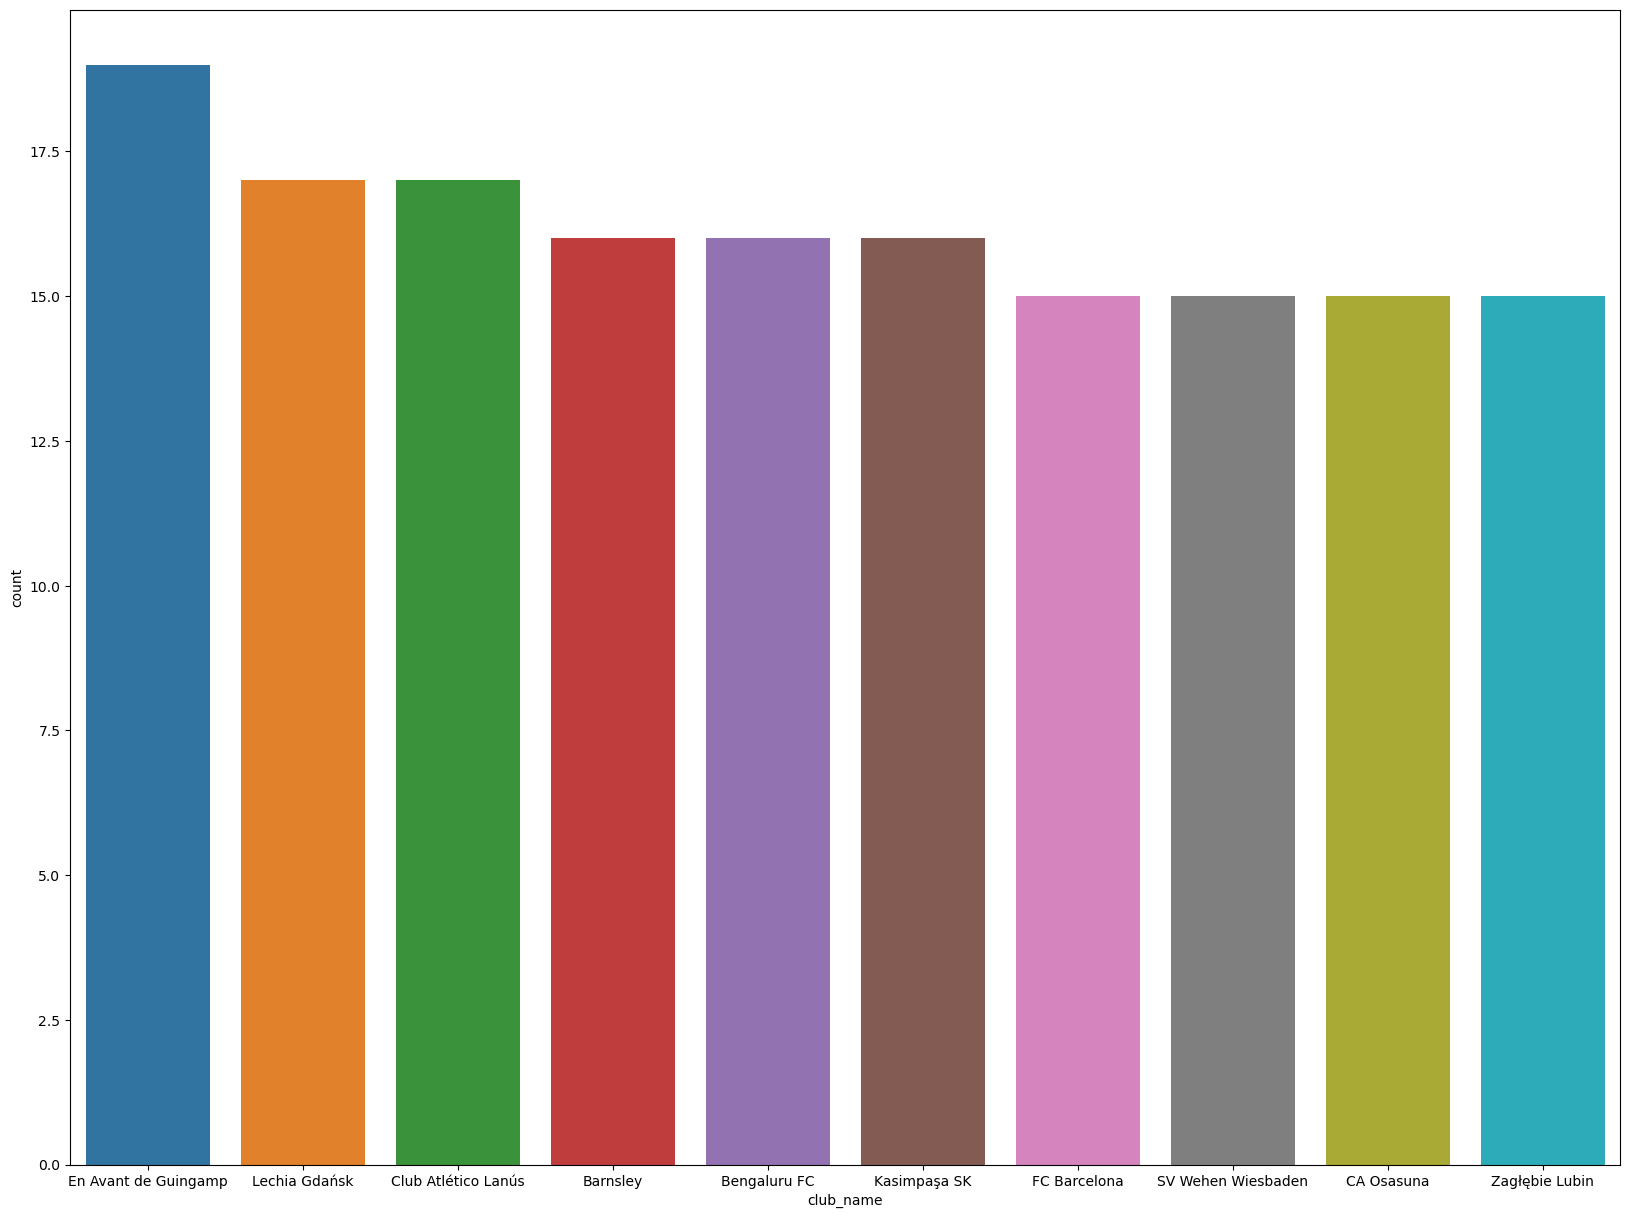

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
def t1_1(df, k:int):
    top = df.filter((df.year=='2022')&(df.club_contract_valid_until=='2023') ) \
            .groupBy("club_name") \
            .count().sort("count",ascending=False) \
            .limit(k) \
            .toPandas()
    plt.figure( figsize = ( 20, 15 ) )
    sns.barplot( x="club_name", y="count", data=top)
    plt.show()

t1_1(df,10)

**Question:** List the Y clubs with highest average number of players that are older than 27 years across all years (i.e. calculate the number of players older than 27 years old for each club in each dataset, calculate the averages and list the Y clubs with highest averages).

The following function `t2_2` takes `k` as a param that corresponds to `Y` in the question. It will show the bar plot of the top `Y` clubs with the highest average number of players that are older than 27 across all years. Please see the X-axis for the names of those clubs.

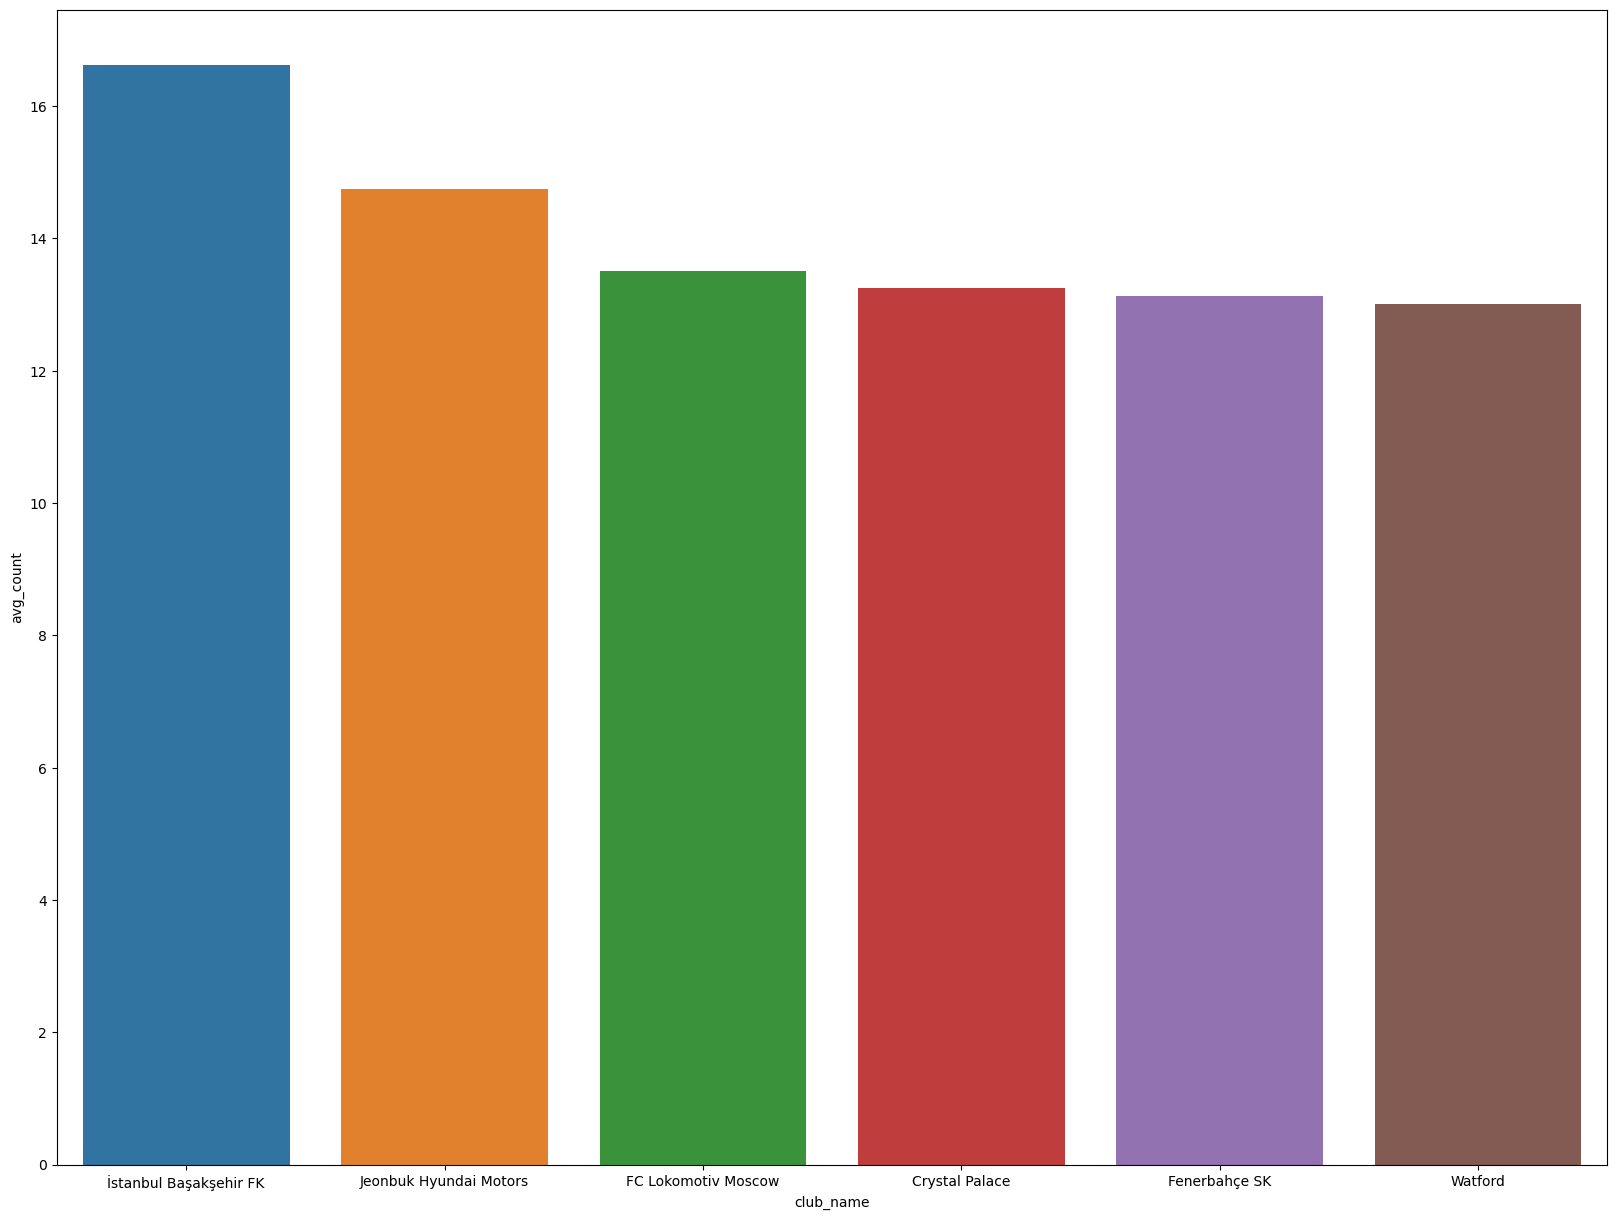

In [11]:
import pyspark.sql.functions as F
# df.filter( (df.age > 27) ).groupBy("club_name").agg(F.countDistinct("sofifa_id").alias("distinct_sofifa_id")).sort()

def t2_2(df,k:int):
    top = df.filter( (df.age > 27) ).groupBy("club_name").count().sort("count",ascending=False).withColumn("avg_count",F.col("count")/8).limit(k)
    top = top.drop("count").toPandas()
    plt.figure( figsize = ( 20, 15 ) )
    sns.barplot( x="club_name", y="avg_count", data=top)
    plt.show()
t2_2(df,7)  

**Question:** What is the most frequent nation_position in the dataset for each year? (i.e. display the most frequent nation_position for 2015, 2016, etc.).

The last cell contains the output of this question (`nation_position` and its `count` per year). In short, `SUB` is the most frequent `nation_position` across all years.

In [12]:
def t2_3(df, year):
    top = df.filter((df.nation_position!="")&(df.year==year)) \
        .groupBy("nation_position") \
        .count() \
        .sort("count",ascending=False) \
        .limit(1) \
        .collect()
    for i in top:
        return tuple(i)
    return (None, None)

In [13]:
for year in range(2015,2023):
    (nation_position, count) = t2_3(df,year)
    print(f"Most frequent nation_position of year [{year}] is [{nation_position}] with count [{count}].")

Most frequent nation_position of year [2015] is [SUB] with count [564].
Most frequent nation_position of year [2016] is [SUB] with count [511].
Most frequent nation_position of year [2017] is [SUB] with count [564].
Most frequent nation_position of year [2018] is [SUB] with count [600].
Most frequent nation_position of year [2019] is [SUB] with count [576].
Most frequent nation_position of year [2020] is [SUB] with count [588].
Most frequent nation_position of year [2021] is [SUB] with count [588].
Most frequent nation_position of year [2022] is [SUB] with count [396].


## Task III Machine Learning Modeling

## Data & feature engineering
First, we need to pre-process our data such that it can be fed into our machine learning models.

The output is the `overall` column, and the other columns can serve as input features.

### Drop columns

I have decided to drop the following columns as they don't seem relevant to the overall value of a player:
- `player_url` (not relevant)
- `short_name` (not relevant)
- `long_name` (not relevant)
- `club_name` (too many values, could be useless)
- `club_loaned_from` (too few values)
- `release_clause_eur` (too few values)
- `player_positions` (cannot be converted into numerics easily)
- `goalkeeping_speed` (too few values)
- `player_traits` (too random)
- `player_tags` (there are missing entries for certain players)
- `real_face` (not relevant)
- `mentality_composure` (too few values)
- `player_face_url` (not relevant)
- `club_logo_url` (not relevant)
- `club_flag_url` (not relevant)
- `nation_logo_url` (not relevant)
- `nation_flag_url` (not relevant)

### Data/feature engineering

As we see from the above schema, the main data types are `string`, `integer`, and `timestamp`.

I will perform the following processing steps.

1. String-index and one-hot encode the columns `["preferred_foot", "body_type", "league_name", "club_position", "nationality_name", "nation_position", "work_rate"]`.
2. Drop columns such as `ls`, `st`, and `gk`, etc. where the values are in the format of `<int>+/-<int>`. There implications are unclear, and how to interpret them is another challenge.

Overall, the steps are as follows:

- Perform the aforementioned steps on the dataframe;
- Drop rows with NULL values (in any columns);
- Use `StringIndexer` for strings (and nominal columns);
    - Use `OneHotEncoder` later on those columns.
- Assemble all feature columns into a column called `features` using `StandardScalar`.
- Keep only the `overall` and `features` columns by removing the others.

In [4]:
# Necessary imports

from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder,VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

class OutcomeCreater(Transformer):
    """Rename overall to outcome and remove overall"""
    def __init__(self):
        super().__init__()
    
    def _transform(self, dataset):
        output_df = dataset.withColumn("outcome", col("overall").cast(IntegerType())).drop("overall")
        return output_df

class TypeConverter(Transformer):
    def __init__(self):
        super().__init__()
    
    def _transform(self, df):
        out_df = df
        out_df = out_df.withColumn("body_type", 
                          when(out_df.body_type.contains("Unique"), lit("Unique"))
                          .when(out_df.body_type.contains("Lean"), lit("Lean"))
                          .when(out_df.body_type.contains("Normal"), lit("Normal"))
                          .when(out_df.body_type.contains("Stocky"), lit("Stocky"))
                          .otherwise(out_df.body_type))
                                  
        return out_df
    
class ColumnDropper(Transformer):
    def __init__(self, dropped_cols):
        super().__init__()
        self.dropped_cols=dropped_cols
        
    def _transform(self, dataset):
        out_df = dataset
        for col_name in self.dropped_cols:
            out_df = out_df.drop(col_name)
        return out_df
    
class NULLDropper(Transformer):
    """Drop all rows with NULL values."""
    def __init__(self,cols):
        super().__init__()
        self.cols=cols
    
    def _transform(self, dataset):
        out_df = dataset
        return out_df.na.drop(subset=self.cols)

def get_pipeline():
    # Get all column names for reference
    col_names = read_col_names("data/players_15.csv")
    cols1 = ['player_url', 'player_positions', 'club_name', 'short_name', 'long_name', 
                    'club_loaned_from', 'release_clause_eur', 'goalkeeping_speed', 'player_traits',
                    'player_tags', 'real_face', 'mentality_composure', 'player_face_url', 'club_logo_url',
                    'club_flag_url', 'nation_logo_url', 'nation_flag_url']
    cols2 = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam',
                'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm',
                'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
    
    stage_conv = TypeConverter()
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_cols = ["preferred_foot", "body_type", "league_name", "club_position", 
                    "nationality_name", "nation_position", "work_rate"]
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    # Drop NULL records for string indexer
    stage_dn1 = NULLDropper(nominal_cols)
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols)
    
    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)
    
    # Stage where all relevant features are assembled into a vector (and dropping a few)
    # We will remove useless columns first.
    feature_cols = set(col_names + nominal_onehot_cols)
    for col in cols1+cols2+nominal_cols+['club_joined','dob']:
        feature_cols.remove(col)
    feature_cols = list(feature_cols)
    # Drop null records for vector assembler
    stage_dn2=NULLDropper(feature_cols)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    
    stage_outcome = OutcomeCreater()
    dropped_cols = col_names+nominal_id_cols+nominal_onehot_cols+['vectorized_features', 'year', 'id']
    # Drop columns and keep only features and outcome columns
    stage_dc = ColumnDropper(dropped_cols)
    
    pipeline = Pipeline(stages=[stage_conv,stage_dn1, stage_nominal_indexer, stage_nominal_onehot_encoder,
                                stage_dn2,stage_vector_assembler, stage_scaler, stage_outcome, stage_dc])
                               
    return pipeline

In [19]:
pipeline = get_pipeline()
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)


# As you see, only column features and outcome are left.
df_transformed.printSchema()
df_transformed.show(1)

# Train/test split
df_train, df_test = df_transformed.randomSplit(weights=[0.8,0.2], seed=200)

root
 |-- features: vector (nullable = true)
 |-- outcome: integer (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(224,[2,49,50,51,...|     94|
+--------------------+-------+
only showing top 1 row



### ML

Since we are predicting a value, regression models are suiting to this use case.

For Spark, I used `RandomForestRegressor` and `DecisionTreeRegressor`. Performance was evaluated using `RegressionEvaluator`.

For Tensorflow, I used <> and <>.

### ML in Spark

In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = RegressionEvaluator(labelCol='outcome', metricName='rmse')

In [21]:
dt = DecisionTreeRegressor(featuresCol='features',labelCol='outcome', maxDepth=5, maxBins=32)
dt_param_grid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [10,25])
             .addGrid(dt.minInstancesPerNode, [1,10])
             .build())
dt_cv = CrossValidator(estimator=dt, 
                       estimatorParamMaps=dt_param_grid,
                       evaluator=evaluator,
                       parallelism=8,
                       numFolds=5)
dt_cv_model = dt_cv.fit(df_train)

Since this is a regression problem, we use RMSE as the evaluation metric. The training and testing RMSEs for `DecisionTreeRegressor` are:

```
Train RMSE (Decision Tree) after Cross-Validation: 0.23735088225226886
Test RMSE (Decision Tree) after Cross-Validation: 0.3993300553320926
```

In [23]:
dt_train_predictions = dt_cv_model.transform(df_train)
print('Train RMSE (Decision Tree) after Cross-Validation:', evaluator.evaluate(dt_train_predictions))
dt_test_predictions = dt_cv_model.transform(df_test)
print('Test RMSE (Decision Tree) after Cross-Validation:', evaluator.evaluate(dt_test_predictions))

Train RMSE (Decision Tree) after Cross-Validation: 0.23735088225226886


Test RMSE (Decision Tree) after Cross-Validation: 0.3993300553320926


In [28]:
rf = RandomForestRegressor(featuresCol='features',labelCol='outcome',  maxDepth=5, maxBins=32)
rf_param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [10,25])
             .addGrid(rf.minInstancesPerNode, [1,10])
             .build())
rf_cv = CrossValidator(estimator=rf, 
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       parallelism=8,
                       numFolds=5)
rf_cv_model = rf_cv.fit(df_train)

22/11/09 15:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1169.9 KiB
22/11/09 15:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1169.9 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1360.3 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1360.3 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1657.3 KiB
22/11/09 15:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1657.4 KiB
22/11/09 15:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1421.8 KiB
22/11/09 15:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1421.8 KiB
22/11/09 15:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1961.2 KiB
22/11/09 15:27:31 WAR

22/11/09 15:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1374.3 KiB
22/11/09 15:27:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/11/09 15:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/11/09 15:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/09 15:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/09 15:27:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/09 15:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1632.3 KiB


22/11/09 15:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1187.2 KiB
22/11/09 15:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB
22/11/09 15:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1187.2 KiB
22/11/09 15:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1386.6 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1386.6 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1697.8 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1697.8 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1466.3 KiB
22/11/09 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1466.3 KiB
22/11/09 15:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1999.6 KiB
22/11/09 15:27:40 WAR

22/11/09 15:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
22/11/09 15:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1197.7 KiB
22/11/09 15:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
22/11/09 15:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1197.7 KiB
22/11/09 15:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1389.8 KiB
22/11/09 15:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1725.2 KiB
22/11/09 15:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1389.8 KiB
22/11/09 15:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1725.2 KiB
22/11/09 15:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB
22/11/09 15:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB
22/11/09 15:27:48 WARN DAGScheduler: Broadcasting large task binary with size 2024.8 KiB
22/11/09 15:27:48 WAR

22/11/09 15:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1169.1 KiB
22/11/09 15:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1169.1 KiB
22/11/09 15:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1311.8 KiB
22/11/09 15:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1311.8 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1699.1 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1699.1 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1410.2 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1410.2 KiB
22/11/09 15:27:55 WARN DAGScheduler: Broadcasting large task binary with size 2008.1 KiB
22/11/09 15:27:56 WAR

22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1378.1 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1378.1 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/11/09 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/11/09 15:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1442.5 KiB
22/11/09 15:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1442.5 KiB
22/11/09 15:28:03 WARN DAGScheduler: Broadcasting large task binary with size 2027.5 KiB
22/11/09 15:28:03 WAR

22/11/09 15:28:13 WARN DAGScheduler: Broadcasting large task binary with size 1320.3 KiB
22/11/09 15:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1754.4 KiB
22/11/09 15:28:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/11/09 15:28:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/11/09 15:28:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/09 15:28:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/11/09 15:28:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/11/09 15:28:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/09 15:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1802.9 KiB


The training and testing RMSEs for `RandomForestRegressor` are:

```
Train RMSE (Random Forest) after Cross-Validation: 0.14752918652557176
Test RMSE (Random Forest) after Cross-Validation: 0.30707915735408975
```

In [29]:
rf_train_predictions = rf_cv_model.transform(df_train)
print('Train RMSE (Random Forest) after Cross-Validation:', evaluator.evaluate(rf_train_predictions))
rf_test_predictions = rf_cv_model.transform(df_test)
print('Test RMSE (Random Forest) after Cross-Validation:', evaluator.evaluate(rf_test_predictions))

Train RMSE (Random Forest) after Cross-Validation: 0.14752918652557176


Test RMSE (Random Forest) after Cross-Validation: 0.30707915735408975


### ML in Tensorflow

I used the following two tree models in Tensorflow (the [`tensorflow_decision_forests`](https://www.tensorflow.org/decision_forests/) package):
- `RandomForestModel`
- `GradientBoostedTreesModel`

For both models, we will tune`max_depth` and `num_trees`.

In [52]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

TF_NUM_THREADS=8
TF_VERBOSE=2

Now, because Tensorflow doesn't provide a reference cross-vaildation implementation, we need to implement it ourselves. I will borrow and tweak some code from my Homework 7.

Here is my approach in x steps:

1. Perform an exhaustive search on the above hyperparameters.
2. Use k-fold cross-validation and select the best model.

I will use 50% of the testing data as for validation (i.e., 80% training, 10% testing, 10% validation).

In [57]:
# Split testing data into testing and validation.
# Prepare data
df_test, df_val = df_test.randomSplit(weights=[0.5, 0.5], seed=200)
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

df_train_pd = df_train.withColumn('features', to_array('features')).toPandas()
df_test_pd = df_test.withColumn('features', to_array('features')).toPandas()
df_val_pd = df_val.withColumn('features', to_array('features')).toPandas()

get_x_for_tf = lambda df: tf.constant(np.array(df["features"].values.tolist(),dtype=np.float32))
get_y_for_tf = lambda df: tf.constant(np.array(df["outcome"].values.tolist(),dtype=np.float32))

x_train = get_x_for_tf(df_train_pd)
y_train = get_y_for_tf(df_train_pd)

x_test = get_x_for_tf(df_test_pd)
y_test = get_y_for_tf(df_test_pd)

x_val = get_x_for_tf(df_val_pd)
y_val = get_y_for_tf(df_val_pd)

In [46]:
# First, we start with RandomForestModel
# We do hyperparam tuning first.
rfm_tuner = tfdf.tuner.RandomSearch(num_trials=20)
rfm_tuner.choice("max_depth", [4,8,16])
rfm_tuner.choice("num_trees", [5,10,20])

rfm = tfdf.keras.RandomForestModel(tuner=rfm_tuner, 
                                   task=tfdf.keras.core.Task.REGRESSION, 
                                   verbose=TF_VERBOSE, 
                                   num_threads=TF_NUM_THREADS)
rfm.fit(x_train, y_train)

Use /var/folders/6v/g07ll2qn75vg0gvmcr52bytm0000gn/T/tmpqb4puay8 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 224), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Seman

Training dataset read in 0:00:01.770104. Found 4744 examples.
Training model...


[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 149
[INFO kernel.cc:423] Number of examples: 4744
[INFO kernel.cc:836] Training dataset:
Number of records: 4744
Number of columns: 225

Number of columns by type:
	NUMERICAL: 225 (100%)

Columns:

NUMERICAL: 225 (100%)
	0: "data:0.0" NUMERICAL mean:0.464905 min:0 max:2.61007 sd:0.998647
	1: "data:0.1" NUMERICAL mean:0.33601 min:0 max:3.30712 sd:0.999161
	2: "data:0.10" NUMERICAL mean:0.169417 min:0 max:6.18243 sd:1.00931
	3: "data:0.100" NUMERICAL mean:0.153779 min:0 max:6.18243 sd:0.962849
	4: "data:0.101" NUMERICAL mean:0.167323 min:0 max:6.20142 sd:1.00481
	5: "data:0.102" NUMERICAL mean:0.171245 min:0 max:6.20142 sd:1.01619
	6: "data:0.103" NUMERICAL mean:0.15604 min:0 max:6.2206 sd:0.972785
	7: "data:0.104" NUMERICAL mean:0.162294 min:0 max:6.25952 sd:0.994757
	8: "data:0.105" NUMERICAL mean:0.171775 min:0 max:6.2206 sd:1.01933
	9: "data:0.106

[INFO hyperparameters_optimizer.cc:207] Hyperparameter search space:
fields {
  name: "max_depth"
  discrete_candidates {
    possible_values {
      integer: 4
    }
    possible_values {
      integer: 8
    }
    possible_values {
      integer: 16
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 5
    }
    possible_values {
      integer: 10
    }
    possible_values {
      integer: 20
    }
  }
}

[INFO hyperparameters_optimizer.cc:480] Start local tuner with 8 thread(s)
[INFO random_forest.cc:407] Training random forest on 4744 example(s) and 224 feature(s).
[INFO random_forest.cc:407] Training random forest on 4744 example(s) and 224 feature(s).
[INFO random_forest.cc:407] Training random forest on 4744 example(s) and 224 feature(s).
[INFO random_forest.cc:407] Training random forest on 4744 example(s) and 224 feature(s).
[INFO random_forest.cc:407] Training random forest on 4744 example(s) and 224 feature(s).
[INFO random_f

Model trained in 0:00:00.539625
Compiling model...
Model compiled.


We keep the same performance metric "rmse" for Tensorflow. The RMSE is much lower in Tensorflow:
```
10/10 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0604
{'loss': 0.0, 'root_mean_squared_error': 0.060356199741363525}
```

In [47]:
rfm.compile(metrics=[tf.keras.metrics.RootMeanSquaredError()])
rmse = rfm.evaluate(x_test, y_test, return_dict=True)
print(rmse)

10/10 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0604
{'loss': 0.0, 'root_mean_squared_error': 0.060356199741363525}


In [69]:
# Now, we use a regular MLP
from tensorflow.keras import backend as K
from tensorflow import keras

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def model_init(metrics):
    model = keras.Sequential([
                        keras.layers.Dense(64,activation='relu'),
                        keras.layers.Dense(128,activation='relu'),
                        keras.layers.Dense(256,activation='relu'),
                        keras.layers.Dense(40,activation='relu'),
                        keras.layers.Dense(1)])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=root_mean_squared_error,
        metrics=metrics)
    return model

In [70]:
mlp = model_init([tf.keras.metrics.RootMeanSquaredError()])
mlp.fit(x_train, y_train, epochs=300, validation_data=(x_val, y_val), verbose=2)

Epoch 1/300
149/149 - 1s - loss: 7.3382 - root_mean_squared_error: 11.0477 - val_loss: 4.1393 - val_root_mean_squared_error: 4.1817 - 769ms/epoch - 5ms/step
Epoch 2/300
149/149 - 0s - loss: 3.1570 - root_mean_squared_error: 3.2723 - val_loss: 2.4827 - val_root_mean_squared_error: 2.4914 - 209ms/epoch - 1ms/step
Epoch 3/300
149/149 - 0s - loss: 2.4685 - root_mean_squared_error: 2.5685 - val_loss: 2.5768 - val_root_mean_squared_error: 2.5933 - 200ms/epoch - 1ms/step
Epoch 4/300
149/149 - 0s - loss: 2.2337 - root_mean_squared_error: 2.2793 - val_loss: 1.8686 - val_root_mean_squared_error: 1.8912 - 198ms/epoch - 1ms/step
Epoch 5/300
149/149 - 0s - loss: 2.1396 - root_mean_squared_error: 2.1768 - val_loss: 1.8001 - val_root_mean_squared_error: 1.8310 - 200ms/epoch - 1ms/step
Epoch 6/300
149/149 - 0s - loss: 2.1324 - root_mean_squared_error: 2.1803 - val_loss: 1.8348 - val_root_mean_squared_error: 1.8473 - 196ms/epoch - 1ms/step
Epoch 7/300
149/149 - 0s - loss: 1.9619 - root_mean_squared_err

Epoch 54/300
149/149 - 0s - loss: 1.0263 - root_mean_squared_error: 1.0611 - val_loss: 0.9980 - val_root_mean_squared_error: 1.0300 - 210ms/epoch - 1ms/step
Epoch 55/300
149/149 - 0s - loss: 0.9532 - root_mean_squared_error: 0.9745 - val_loss: 1.3006 - val_root_mean_squared_error: 1.3082 - 202ms/epoch - 1ms/step
Epoch 56/300
149/149 - 0s - loss: 0.9635 - root_mean_squared_error: 0.9844 - val_loss: 0.9204 - val_root_mean_squared_error: 0.9414 - 206ms/epoch - 1ms/step
Epoch 57/300
149/149 - 0s - loss: 1.0030 - root_mean_squared_error: 1.0297 - val_loss: 1.1724 - val_root_mean_squared_error: 1.1770 - 210ms/epoch - 1ms/step
Epoch 58/300
149/149 - 0s - loss: 1.1669 - root_mean_squared_error: 1.2387 - val_loss: 1.5320 - val_root_mean_squared_error: 1.5436 - 200ms/epoch - 1ms/step
Epoch 59/300
149/149 - 0s - loss: 1.0805 - root_mean_squared_error: 1.1148 - val_loss: 1.2030 - val_root_mean_squared_error: 1.2092 - 207ms/epoch - 1ms/step
Epoch 60/300
149/149 - 0s - loss: 0.9997 - root_mean_squar

Epoch 107/300
149/149 - 0s - loss: 0.7851 - root_mean_squared_error: 0.8083 - val_loss: 0.8625 - val_root_mean_squared_error: 0.8692 - 207ms/epoch - 1ms/step
Epoch 108/300
149/149 - 0s - loss: 0.8017 - root_mean_squared_error: 0.8298 - val_loss: 0.7985 - val_root_mean_squared_error: 0.8068 - 199ms/epoch - 1ms/step
Epoch 109/300
149/149 - 0s - loss: 0.8576 - root_mean_squared_error: 0.8940 - val_loss: 1.3664 - val_root_mean_squared_error: 1.3799 - 201ms/epoch - 1ms/step
Epoch 110/300
149/149 - 0s - loss: 0.7884 - root_mean_squared_error: 0.8136 - val_loss: 0.7758 - val_root_mean_squared_error: 0.7901 - 202ms/epoch - 1ms/step
Epoch 111/300
149/149 - 0s - loss: 0.8323 - root_mean_squared_error: 0.8651 - val_loss: 0.9307 - val_root_mean_squared_error: 0.9429 - 202ms/epoch - 1ms/step
Epoch 112/300
149/149 - 0s - loss: 0.9846 - root_mean_squared_error: 1.0643 - val_loss: 0.8170 - val_root_mean_squared_error: 0.8276 - 212ms/epoch - 1ms/step
Epoch 113/300
149/149 - 0s - loss: 0.7634 - root_mea

Epoch 159/300
149/149 - 0s - loss: 0.6360 - root_mean_squared_error: 0.6562 - val_loss: 1.1010 - val_root_mean_squared_error: 1.1078 - 204ms/epoch - 1ms/step
Epoch 160/300
149/149 - 0s - loss: 0.7494 - root_mean_squared_error: 0.7746 - val_loss: 0.7195 - val_root_mean_squared_error: 0.7356 - 207ms/epoch - 1ms/step
Epoch 161/300
149/149 - 0s - loss: 0.7209 - root_mean_squared_error: 0.7471 - val_loss: 0.7746 - val_root_mean_squared_error: 0.7849 - 207ms/epoch - 1ms/step
Epoch 162/300
149/149 - 0s - loss: 0.7109 - root_mean_squared_error: 0.7394 - val_loss: 1.1870 - val_root_mean_squared_error: 1.1932 - 205ms/epoch - 1ms/step
Epoch 163/300
149/149 - 0s - loss: 0.7316 - root_mean_squared_error: 0.7585 - val_loss: 0.6903 - val_root_mean_squared_error: 0.7079 - 214ms/epoch - 1ms/step
Epoch 164/300
149/149 - 0s - loss: 0.7078 - root_mean_squared_error: 0.7264 - val_loss: 0.6393 - val_root_mean_squared_error: 0.6508 - 209ms/epoch - 1ms/step
Epoch 165/300
149/149 - 0s - loss: 0.8295 - root_mea

Epoch 211/300
149/149 - 0s - loss: 0.6041 - root_mean_squared_error: 0.6322 - val_loss: 1.0192 - val_root_mean_squared_error: 1.0260 - 207ms/epoch - 1ms/step
Epoch 212/300
149/149 - 0s - loss: 0.6262 - root_mean_squared_error: 0.6500 - val_loss: 0.8076 - val_root_mean_squared_error: 0.8163 - 200ms/epoch - 1ms/step
Epoch 213/300
149/149 - 0s - loss: 0.6087 - root_mean_squared_error: 0.6338 - val_loss: 1.1133 - val_root_mean_squared_error: 1.1317 - 210ms/epoch - 1ms/step
Epoch 214/300
149/149 - 0s - loss: 0.6316 - root_mean_squared_error: 0.6596 - val_loss: 0.6447 - val_root_mean_squared_error: 0.6589 - 209ms/epoch - 1ms/step
Epoch 215/300
149/149 - 0s - loss: 0.6504 - root_mean_squared_error: 0.6792 - val_loss: 0.7071 - val_root_mean_squared_error: 0.7208 - 207ms/epoch - 1ms/step
Epoch 216/300
149/149 - 0s - loss: 0.6770 - root_mean_squared_error: 0.7415 - val_loss: 1.1669 - val_root_mean_squared_error: 1.1710 - 208ms/epoch - 1ms/step
Epoch 217/300
149/149 - 0s - loss: 1.0701 - root_mea

Epoch 263/300
149/149 - 0s - loss: 0.5908 - root_mean_squared_error: 0.6161 - val_loss: 0.5891 - val_root_mean_squared_error: 0.6029 - 214ms/epoch - 1ms/step
Epoch 264/300
149/149 - 0s - loss: 0.5749 - root_mean_squared_error: 0.5966 - val_loss: 0.6233 - val_root_mean_squared_error: 0.6334 - 213ms/epoch - 1ms/step
Epoch 265/300
149/149 - 0s - loss: 0.5632 - root_mean_squared_error: 0.5854 - val_loss: 0.9350 - val_root_mean_squared_error: 0.9436 - 213ms/epoch - 1ms/step
Epoch 266/300
149/149 - 0s - loss: 0.5787 - root_mean_squared_error: 0.6049 - val_loss: 0.9934 - val_root_mean_squared_error: 0.9997 - 211ms/epoch - 1ms/step
Epoch 267/300
149/149 - 0s - loss: 0.5581 - root_mean_squared_error: 0.5831 - val_loss: 0.8016 - val_root_mean_squared_error: 0.8111 - 215ms/epoch - 1ms/step
Epoch 268/300
149/149 - 0s - loss: 0.5542 - root_mean_squared_error: 0.5793 - val_loss: 0.6789 - val_root_mean_squared_error: 0.6880 - 210ms/epoch - 1ms/step
Epoch 269/300
149/149 - 0s - loss: 0.6295 - root_mea

Similarly, we have the following rmse for MLP:
```
5/5 [==============================] - 0s 1ms/step - loss: 0.6214 - root_mean_squared_error: 0.6289
{'loss': 0.6213715672492981, 'root_mean_squared_error': 0.6288880705833435}
```

In [71]:
rmse = mlp.evaluate(x_test, y_test, return_dict=True)
print(rmse)

5/5 [==============================] - 0s 1ms/step - loss: 0.6214 - root_mean_squared_error: 0.6289
{'loss': 0.6213715672492981, 'root_mean_squared_error': 0.6288880705833435}


In [82]:
# Cross validation on MLP
from sklearn.model_selection import KFold


def cv(X, Y, model_init, k, epochs=150):
    """Cross-validation that returns the average value of the metric.
    - X: features data
    - Y: output data
    - model_init: a function that creates and initializes a Keras model.
    - k: number of folds
    """
    # [loss, rmse]
    scores=[0.0, 0.0]
    best_model = None
    min_loss=float('inf')
    
    for train_i, test_i in KFold(k).split(X):
        x_train = tf.gather(X, train_i); x_test = tf.gather(X, test_i)
        y_train = tf.gather(Y, train_i); y_test = tf.gather(Y, test_i)
        model = model_init()
        model.fit(x_train, y_train, epochs=epochs, verbose=2)
        [loss,rmse] = model.evaluate(x_test,y_test)
        scores[0]+=loss;scores[1]+=rmse
        if min_loss>loss:
            min_loss=loss; best_model = model
    scores[0]/=k; scores[1]/=k
    return scores, best_model


def get_init_function(hparams, out_size=1):
    def model_init():
        model = keras.Sequential()
        for w in hparams['layers']:
            model.add(keras.layers.Dense(w,activation="relu"))
        model.add(keras.layers.Dense(out_size, activation='relu'))
        model.compile(
            loss=root_mean_squared_error, 
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
            optimizer=keras.optimizers.Adam(learning_rate=hparams['lr'])
        )
        return model
    return model_init

hp = {}
# we minimize the validation loss
min_loss = min_rmse = float('inf'); best_mlp = None
for w1 in [32,64,]:
    for w2 in [64, 128]:
        for w3 in [64, 32]:
            hp['layers'] = [w1,w2,w3]
            for lr in [1e-3, 1e-4]:
                hp['lr'] = lr
                model_init = get_init_function(hp)
                [loss, rmse],model = cv(x_train,y_train,model_init,5)
                if loss < min_loss:
                    min_loss = loss; min_rmse = rmse; 
                    best_mlp = model
        

# We will tune the following (150 epochs per config):
# 1. first layer [32,64]
# 2. second layer [64,128]
# 3. third layer [16,32]
# 4. lr: [1e-3,1e-4]

Epoch 1/150
119/119 - 0s - loss: 8.4486 - root_mean_squared_error: 12.7819 - 465ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 3.5527 - root_mean_squared_error: 3.6919 - 105ms/epoch - 881us/step
Epoch 3/150
119/119 - 0s - loss: 2.4713 - root_mean_squared_error: 2.5143 - 103ms/epoch - 869us/step
Epoch 4/150
119/119 - 0s - loss: 2.1272 - root_mean_squared_error: 2.1513 - 103ms/epoch - 863us/step
Epoch 5/150
119/119 - 0s - loss: 2.1801 - root_mean_squared_error: 2.2240 - 105ms/epoch - 878us/step
Epoch 6/150
119/119 - 0s - loss: 2.0397 - root_mean_squared_error: 2.0800 - 104ms/epoch - 872us/step
Epoch 7/150
119/119 - 0s - loss: 1.9655 - root_mean_squared_error: 1.9913 - 102ms/epoch - 855us/step
Epoch 8/150
119/119 - 0s - loss: 1.9198 - root_mean_squared_error: 1.9475 - 105ms/epoch - 884us/step
Epoch 9/150
119/119 - 0s - loss: 1.8283 - root_mean_squared_error: 1.8524 - 104ms/epoch - 874us/step
Epoch 10/150
119/119 - 0s - loss: 1.7631 - root_mean_squared_error: 1.7848 - 105ms/epoch - 8

Epoch 82/150
119/119 - 0s - loss: 0.8419 - root_mean_squared_error: 0.8628 - 114ms/epoch - 959us/step
Epoch 83/150
119/119 - 0s - loss: 0.9095 - root_mean_squared_error: 0.9288 - 112ms/epoch - 942us/step
Epoch 84/150
119/119 - 0s - loss: 0.8804 - root_mean_squared_error: 0.9038 - 102ms/epoch - 855us/step
Epoch 85/150
119/119 - 0s - loss: 0.8497 - root_mean_squared_error: 0.8757 - 100ms/epoch - 836us/step
Epoch 86/150
119/119 - 0s - loss: 0.8347 - root_mean_squared_error: 0.8564 - 101ms/epoch - 849us/step
Epoch 87/150
119/119 - 0s - loss: 0.8722 - root_mean_squared_error: 0.8928 - 100ms/epoch - 842us/step
Epoch 88/150
119/119 - 0s - loss: 0.9177 - root_mean_squared_error: 0.9439 - 103ms/epoch - 863us/step
Epoch 89/150
119/119 - 0s - loss: 0.7923 - root_mean_squared_error: 0.8066 - 104ms/epoch - 873us/step
Epoch 90/150
119/119 - 0s - loss: 0.8409 - root_mean_squared_error: 0.8629 - 99ms/epoch - 828us/step
Epoch 91/150
119/119 - 0s - loss: 0.7944 - root_mean_squared_error: 0.8147 - 101ms/

Epoch 11/150
119/119 - 0s - loss: 74.9876 - root_mean_squared_error: 74.9944 - 100ms/epoch - 842us/step
Epoch 12/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_error: 74.9944 - 102ms/epoch - 854us/step
Epoch 13/150
119/119 - 0s - loss: 74.9876 - root_mean_squared_error: 74.9944 - 101ms/epoch - 853us/step
Epoch 14/150
119/119 - 0s - loss: 74.9880 - root_mean_squared_error: 74.9944 - 99ms/epoch - 834us/step
Epoch 15/150
119/119 - 0s - loss: 74.9863 - root_mean_squared_error: 74.9944 - 100ms/epoch - 839us/step
Epoch 16/150
119/119 - 0s - loss: 74.9859 - root_mean_squared_error: 74.9944 - 104ms/epoch - 875us/step
Epoch 17/150
119/119 - 0s - loss: 74.9859 - root_mean_squared_error: 74.9944 - 100ms/epoch - 842us/step
Epoch 18/150
119/119 - 0s - loss: 74.9865 - root_mean_squared_error: 74.9944 - 103ms/epoch - 870us/step
Epoch 19/150
119/119 - 0s - loss: 74.9867 - root_mean_squared_error: 74.9944 - 116ms/epoch - 977us/step
Epoch 20/150
119/119 - 0s - loss: 74.9866 - root_mean_squared_err

Epoch 90/150
119/119 - 0s - loss: 74.9871 - root_mean_squared_error: 74.9944 - 107ms/epoch - 903us/step
Epoch 91/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 110ms/epoch - 921us/step
Epoch 92/150
119/119 - 0s - loss: 74.9891 - root_mean_squared_error: 74.9944 - 107ms/epoch - 901us/step
Epoch 93/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 108ms/epoch - 905us/step
Epoch 94/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 108ms/epoch - 907us/step
Epoch 95/150
119/119 - 0s - loss: 74.9879 - root_mean_squared_error: 74.9944 - 108ms/epoch - 908us/step
Epoch 96/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 106ms/epoch - 887us/step
Epoch 97/150
119/119 - 0s - loss: 74.9874 - root_mean_squared_error: 74.9944 - 110ms/epoch - 921us/step
Epoch 98/150
119/119 - 0s - loss: 74.9852 - root_mean_squared_error: 74.9944 - 111ms/epoch - 933us/step
Epoch 99/150
119/119 - 0s - loss: 74.9864 - root_mean_squared_er

Epoch 18/150
119/119 - 0s - loss: 1.5353 - root_mean_squared_error: 1.5840 - 101ms/epoch - 847us/step
Epoch 19/150
119/119 - 0s - loss: 1.4906 - root_mean_squared_error: 1.5291 - 100ms/epoch - 837us/step
Epoch 20/150
119/119 - 0s - loss: 1.5265 - root_mean_squared_error: 1.5666 - 99ms/epoch - 836us/step
Epoch 21/150
119/119 - 0s - loss: 1.2473 - root_mean_squared_error: 1.2603 - 101ms/epoch - 846us/step
Epoch 22/150
119/119 - 0s - loss: 1.2512 - root_mean_squared_error: 1.2705 - 100ms/epoch - 838us/step
Epoch 23/150
119/119 - 0s - loss: 1.3718 - root_mean_squared_error: 1.3952 - 104ms/epoch - 876us/step
Epoch 24/150
119/119 - 0s - loss: 1.2700 - root_mean_squared_error: 1.2952 - 101ms/epoch - 847us/step
Epoch 25/150
119/119 - 0s - loss: 1.3044 - root_mean_squared_error: 1.3269 - 103ms/epoch - 862us/step
Epoch 26/150
119/119 - 0s - loss: 1.2064 - root_mean_squared_error: 1.2286 - 103ms/epoch - 867us/step
Epoch 27/150
119/119 - 0s - loss: 1.1827 - root_mean_squared_error: 1.2024 - 101ms/

Epoch 99/150
119/119 - 0s - loss: 0.8062 - root_mean_squared_error: 0.8410 - 101ms/epoch - 845us/step
Epoch 100/150
119/119 - 0s - loss: 0.7588 - root_mean_squared_error: 0.7736 - 101ms/epoch - 849us/step
Epoch 101/150
119/119 - 0s - loss: 0.7376 - root_mean_squared_error: 0.7508 - 100ms/epoch - 841us/step
Epoch 102/150
119/119 - 0s - loss: 0.7212 - root_mean_squared_error: 0.7339 - 102ms/epoch - 860us/step
Epoch 103/150
119/119 - 0s - loss: 0.7146 - root_mean_squared_error: 0.7299 - 101ms/epoch - 848us/step
Epoch 104/150
119/119 - 0s - loss: 0.8685 - root_mean_squared_error: 0.9289 - 100ms/epoch - 838us/step
Epoch 105/150
119/119 - 0s - loss: 0.7922 - root_mean_squared_error: 0.8141 - 101ms/epoch - 850us/step
Epoch 106/150
119/119 - 0s - loss: 0.7264 - root_mean_squared_error: 0.7412 - 101ms/epoch - 847us/step
Epoch 107/150
119/119 - 0s - loss: 0.7538 - root_mean_squared_error: 0.7690 - 101ms/epoch - 849us/step
Epoch 108/150
119/119 - 0s - loss: 0.8948 - root_mean_squared_error: 0.949

Epoch 28/150
119/119 - 0s - loss: 1.4379 - root_mean_squared_error: 1.4706 - 104ms/epoch - 870us/step
Epoch 29/150
119/119 - 0s - loss: 1.2762 - root_mean_squared_error: 1.2928 - 105ms/epoch - 879us/step
Epoch 30/150
119/119 - 0s - loss: 1.2864 - root_mean_squared_error: 1.3079 - 102ms/epoch - 854us/step
Epoch 31/150
119/119 - 0s - loss: 1.2946 - root_mean_squared_error: 1.3187 - 101ms/epoch - 845us/step
Epoch 32/150
119/119 - 0s - loss: 1.2934 - root_mean_squared_error: 1.3159 - 101ms/epoch - 849us/step
Epoch 33/150
119/119 - 0s - loss: 1.3453 - root_mean_squared_error: 1.3762 - 105ms/epoch - 886us/step
Epoch 34/150
119/119 - 0s - loss: 1.3161 - root_mean_squared_error: 1.3387 - 103ms/epoch - 866us/step
Epoch 35/150
119/119 - 0s - loss: 1.1624 - root_mean_squared_error: 1.1811 - 104ms/epoch - 874us/step
Epoch 36/150
119/119 - 0s - loss: 1.1869 - root_mean_squared_error: 1.2078 - 100ms/epoch - 841us/step
Epoch 37/150
119/119 - 0s - loss: 1.1539 - root_mean_squared_error: 1.1737 - 109ms

Epoch 109/150
119/119 - 0s - loss: 0.7375 - root_mean_squared_error: 0.7513 - 106ms/epoch - 892us/step
Epoch 110/150
119/119 - 0s - loss: 0.9720 - root_mean_squared_error: 1.0200 - 102ms/epoch - 859us/step
Epoch 111/150
119/119 - 0s - loss: 0.8014 - root_mean_squared_error: 0.8253 - 109ms/epoch - 915us/step
Epoch 112/150
119/119 - 0s - loss: 0.7561 - root_mean_squared_error: 0.7714 - 103ms/epoch - 863us/step
Epoch 113/150
119/119 - 0s - loss: 0.8300 - root_mean_squared_error: 0.8492 - 102ms/epoch - 854us/step
Epoch 114/150
119/119 - 0s - loss: 0.7655 - root_mean_squared_error: 0.7845 - 102ms/epoch - 857us/step
Epoch 115/150
119/119 - 0s - loss: 0.7618 - root_mean_squared_error: 0.7790 - 101ms/epoch - 849us/step
Epoch 116/150
119/119 - 0s - loss: 0.7513 - root_mean_squared_error: 0.7729 - 101ms/epoch - 848us/step
Epoch 117/150
119/119 - 0s - loss: 0.7981 - root_mean_squared_error: 0.8201 - 100ms/epoch - 844us/step
Epoch 118/150
119/119 - 0s - loss: 0.8201 - root_mean_squared_error: 0.83

Epoch 38/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 101ms/epoch - 849us/step
Epoch 39/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 102ms/epoch - 855us/step
Epoch 40/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 99ms/epoch - 833us/step
Epoch 41/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 100ms/epoch - 837us/step
Epoch 42/150
119/119 - 0s - loss: 76.8939 - root_mean_squared_error: 76.8996 - 98ms/epoch - 824us/step
Epoch 43/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 98ms/epoch - 826us/step
Epoch 44/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error: 76.8996 - 101ms/epoch - 846us/step
Epoch 45/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 101ms/epoch - 853us/step
Epoch 46/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 102ms/epoch - 856us/step
Epoch 47/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error

Epoch 117/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 101ms/epoch - 847us/step
Epoch 118/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 99ms/epoch - 833us/step
Epoch 119/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 101ms/epoch - 850us/step
Epoch 120/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 102ms/epoch - 854us/step
Epoch 121/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 103ms/epoch - 863us/step
Epoch 122/150
119/119 - 0s - loss: 76.8918 - root_mean_squared_error: 76.8996 - 105ms/epoch - 884us/step
Epoch 123/150
119/119 - 0s - loss: 76.8920 - root_mean_squared_error: 76.8996 - 104ms/epoch - 870us/step
Epoch 124/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_error: 76.8996 - 102ms/epoch - 856us/step
Epoch 125/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_error: 76.8996 - 99ms/epoch - 836us/step
Epoch 126/150
119/119 - 0s - loss: 76.8933 - root_mean_sq

Epoch 46/150
119/119 - 0s - loss: 1.5561 - root_mean_squared_error: 1.5737 - 105ms/epoch - 879us/step
Epoch 47/150
119/119 - 0s - loss: 1.5388 - root_mean_squared_error: 1.5552 - 100ms/epoch - 840us/step
Epoch 48/150
119/119 - 0s - loss: 1.5282 - root_mean_squared_error: 1.5442 - 100ms/epoch - 838us/step
Epoch 49/150
119/119 - 0s - loss: 1.5360 - root_mean_squared_error: 1.5527 - 100ms/epoch - 840us/step
Epoch 50/150
119/119 - 0s - loss: 1.4978 - root_mean_squared_error: 1.5137 - 103ms/epoch - 861us/step
Epoch 51/150
119/119 - 0s - loss: 1.5339 - root_mean_squared_error: 1.5515 - 103ms/epoch - 863us/step
Epoch 52/150
119/119 - 0s - loss: 1.5341 - root_mean_squared_error: 1.5492 - 100ms/epoch - 844us/step
Epoch 53/150
119/119 - 0s - loss: 1.4875 - root_mean_squared_error: 1.5041 - 102ms/epoch - 854us/step
Epoch 54/150
119/119 - 0s - loss: 1.4881 - root_mean_squared_error: 1.5006 - 99ms/epoch - 832us/step
Epoch 55/150
119/119 - 0s - loss: 1.4698 - root_mean_squared_error: 1.4850 - 100ms/

Epoch 127/150
119/119 - 0s - loss: 1.0642 - root_mean_squared_error: 1.0735 - 99ms/epoch - 836us/step
Epoch 128/150
119/119 - 0s - loss: 1.0632 - root_mean_squared_error: 1.0745 - 100ms/epoch - 837us/step
Epoch 129/150
119/119 - 0s - loss: 1.0613 - root_mean_squared_error: 1.0717 - 99ms/epoch - 833us/step
Epoch 130/150
119/119 - 0s - loss: 1.0589 - root_mean_squared_error: 1.0712 - 99ms/epoch - 836us/step
Epoch 131/150
119/119 - 0s - loss: 1.0486 - root_mean_squared_error: 1.0577 - 100ms/epoch - 841us/step
Epoch 132/150
119/119 - 0s - loss: 1.0582 - root_mean_squared_error: 1.0722 - 99ms/epoch - 832us/step
Epoch 133/150
119/119 - 0s - loss: 1.0534 - root_mean_squared_error: 1.0659 - 99ms/epoch - 835us/step
Epoch 134/150
119/119 - 0s - loss: 1.0424 - root_mean_squared_error: 1.0524 - 105ms/epoch - 884us/step
Epoch 135/150
119/119 - 0s - loss: 1.0647 - root_mean_squared_error: 1.0800 - 102ms/epoch - 854us/step
Epoch 136/150
119/119 - 0s - loss: 1.0315 - root_mean_squared_error: 1.0426 - 

Epoch 57/150
119/119 - 0s - loss: 1.5466 - root_mean_squared_error: 1.5648 - 102ms/epoch - 855us/step
Epoch 58/150
119/119 - 0s - loss: 1.5357 - root_mean_squared_error: 1.5496 - 103ms/epoch - 866us/step
Epoch 59/150
119/119 - 0s - loss: 1.5312 - root_mean_squared_error: 1.5472 - 103ms/epoch - 862us/step
Epoch 60/150
119/119 - 0s - loss: 1.5231 - root_mean_squared_error: 1.5383 - 102ms/epoch - 856us/step
Epoch 61/150
119/119 - 0s - loss: 1.5250 - root_mean_squared_error: 1.5403 - 100ms/epoch - 840us/step
Epoch 62/150
119/119 - 0s - loss: 1.5040 - root_mean_squared_error: 1.5188 - 103ms/epoch - 864us/step
Epoch 63/150
119/119 - 0s - loss: 1.5046 - root_mean_squared_error: 1.5207 - 101ms/epoch - 848us/step
Epoch 64/150
119/119 - 0s - loss: 1.5427 - root_mean_squared_error: 1.5627 - 100ms/epoch - 839us/step
Epoch 65/150
119/119 - 0s - loss: 1.4834 - root_mean_squared_error: 1.4977 - 101ms/epoch - 846us/step
Epoch 66/150
119/119 - 0s - loss: 1.4960 - root_mean_squared_error: 1.5147 - 99ms/

119/119 - 0s - loss: 1.0912 - root_mean_squared_error: 1.1052 - 102ms/epoch - 854us/step
Epoch 138/150
119/119 - 0s - loss: 1.0985 - root_mean_squared_error: 1.1079 - 100ms/epoch - 837us/step
Epoch 139/150
119/119 - 0s - loss: 1.0745 - root_mean_squared_error: 1.0867 - 99ms/epoch - 828us/step
Epoch 140/150
119/119 - 0s - loss: 1.0808 - root_mean_squared_error: 1.0972 - 99ms/epoch - 836us/step
Epoch 141/150
119/119 - 0s - loss: 1.0651 - root_mean_squared_error: 1.0778 - 100ms/epoch - 838us/step
Epoch 142/150
119/119 - 0s - loss: 1.0539 - root_mean_squared_error: 1.0671 - 100ms/epoch - 838us/step
Epoch 143/150
119/119 - 0s - loss: 1.0767 - root_mean_squared_error: 1.0899 - 101ms/epoch - 852us/step
Epoch 144/150
119/119 - 0s - loss: 1.0716 - root_mean_squared_error: 1.0856 - 101ms/epoch - 846us/step
Epoch 145/150
119/119 - 0s - loss: 1.1000 - root_mean_squared_error: 1.1155 - 101ms/epoch - 846us/step
Epoch 146/150
119/119 - 0s - loss: 1.0558 - root_mean_squared_error: 1.0690 - 100ms/epoch

Epoch 67/150
119/119 - 0s - loss: 1.3106 - root_mean_squared_error: 1.3196 - 102ms/epoch - 854us/step
Epoch 68/150
119/119 - 0s - loss: 1.3278 - root_mean_squared_error: 1.3403 - 101ms/epoch - 850us/step
Epoch 69/150
119/119 - 0s - loss: 1.3175 - root_mean_squared_error: 1.3313 - 105ms/epoch - 885us/step
Epoch 70/150
119/119 - 0s - loss: 1.2987 - root_mean_squared_error: 1.3098 - 102ms/epoch - 859us/step
Epoch 71/150
119/119 - 0s - loss: 1.3025 - root_mean_squared_error: 1.3165 - 103ms/epoch - 864us/step
Epoch 72/150
119/119 - 0s - loss: 1.2499 - root_mean_squared_error: 1.2611 - 102ms/epoch - 856us/step
Epoch 73/150
119/119 - 0s - loss: 1.2619 - root_mean_squared_error: 1.2719 - 101ms/epoch - 851us/step
Epoch 74/150
119/119 - 0s - loss: 1.2521 - root_mean_squared_error: 1.2652 - 100ms/epoch - 840us/step
Epoch 75/150
119/119 - 0s - loss: 1.2296 - root_mean_squared_error: 1.2397 - 102ms/epoch - 855us/step
Epoch 76/150
119/119 - 0s - loss: 1.2590 - root_mean_squared_error: 1.2732 - 101ms

Epoch 147/150
119/119 - 0s - loss: 0.8942 - root_mean_squared_error: 0.9022 - 100ms/epoch - 839us/step
Epoch 148/150
119/119 - 0s - loss: 0.8798 - root_mean_squared_error: 0.8866 - 100ms/epoch - 841us/step
Epoch 149/150
119/119 - 0s - loss: 0.9021 - root_mean_squared_error: 0.9155 - 103ms/epoch - 863us/step
Epoch 150/150
119/119 - 0s - loss: 0.8748 - root_mean_squared_error: 0.8851 - 101ms/epoch - 853us/step
30/30 [==============================] - 0s 714us/step - loss: 1.0557 - root_mean_squared_error: 1.0812
Epoch 1/150
119/119 - 0s - loss: 22.9791 - root_mean_squared_error: 31.8186 - 441ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 5.9514 - root_mean_squared_error: 5.9952 - 101ms/epoch - 846us/step
Epoch 3/150
119/119 - 0s - loss: 5.7502 - root_mean_squared_error: 5.7907 - 101ms/epoch - 848us/step
Epoch 4/150
119/119 - 0s - loss: 5.5044 - root_mean_squared_error: 5.5380 - 102ms/epoch - 854us/step
Epoch 5/150
119/119 - 0s - loss: 5.2527 - root_mean_squared_error: 5.2850 - 103m

Epoch 77/150
119/119 - 0s - loss: 1.4359 - root_mean_squared_error: 1.4567 - 102ms/epoch - 856us/step
Epoch 78/150
119/119 - 0s - loss: 1.3748 - root_mean_squared_error: 1.3914 - 102ms/epoch - 858us/step
Epoch 79/150
119/119 - 0s - loss: 1.3682 - root_mean_squared_error: 1.3827 - 101ms/epoch - 851us/step
Epoch 80/150
119/119 - 0s - loss: 1.3640 - root_mean_squared_error: 1.3822 - 100ms/epoch - 840us/step
Epoch 81/150
119/119 - 0s - loss: 1.3709 - root_mean_squared_error: 1.3855 - 101ms/epoch - 847us/step
Epoch 82/150
119/119 - 0s - loss: 1.3534 - root_mean_squared_error: 1.3686 - 101ms/epoch - 851us/step
Epoch 83/150
119/119 - 0s - loss: 1.3620 - root_mean_squared_error: 1.3789 - 101ms/epoch - 847us/step
Epoch 84/150
119/119 - 0s - loss: 1.3647 - root_mean_squared_error: 1.3796 - 100ms/epoch - 841us/step
Epoch 85/150
119/119 - 0s - loss: 1.3438 - root_mean_squared_error: 1.3588 - 100ms/epoch - 841us/step
Epoch 86/150
119/119 - 0s - loss: 1.3290 - root_mean_squared_error: 1.3446 - 101ms

Epoch 6/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 102ms/epoch - 857us/step
Epoch 7/150
119/119 - 0s - loss: 76.8915 - root_mean_squared_error: 76.8996 - 101ms/epoch - 853us/step
Epoch 8/150
119/119 - 0s - loss: 76.8923 - root_mean_squared_error: 76.8996 - 103ms/epoch - 862us/step
Epoch 9/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 102ms/epoch - 860us/step
Epoch 10/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 105ms/epoch - 883us/step
Epoch 11/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 103ms/epoch - 868us/step
Epoch 12/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 103ms/epoch - 865us/step
Epoch 13/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 102ms/epoch - 859us/step
Epoch 14/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.8996 - 104ms/epoch - 878us/step
Epoch 15/150
119/119 - 0s - loss: 76.8920 - root_mean_squared_error:

Epoch 85/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 105ms/epoch - 884us/step
Epoch 86/150
119/119 - 0s - loss: 76.8947 - root_mean_squared_error: 76.8996 - 103ms/epoch - 869us/step
Epoch 87/150
119/119 - 0s - loss: 76.8923 - root_mean_squared_error: 76.8996 - 102ms/epoch - 859us/step
Epoch 88/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 104ms/epoch - 873us/step
Epoch 89/150
119/119 - 0s - loss: 76.8918 - root_mean_squared_error: 76.8996 - 109ms/epoch - 912us/step
Epoch 90/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 110ms/epoch - 925us/step
Epoch 91/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 105ms/epoch - 882us/step
Epoch 92/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 110ms/epoch - 924us/step
Epoch 93/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 106ms/epoch - 894us/step
Epoch 94/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_er

Epoch 13/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 103ms/epoch - 865us/step
Epoch 14/150
119/119 - 0s - loss: 74.9662 - root_mean_squared_error: 74.9748 - 99ms/epoch - 831us/step
Epoch 15/150
119/119 - 0s - loss: 74.9670 - root_mean_squared_error: 74.9748 - 102ms/epoch - 854us/step
Epoch 16/150
119/119 - 0s - loss: 74.9670 - root_mean_squared_error: 74.9748 - 100ms/epoch - 841us/step
Epoch 17/150
119/119 - 0s - loss: 74.9676 - root_mean_squared_error: 74.9748 - 100ms/epoch - 841us/step
Epoch 18/150
119/119 - 0s - loss: 74.9679 - root_mean_squared_error: 74.9748 - 106ms/epoch - 890us/step
Epoch 19/150
119/119 - 0s - loss: 74.9684 - root_mean_squared_error: 74.9748 - 105ms/epoch - 881us/step
Epoch 20/150
119/119 - 0s - loss: 74.9656 - root_mean_squared_error: 74.9748 - 103ms/epoch - 864us/step
Epoch 21/150
119/119 - 0s - loss: 74.9678 - root_mean_squared_error: 74.9748 - 101ms/epoch - 847us/step
Epoch 22/150
119/119 - 0s - loss: 74.9648 - root_mean_squared_err

Epoch 92/150
119/119 - 0s - loss: 74.9681 - root_mean_squared_error: 74.9748 - 102ms/epoch - 853us/step
Epoch 93/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 104ms/epoch - 876us/step
Epoch 94/150
119/119 - 0s - loss: 74.9677 - root_mean_squared_error: 74.9748 - 110ms/epoch - 928us/step
Epoch 95/150
119/119 - 0s - loss: 74.9673 - root_mean_squared_error: 74.9748 - 106ms/epoch - 889us/step
Epoch 96/150
119/119 - 0s - loss: 74.9661 - root_mean_squared_error: 74.9748 - 106ms/epoch - 892us/step
Epoch 97/150
119/119 - 0s - loss: 74.9673 - root_mean_squared_error: 74.9748 - 104ms/epoch - 870us/step
Epoch 98/150
119/119 - 0s - loss: 74.9691 - root_mean_squared_error: 74.9748 - 101ms/epoch - 849us/step
Epoch 99/150
119/119 - 0s - loss: 74.9686 - root_mean_squared_error: 74.9748 - 100ms/epoch - 837us/step
Epoch 100/150
119/119 - 0s - loss: 74.9689 - root_mean_squared_error: 74.9748 - 101ms/epoch - 851us/step
Epoch 101/150
119/119 - 0s - loss: 74.9676 - root_mean_squared_

Epoch 20/150
119/119 - 0s - loss: 1.5108 - root_mean_squared_error: 1.5368 - 99ms/epoch - 834us/step
Epoch 21/150
119/119 - 0s - loss: 1.5835 - root_mean_squared_error: 1.6231 - 99ms/epoch - 832us/step
Epoch 22/150
119/119 - 0s - loss: 1.4926 - root_mean_squared_error: 1.5179 - 98ms/epoch - 827us/step
Epoch 23/150
119/119 - 0s - loss: 1.6086 - root_mean_squared_error: 1.6627 - 101ms/epoch - 852us/step
Epoch 24/150
119/119 - 0s - loss: 1.3714 - root_mean_squared_error: 1.3966 - 101ms/epoch - 845us/step
Epoch 25/150
119/119 - 0s - loss: 1.4549 - root_mean_squared_error: 1.4843 - 100ms/epoch - 842us/step
Epoch 26/150
119/119 - 0s - loss: 1.6119 - root_mean_squared_error: 1.6565 - 99ms/epoch - 836us/step
Epoch 27/150
119/119 - 0s - loss: 1.3799 - root_mean_squared_error: 1.4161 - 100ms/epoch - 843us/step
Epoch 28/150
119/119 - 0s - loss: 1.2821 - root_mean_squared_error: 1.3006 - 100ms/epoch - 843us/step
Epoch 29/150
119/119 - 0s - loss: 1.3235 - root_mean_squared_error: 1.3457 - 99ms/epoc

Epoch 101/150
119/119 - 0s - loss: 0.7740 - root_mean_squared_error: 0.7888 - 99ms/epoch - 830us/step
Epoch 102/150
119/119 - 0s - loss: 0.7895 - root_mean_squared_error: 0.8125 - 101ms/epoch - 848us/step
Epoch 103/150
119/119 - 0s - loss: 0.8103 - root_mean_squared_error: 0.8313 - 101ms/epoch - 850us/step
Epoch 104/150
119/119 - 0s - loss: 0.7788 - root_mean_squared_error: 0.7960 - 101ms/epoch - 846us/step
Epoch 105/150
119/119 - 0s - loss: 0.7755 - root_mean_squared_error: 0.7894 - 99ms/epoch - 834us/step
Epoch 106/150
119/119 - 0s - loss: 0.7894 - root_mean_squared_error: 0.8094 - 100ms/epoch - 840us/step
Epoch 107/150
119/119 - 0s - loss: 0.8727 - root_mean_squared_error: 0.9014 - 104ms/epoch - 876us/step
Epoch 108/150
119/119 - 0s - loss: 0.7816 - root_mean_squared_error: 0.7959 - 99ms/epoch - 829us/step
Epoch 109/150
119/119 - 0s - loss: 0.8836 - root_mean_squared_error: 0.9389 - 102ms/epoch - 856us/step
Epoch 110/150
119/119 - 0s - loss: 0.9033 - root_mean_squared_error: 0.9502 

Epoch 30/150
119/119 - 0s - loss: 1.2928 - root_mean_squared_error: 1.3206 - 99ms/epoch - 834us/step
Epoch 31/150
119/119 - 0s - loss: 1.2791 - root_mean_squared_error: 1.3019 - 100ms/epoch - 841us/step
Epoch 32/150
119/119 - 0s - loss: 1.3067 - root_mean_squared_error: 1.3454 - 99ms/epoch - 832us/step
Epoch 33/150
119/119 - 0s - loss: 1.2305 - root_mean_squared_error: 1.2643 - 102ms/epoch - 857us/step
Epoch 34/150
119/119 - 0s - loss: 1.2486 - root_mean_squared_error: 1.2761 - 101ms/epoch - 847us/step
Epoch 35/150
119/119 - 0s - loss: 1.2567 - root_mean_squared_error: 1.2807 - 101ms/epoch - 846us/step
Epoch 36/150
119/119 - 0s - loss: 1.2076 - root_mean_squared_error: 1.2360 - 99ms/epoch - 833us/step
Epoch 37/150
119/119 - 0s - loss: 1.1137 - root_mean_squared_error: 1.1315 - 100ms/epoch - 843us/step
Epoch 38/150
119/119 - 0s - loss: 1.2188 - root_mean_squared_error: 1.2460 - 101ms/epoch - 852us/step
Epoch 39/150
119/119 - 0s - loss: 1.2198 - root_mean_squared_error: 1.2582 - 100ms/ep

Epoch 111/150
119/119 - 0s - loss: 0.7746 - root_mean_squared_error: 0.7947 - 101ms/epoch - 851us/step
Epoch 112/150
119/119 - 0s - loss: 0.7331 - root_mean_squared_error: 0.7478 - 101ms/epoch - 845us/step
Epoch 113/150
119/119 - 0s - loss: 0.8443 - root_mean_squared_error: 0.8846 - 100ms/epoch - 837us/step
Epoch 114/150
119/119 - 0s - loss: 0.7919 - root_mean_squared_error: 0.8168 - 101ms/epoch - 848us/step
Epoch 115/150
119/119 - 0s - loss: 0.7292 - root_mean_squared_error: 0.7439 - 101ms/epoch - 850us/step
Epoch 116/150
119/119 - 0s - loss: 0.8873 - root_mean_squared_error: 0.9271 - 99ms/epoch - 834us/step
Epoch 117/150
119/119 - 0s - loss: 0.7568 - root_mean_squared_error: 0.7733 - 103ms/epoch - 869us/step
Epoch 118/150
119/119 - 0s - loss: 0.9141 - root_mean_squared_error: 0.9534 - 103ms/epoch - 866us/step
Epoch 119/150
119/119 - 0s - loss: 0.7556 - root_mean_squared_error: 0.7713 - 104ms/epoch - 874us/step
Epoch 120/150
119/119 - 0s - loss: 0.8232 - root_mean_squared_error: 0.854

Epoch 40/150
119/119 - 0s - loss: 76.2824 - root_mean_squared_error: 76.2916 - 103ms/epoch - 867us/step
Epoch 41/150
119/119 - 0s - loss: 76.2862 - root_mean_squared_error: 76.2916 - 104ms/epoch - 877us/step
Epoch 42/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_error: 76.2916 - 106ms/epoch - 888us/step
Epoch 43/150
119/119 - 0s - loss: 76.2841 - root_mean_squared_error: 76.2916 - 104ms/epoch - 875us/step
Epoch 44/150
119/119 - 0s - loss: 76.2836 - root_mean_squared_error: 76.2916 - 104ms/epoch - 876us/step
Epoch 45/150
119/119 - 0s - loss: 76.2841 - root_mean_squared_error: 76.2916 - 100ms/epoch - 839us/step
Epoch 46/150
119/119 - 0s - loss: 76.2842 - root_mean_squared_error: 76.2916 - 99ms/epoch - 833us/step
Epoch 47/150
119/119 - 0s - loss: 76.2849 - root_mean_squared_error: 76.2916 - 103ms/epoch - 868us/step
Epoch 48/150
119/119 - 0s - loss: 76.2831 - root_mean_squared_error: 76.2916 - 98ms/epoch - 823us/step
Epoch 49/150
119/119 - 0s - loss: 76.2847 - root_mean_squared_erro

Epoch 119/150
119/119 - 0s - loss: 76.2840 - root_mean_squared_error: 76.2916 - 101ms/epoch - 846us/step
Epoch 120/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 100ms/epoch - 838us/step
Epoch 121/150
119/119 - 0s - loss: 76.2823 - root_mean_squared_error: 76.2916 - 100ms/epoch - 837us/step
Epoch 122/150
119/119 - 0s - loss: 76.2831 - root_mean_squared_error: 76.2916 - 99ms/epoch - 836us/step
Epoch 123/150
119/119 - 0s - loss: 76.2842 - root_mean_squared_error: 76.2916 - 100ms/epoch - 843us/step
Epoch 124/150
119/119 - 0s - loss: 76.2840 - root_mean_squared_error: 76.2916 - 99ms/epoch - 829us/step
Epoch 125/150
119/119 - 0s - loss: 76.2828 - root_mean_squared_error: 76.2916 - 100ms/epoch - 844us/step
Epoch 126/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 100ms/epoch - 839us/step
Epoch 127/150
119/119 - 0s - loss: 76.2834 - root_mean_squared_error: 76.2916 - 100ms/epoch - 837us/step
Epoch 128/150
119/119 - 0s - loss: 76.2821 - root_mean_sq

Epoch 47/150
119/119 - 0s - loss: 76.8914 - root_mean_squared_error: 76.8996 - 98ms/epoch - 822us/step
Epoch 48/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error: 76.8996 - 100ms/epoch - 839us/step
Epoch 49/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_error: 76.8996 - 101ms/epoch - 850us/step
Epoch 50/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 104ms/epoch - 872us/step
Epoch 51/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 98ms/epoch - 826us/step
Epoch 52/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 98ms/epoch - 824us/step
Epoch 53/150
119/119 - 0s - loss: 76.8944 - root_mean_squared_error: 76.8996 - 100ms/epoch - 838us/step
Epoch 54/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 100ms/epoch - 842us/step
Epoch 55/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 99ms/epoch - 835us/step
Epoch 56/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error:

Epoch 126/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 101ms/epoch - 850us/step
Epoch 127/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error: 76.8996 - 101ms/epoch - 850us/step
Epoch 128/150
119/119 - 0s - loss: 76.8958 - root_mean_squared_error: 76.8996 - 99ms/epoch - 830us/step
Epoch 129/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 101ms/epoch - 850us/step
Epoch 130/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 100ms/epoch - 836us/step
Epoch 131/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 140ms/epoch - 1ms/step
Epoch 132/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 103ms/epoch - 869us/step
Epoch 133/150
119/119 - 0s - loss: 76.8939 - root_mean_squared_error: 76.8996 - 101ms/epoch - 852us/step
Epoch 134/150
119/119 - 0s - loss: 76.8919 - root_mean_squared_error: 76.8996 - 100ms/epoch - 843us/step
Epoch 135/150
119/119 - 0s - loss: 76.8937 - root_mean_squ

Epoch 55/150
119/119 - 0s - loss: 1.5080 - root_mean_squared_error: 1.5221 - 100ms/epoch - 840us/step
Epoch 56/150
119/119 - 0s - loss: 1.4916 - root_mean_squared_error: 1.5063 - 103ms/epoch - 862us/step
Epoch 57/150
119/119 - 0s - loss: 1.4832 - root_mean_squared_error: 1.5034 - 103ms/epoch - 866us/step
Epoch 58/150
119/119 - 0s - loss: 1.4760 - root_mean_squared_error: 1.4895 - 103ms/epoch - 867us/step
Epoch 59/150
119/119 - 0s - loss: 1.4656 - root_mean_squared_error: 1.4865 - 101ms/epoch - 846us/step
Epoch 60/150
119/119 - 0s - loss: 1.4616 - root_mean_squared_error: 1.4780 - 101ms/epoch - 845us/step
Epoch 61/150
119/119 - 0s - loss: 1.4365 - root_mean_squared_error: 1.4510 - 100ms/epoch - 840us/step
Epoch 62/150
119/119 - 0s - loss: 1.4305 - root_mean_squared_error: 1.4470 - 99ms/epoch - 833us/step
Epoch 63/150
119/119 - 0s - loss: 1.4088 - root_mean_squared_error: 1.4260 - 99ms/epoch - 833us/step
Epoch 64/150
119/119 - 0s - loss: 1.3806 - root_mean_squared_error: 1.3966 - 101ms/e

119/119 - 0s - loss: 0.9781 - root_mean_squared_error: 0.9885 - 105ms/epoch - 880us/step
Epoch 136/150
119/119 - 0s - loss: 0.9791 - root_mean_squared_error: 0.9898 - 100ms/epoch - 844us/step
Epoch 137/150
119/119 - 0s - loss: 0.9926 - root_mean_squared_error: 1.0069 - 100ms/epoch - 842us/step
Epoch 138/150
119/119 - 0s - loss: 1.0016 - root_mean_squared_error: 1.0164 - 100ms/epoch - 837us/step
Epoch 139/150
119/119 - 0s - loss: 0.9874 - root_mean_squared_error: 1.0008 - 100ms/epoch - 836us/step
Epoch 140/150
119/119 - 0s - loss: 0.9622 - root_mean_squared_error: 0.9739 - 103ms/epoch - 867us/step
Epoch 141/150
119/119 - 0s - loss: 0.9458 - root_mean_squared_error: 0.9559 - 99ms/epoch - 836us/step
Epoch 142/150
119/119 - 0s - loss: 0.9700 - root_mean_squared_error: 0.9848 - 100ms/epoch - 843us/step
Epoch 143/150
119/119 - 0s - loss: 0.9546 - root_mean_squared_error: 0.9649 - 101ms/epoch - 852us/step
Epoch 144/150
119/119 - 0s - loss: 0.9574 - root_mean_squared_error: 0.9700 - 102ms/epoc

Epoch 64/150
119/119 - 0s - loss: 74.9870 - root_mean_squared_error: 74.9944 - 105ms/epoch - 880us/step
Epoch 65/150
119/119 - 0s - loss: 74.9874 - root_mean_squared_error: 74.9944 - 102ms/epoch - 857us/step
Epoch 66/150
119/119 - 0s - loss: 74.9870 - root_mean_squared_error: 74.9944 - 101ms/epoch - 849us/step
Epoch 67/150
119/119 - 0s - loss: 74.9864 - root_mean_squared_error: 74.9944 - 100ms/epoch - 838us/step
Epoch 68/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 106ms/epoch - 890us/step
Epoch 69/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 100ms/epoch - 837us/step
Epoch 70/150
119/119 - 0s - loss: 74.9860 - root_mean_squared_error: 74.9944 - 100ms/epoch - 844us/step
Epoch 71/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 100ms/epoch - 838us/step
Epoch 72/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 99ms/epoch - 833us/step
Epoch 73/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_err

Epoch 143/150
119/119 - 0s - loss: 74.9865 - root_mean_squared_error: 74.9944 - 101ms/epoch - 850us/step
Epoch 144/150
119/119 - 0s - loss: 74.9862 - root_mean_squared_error: 74.9944 - 100ms/epoch - 836us/step
Epoch 145/150
119/119 - 0s - loss: 74.9893 - root_mean_squared_error: 74.9944 - 100ms/epoch - 843us/step
Epoch 146/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 102ms/epoch - 857us/step
Epoch 147/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_error: 74.9944 - 103ms/epoch - 863us/step
Epoch 148/150
119/119 - 0s - loss: 74.9889 - root_mean_squared_error: 74.9944 - 98ms/epoch - 827us/step
Epoch 149/150
119/119 - 0s - loss: 74.9861 - root_mean_squared_error: 74.9944 - 97ms/epoch - 816us/step
Epoch 150/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_error: 74.9944 - 106ms/epoch - 890us/step
30/30 [==============================] - 0s 762us/step - loss: 78.8071 - root_mean_squared_error: 78.8320
Epoch 1/150
119/119 - 0s - loss: 75.7028 - root_mean_squ

119/119 - 0s - loss: 75.7032 - root_mean_squared_error: 75.7092 - 101ms/epoch - 845us/step
Epoch 72/150
119/119 - 0s - loss: 75.7013 - root_mean_squared_error: 75.7092 - 99ms/epoch - 835us/step
Epoch 73/150
119/119 - 0s - loss: 75.7042 - root_mean_squared_error: 75.7092 - 100ms/epoch - 844us/step
Epoch 74/150
119/119 - 0s - loss: 75.7033 - root_mean_squared_error: 75.7092 - 100ms/epoch - 841us/step
Epoch 75/150
119/119 - 0s - loss: 75.7004 - root_mean_squared_error: 75.7092 - 101ms/epoch - 851us/step
Epoch 76/150
119/119 - 0s - loss: 75.7006 - root_mean_squared_error: 75.7092 - 99ms/epoch - 835us/step
Epoch 77/150
119/119 - 0s - loss: 75.6995 - root_mean_squared_error: 75.7092 - 100ms/epoch - 840us/step
Epoch 78/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 98ms/epoch - 824us/step
Epoch 79/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 99ms/epoch - 831us/step
Epoch 80/150
119/119 - 0s - loss: 75.7042 - root_mean_squared_error: 75.7092 - 10

Epoch 150/150
119/119 - 0s - loss: 75.7020 - root_mean_squared_error: 75.7092 - 99ms/epoch - 835us/step
30/30 [==============================] - 0s 805us/step - loss: 75.9437 - root_mean_squared_error: 76.0506
Epoch 1/150
119/119 - 0s - loss: 18.3618 - root_mean_squared_error: 23.7450 - 455ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 5.9107 - root_mean_squared_error: 5.9559 - 101ms/epoch - 852us/step
Epoch 3/150
119/119 - 0s - loss: 5.7042 - root_mean_squared_error: 5.7544 - 100ms/epoch - 841us/step
Epoch 4/150
119/119 - 0s - loss: 5.4023 - root_mean_squared_error: 5.4383 - 99ms/epoch - 834us/step
Epoch 5/150
119/119 - 0s - loss: 5.0363 - root_mean_squared_error: 5.0803 - 103ms/epoch - 861us/step
Epoch 6/150
119/119 - 0s - loss: 4.6604 - root_mean_squared_error: 4.6973 - 103ms/epoch - 862us/step
Epoch 7/150
119/119 - 0s - loss: 4.1900 - root_mean_squared_error: 4.2398 - 99ms/epoch - 834us/step
Epoch 8/150
119/119 - 0s - loss: 3.5443 - root_mean_squared_error: 3.5832 - 100ms/epo

Epoch 80/150
119/119 - 0s - loss: 1.3203 - root_mean_squared_error: 1.3345 - 101ms/epoch - 845us/step
Epoch 81/150
119/119 - 0s - loss: 1.3433 - root_mean_squared_error: 1.3575 - 100ms/epoch - 838us/step
Epoch 82/150
119/119 - 0s - loss: 1.3155 - root_mean_squared_error: 1.3289 - 101ms/epoch - 846us/step
Epoch 83/150
119/119 - 0s - loss: 1.3265 - root_mean_squared_error: 1.3437 - 100ms/epoch - 844us/step
Epoch 84/150
119/119 - 0s - loss: 1.3008 - root_mean_squared_error: 1.3144 - 101ms/epoch - 852us/step
Epoch 85/150
119/119 - 0s - loss: 1.3116 - root_mean_squared_error: 1.3259 - 100ms/epoch - 842us/step
Epoch 86/150
119/119 - 0s - loss: 1.2950 - root_mean_squared_error: 1.3098 - 100ms/epoch - 844us/step
Epoch 87/150
119/119 - 0s - loss: 1.2808 - root_mean_squared_error: 1.2921 - 100ms/epoch - 836us/step
Epoch 88/150
119/119 - 0s - loss: 1.3011 - root_mean_squared_error: 1.3114 - 100ms/epoch - 842us/step
Epoch 89/150
119/119 - 0s - loss: 1.3060 - root_mean_squared_error: 1.3204 - 101ms

Epoch 9/150
119/119 - 0s - loss: 3.5913 - root_mean_squared_error: 3.6223 - 101ms/epoch - 851us/step
Epoch 10/150
119/119 - 0s - loss: 3.2742 - root_mean_squared_error: 3.2955 - 100ms/epoch - 843us/step
Epoch 11/150
119/119 - 0s - loss: 2.9379 - root_mean_squared_error: 2.9614 - 101ms/epoch - 853us/step
Epoch 12/150
119/119 - 0s - loss: 2.6368 - root_mean_squared_error: 2.6578 - 101ms/epoch - 845us/step
Epoch 13/150
119/119 - 0s - loss: 2.4231 - root_mean_squared_error: 2.4415 - 100ms/epoch - 844us/step
Epoch 14/150
119/119 - 0s - loss: 2.2519 - root_mean_squared_error: 2.2723 - 102ms/epoch - 860us/step
Epoch 15/150
119/119 - 0s - loss: 2.1499 - root_mean_squared_error: 2.1705 - 102ms/epoch - 861us/step
Epoch 16/150
119/119 - 0s - loss: 2.1186 - root_mean_squared_error: 2.1367 - 101ms/epoch - 849us/step
Epoch 17/150
119/119 - 0s - loss: 2.0533 - root_mean_squared_error: 2.0763 - 101ms/epoch - 847us/step
Epoch 18/150
119/119 - 0s - loss: 2.0423 - root_mean_squared_error: 2.0587 - 100ms/

Epoch 90/150
119/119 - 0s - loss: 1.1867 - root_mean_squared_error: 1.1990 - 99ms/epoch - 832us/step
Epoch 91/150
119/119 - 0s - loss: 1.1932 - root_mean_squared_error: 1.2051 - 101ms/epoch - 846us/step
Epoch 92/150
119/119 - 0s - loss: 1.1805 - root_mean_squared_error: 1.1922 - 105ms/epoch - 886us/step
Epoch 93/150
119/119 - 0s - loss: 1.2109 - root_mean_squared_error: 1.2258 - 100ms/epoch - 843us/step
Epoch 94/150
119/119 - 0s - loss: 1.1926 - root_mean_squared_error: 1.2047 - 100ms/epoch - 837us/step
Epoch 95/150
119/119 - 0s - loss: 1.1861 - root_mean_squared_error: 1.2003 - 99ms/epoch - 835us/step
Epoch 96/150
119/119 - 0s - loss: 1.1611 - root_mean_squared_error: 1.1721 - 101ms/epoch - 852us/step
Epoch 97/150
119/119 - 0s - loss: 1.1597 - root_mean_squared_error: 1.1700 - 102ms/epoch - 857us/step
Epoch 98/150
119/119 - 0s - loss: 1.1633 - root_mean_squared_error: 1.1742 - 102ms/epoch - 855us/step
Epoch 99/150
119/119 - 0s - loss: 1.1490 - root_mean_squared_error: 1.1630 - 103ms/e

Epoch 19/150
119/119 - 0s - loss: 74.9678 - root_mean_squared_error: 74.9748 - 107ms/epoch - 902us/step
Epoch 20/150
119/119 - 0s - loss: 74.9676 - root_mean_squared_error: 74.9748 - 106ms/epoch - 892us/step
Epoch 21/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 103ms/epoch - 870us/step
Epoch 22/150
119/119 - 0s - loss: 74.9683 - root_mean_squared_error: 74.9748 - 106ms/epoch - 892us/step
Epoch 23/150
119/119 - 0s - loss: 74.9686 - root_mean_squared_error: 74.9748 - 107ms/epoch - 903us/step
Epoch 24/150
119/119 - 0s - loss: 74.9680 - root_mean_squared_error: 74.9748 - 106ms/epoch - 894us/step
Epoch 25/150
119/119 - 0s - loss: 74.9662 - root_mean_squared_error: 74.9748 - 104ms/epoch - 871us/step
Epoch 26/150
119/119 - 0s - loss: 74.9679 - root_mean_squared_error: 74.9748 - 105ms/epoch - 880us/step
Epoch 27/150
119/119 - 0s - loss: 74.9666 - root_mean_squared_error: 74.9748 - 104ms/epoch - 873us/step
Epoch 28/150
119/119 - 0s - loss: 74.9678 - root_mean_squared_er

Epoch 98/150
119/119 - 0s - loss: 74.9669 - root_mean_squared_error: 74.9748 - 105ms/epoch - 884us/step
Epoch 99/150
119/119 - 0s - loss: 74.9673 - root_mean_squared_error: 74.9748 - 103ms/epoch - 867us/step
Epoch 100/150
119/119 - 0s - loss: 74.9669 - root_mean_squared_error: 74.9748 - 105ms/epoch - 882us/step
Epoch 101/150
119/119 - 0s - loss: 74.9682 - root_mean_squared_error: 74.9748 - 107ms/epoch - 897us/step
Epoch 102/150
119/119 - 0s - loss: 74.9660 - root_mean_squared_error: 74.9748 - 104ms/epoch - 876us/step
Epoch 103/150
119/119 - 0s - loss: 74.9679 - root_mean_squared_error: 74.9748 - 104ms/epoch - 874us/step
Epoch 104/150
119/119 - 0s - loss: 74.9663 - root_mean_squared_error: 74.9748 - 105ms/epoch - 882us/step
Epoch 105/150
119/119 - 0s - loss: 74.9677 - root_mean_squared_error: 74.9748 - 105ms/epoch - 881us/step
Epoch 106/150
119/119 - 0s - loss: 74.9669 - root_mean_squared_error: 74.9748 - 104ms/epoch - 872us/step
Epoch 107/150
119/119 - 0s - loss: 74.9677 - root_mean_sq

Epoch 26/150
119/119 - 0s - loss: 1.4679 - root_mean_squared_error: 1.5163 - 106ms/epoch - 893us/step
Epoch 27/150
119/119 - 0s - loss: 1.3327 - root_mean_squared_error: 1.3561 - 103ms/epoch - 866us/step
Epoch 28/150
119/119 - 0s - loss: 1.4851 - root_mean_squared_error: 1.5365 - 101ms/epoch - 850us/step
Epoch 29/150
119/119 - 0s - loss: 1.3232 - root_mean_squared_error: 1.3465 - 107ms/epoch - 898us/step
Epoch 30/150
119/119 - 0s - loss: 1.3101 - root_mean_squared_error: 1.3346 - 104ms/epoch - 877us/step
Epoch 31/150
119/119 - 0s - loss: 1.2032 - root_mean_squared_error: 1.2264 - 107ms/epoch - 898us/step
Epoch 32/150
119/119 - 0s - loss: 1.3013 - root_mean_squared_error: 1.3251 - 105ms/epoch - 881us/step
Epoch 33/150
119/119 - 0s - loss: 1.3008 - root_mean_squared_error: 1.3356 - 103ms/epoch - 869us/step
Epoch 34/150
119/119 - 0s - loss: 1.2203 - root_mean_squared_error: 1.2469 - 106ms/epoch - 887us/step
Epoch 35/150
119/119 - 0s - loss: 1.2543 - root_mean_squared_error: 1.2861 - 104ms

Epoch 107/150
119/119 - 0s - loss: 0.7681 - root_mean_squared_error: 0.7866 - 105ms/epoch - 880us/step
Epoch 108/150
119/119 - 0s - loss: 0.8600 - root_mean_squared_error: 0.8901 - 104ms/epoch - 873us/step
Epoch 109/150
119/119 - 0s - loss: 0.7885 - root_mean_squared_error: 0.8090 - 104ms/epoch - 875us/step
Epoch 110/150
119/119 - 0s - loss: 0.7857 - root_mean_squared_error: 0.8038 - 104ms/epoch - 870us/step
Epoch 111/150
119/119 - 0s - loss: 0.8266 - root_mean_squared_error: 0.8794 - 104ms/epoch - 876us/step
Epoch 112/150
119/119 - 0s - loss: 0.7911 - root_mean_squared_error: 0.8123 - 105ms/epoch - 882us/step
Epoch 113/150
119/119 - 0s - loss: 0.7907 - root_mean_squared_error: 0.8156 - 104ms/epoch - 871us/step
Epoch 114/150
119/119 - 0s - loss: 0.7855 - root_mean_squared_error: 0.8047 - 106ms/epoch - 893us/step
Epoch 115/150
119/119 - 0s - loss: 0.7935 - root_mean_squared_error: 0.8168 - 104ms/epoch - 877us/step
Epoch 116/150
119/119 - 0s - loss: 0.7340 - root_mean_squared_error: 0.74

Epoch 36/150
119/119 - 0s - loss: 1.2296 - root_mean_squared_error: 1.2507 - 107ms/epoch - 897us/step
Epoch 37/150
119/119 - 0s - loss: 1.3205 - root_mean_squared_error: 1.3530 - 104ms/epoch - 874us/step
Epoch 38/150
119/119 - 0s - loss: 1.3959 - root_mean_squared_error: 1.4420 - 106ms/epoch - 892us/step
Epoch 39/150
119/119 - 0s - loss: 1.3324 - root_mean_squared_error: 1.3736 - 103ms/epoch - 869us/step
Epoch 40/150
119/119 - 0s - loss: 1.1274 - root_mean_squared_error: 1.1466 - 107ms/epoch - 898us/step
Epoch 41/150
119/119 - 0s - loss: 1.2776 - root_mean_squared_error: 1.3100 - 107ms/epoch - 899us/step
Epoch 42/150
119/119 - 0s - loss: 1.1881 - root_mean_squared_error: 1.2229 - 105ms/epoch - 880us/step
Epoch 43/150
119/119 - 0s - loss: 1.2954 - root_mean_squared_error: 1.3427 - 107ms/epoch - 903us/step
Epoch 44/150
119/119 - 0s - loss: 1.1974 - root_mean_squared_error: 1.2287 - 103ms/epoch - 866us/step
Epoch 45/150
119/119 - 0s - loss: 1.1287 - root_mean_squared_error: 1.1553 - 108ms

Epoch 117/150
119/119 - 0s - loss: 0.7596 - root_mean_squared_error: 0.7748 - 106ms/epoch - 892us/step
Epoch 118/150
119/119 - 0s - loss: 0.8447 - root_mean_squared_error: 0.8711 - 105ms/epoch - 878us/step
Epoch 119/150
119/119 - 0s - loss: 0.8489 - root_mean_squared_error: 0.8738 - 104ms/epoch - 872us/step
Epoch 120/150
119/119 - 0s - loss: 0.7881 - root_mean_squared_error: 0.8106 - 104ms/epoch - 870us/step
Epoch 121/150
119/119 - 0s - loss: 1.0431 - root_mean_squared_error: 1.1102 - 106ms/epoch - 894us/step
Epoch 122/150
119/119 - 0s - loss: 0.8043 - root_mean_squared_error: 0.8248 - 104ms/epoch - 872us/step
Epoch 123/150
119/119 - 0s - loss: 0.7558 - root_mean_squared_error: 0.7714 - 106ms/epoch - 888us/step
Epoch 124/150
119/119 - 0s - loss: 0.7680 - root_mean_squared_error: 0.7891 - 102ms/epoch - 854us/step
Epoch 125/150
119/119 - 0s - loss: 0.8266 - root_mean_squared_error: 0.8578 - 104ms/epoch - 872us/step
Epoch 126/150
119/119 - 0s - loss: 0.8056 - root_mean_squared_error: 0.82

119/119 - 0s - loss: 1.0541 - root_mean_squared_error: 1.0718 - 104ms/epoch - 872us/step
Epoch 47/150
119/119 - 0s - loss: 1.0821 - root_mean_squared_error: 1.1070 - 104ms/epoch - 875us/step
Epoch 48/150
119/119 - 0s - loss: 1.0422 - root_mean_squared_error: 1.0583 - 103ms/epoch - 870us/step
Epoch 49/150
119/119 - 0s - loss: 1.0384 - root_mean_squared_error: 1.0633 - 105ms/epoch - 882us/step
Epoch 50/150
119/119 - 0s - loss: 1.0869 - root_mean_squared_error: 1.1137 - 104ms/epoch - 876us/step
Epoch 51/150
119/119 - 0s - loss: 1.0658 - root_mean_squared_error: 1.0936 - 104ms/epoch - 878us/step
Epoch 52/150
119/119 - 0s - loss: 1.0228 - root_mean_squared_error: 1.0457 - 104ms/epoch - 878us/step
Epoch 53/150
119/119 - 0s - loss: 1.0124 - root_mean_squared_error: 1.0348 - 105ms/epoch - 878us/step
Epoch 54/150
119/119 - 0s - loss: 1.2101 - root_mean_squared_error: 1.2700 - 110ms/epoch - 927us/step
Epoch 55/150
119/119 - 0s - loss: 0.9964 - root_mean_squared_error: 1.0139 - 105ms/epoch - 880u

Epoch 127/150
119/119 - 0s - loss: 0.7018 - root_mean_squared_error: 0.7152 - 102ms/epoch - 856us/step
Epoch 128/150
119/119 - 0s - loss: 0.7095 - root_mean_squared_error: 0.7269 - 104ms/epoch - 876us/step
Epoch 129/150
119/119 - 0s - loss: 0.7630 - root_mean_squared_error: 0.7991 - 102ms/epoch - 858us/step
Epoch 130/150
119/119 - 0s - loss: 0.6824 - root_mean_squared_error: 0.6936 - 104ms/epoch - 870us/step
Epoch 131/150
119/119 - 0s - loss: 0.7155 - root_mean_squared_error: 0.7358 - 118ms/epoch - 989us/step
Epoch 132/150
119/119 - 0s - loss: 0.7059 - root_mean_squared_error: 0.7229 - 113ms/epoch - 952us/step
Epoch 133/150
119/119 - 0s - loss: 0.7127 - root_mean_squared_error: 0.7293 - 108ms/epoch - 910us/step
Epoch 134/150
119/119 - 0s - loss: 0.7605 - root_mean_squared_error: 0.7995 - 103ms/epoch - 864us/step
Epoch 135/150
119/119 - 0s - loss: 0.7023 - root_mean_squared_error: 0.7241 - 109ms/epoch - 918us/step
Epoch 136/150
119/119 - 0s - loss: 0.7365 - root_mean_squared_error: 0.75

119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 105ms/epoch - 886us/step
Epoch 56/150
119/119 - 0s - loss: 76.8934 - root_mean_squared_error: 76.8996 - 110ms/epoch - 921us/step
Epoch 57/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 104ms/epoch - 870us/step
Epoch 58/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 104ms/epoch - 872us/step
Epoch 59/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_error: 76.8996 - 106ms/epoch - 892us/step
Epoch 60/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 103ms/epoch - 867us/step
Epoch 61/150
119/119 - 0s - loss: 76.8920 - root_mean_squared_error: 76.8996 - 109ms/epoch - 917us/step
Epoch 62/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 107ms/epoch - 900us/step
Epoch 63/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 104ms/epoch - 873us/step
Epoch 64/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 

Epoch 134/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 104ms/epoch - 877us/step
Epoch 135/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 113ms/epoch - 951us/step
Epoch 136/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 106ms/epoch - 888us/step
Epoch 137/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 106ms/epoch - 893us/step
Epoch 138/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 111ms/epoch - 933us/step
Epoch 139/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 118ms/epoch - 991us/step
Epoch 140/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 111ms/epoch - 930us/step
Epoch 141/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 110ms/epoch - 926us/step
Epoch 142/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 111ms/epoch - 931us/step
Epoch 143/150
119/119 - 0s - loss: 76.8917 - root_mean_

Epoch 62/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 105ms/epoch - 881us/step
Epoch 63/150
119/119 - 0s - loss: 74.9670 - root_mean_squared_error: 74.9748 - 110ms/epoch - 921us/step
Epoch 64/150
119/119 - 0s - loss: 74.9683 - root_mean_squared_error: 74.9748 - 108ms/epoch - 906us/step
Epoch 65/150
119/119 - 0s - loss: 74.9673 - root_mean_squared_error: 74.9748 - 105ms/epoch - 886us/step
Epoch 66/150
119/119 - 0s - loss: 74.9674 - root_mean_squared_error: 74.9748 - 103ms/epoch - 870us/step
Epoch 67/150
119/119 - 0s - loss: 74.9683 - root_mean_squared_error: 74.9748 - 104ms/epoch - 870us/step
Epoch 68/150
119/119 - 0s - loss: 74.9669 - root_mean_squared_error: 74.9748 - 104ms/epoch - 877us/step
Epoch 69/150
119/119 - 0s - loss: 74.9683 - root_mean_squared_error: 74.9748 - 104ms/epoch - 878us/step
Epoch 70/150
119/119 - 0s - loss: 74.9668 - root_mean_squared_error: 74.9748 - 105ms/epoch - 883us/step
Epoch 71/150
119/119 - 0s - loss: 74.9663 - root_mean_squared_er

Epoch 141/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 103ms/epoch - 862us/step
Epoch 142/150
119/119 - 0s - loss: 74.9682 - root_mean_squared_error: 74.9748 - 103ms/epoch - 866us/step
Epoch 143/150
119/119 - 0s - loss: 74.9664 - root_mean_squared_error: 74.9748 - 104ms/epoch - 875us/step
Epoch 144/150
119/119 - 0s - loss: 74.9668 - root_mean_squared_error: 74.9748 - 103ms/epoch - 865us/step
Epoch 145/150
119/119 - 0s - loss: 74.9670 - root_mean_squared_error: 74.9748 - 103ms/epoch - 868us/step
Epoch 146/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 104ms/epoch - 874us/step
Epoch 147/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 103ms/epoch - 866us/step
Epoch 148/150
119/119 - 0s - loss: 74.9678 - root_mean_squared_error: 74.9748 - 111ms/epoch - 936us/step
Epoch 149/150
119/119 - 0s - loss: 74.9668 - root_mean_squared_error: 74.9748 - 107ms/epoch - 899us/step
Epoch 150/150
119/119 - 0s - loss: 74.9662 - root_mean_

119/119 - 0s - loss: 1.2014 - root_mean_squared_error: 1.2151 - 107ms/epoch - 902us/step
Epoch 71/150
119/119 - 0s - loss: 1.2183 - root_mean_squared_error: 1.2328 - 107ms/epoch - 896us/step
Epoch 72/150
119/119 - 0s - loss: 1.1851 - root_mean_squared_error: 1.1990 - 104ms/epoch - 870us/step
Epoch 73/150
119/119 - 0s - loss: 1.2396 - root_mean_squared_error: 1.2533 - 104ms/epoch - 878us/step
Epoch 74/150
119/119 - 0s - loss: 1.1945 - root_mean_squared_error: 1.2066 - 104ms/epoch - 877us/step
Epoch 75/150
119/119 - 0s - loss: 1.1988 - root_mean_squared_error: 1.2165 - 105ms/epoch - 882us/step
Epoch 76/150
119/119 - 0s - loss: 1.1850 - root_mean_squared_error: 1.1998 - 108ms/epoch - 910us/step
Epoch 77/150
119/119 - 0s - loss: 1.1735 - root_mean_squared_error: 1.1908 - 103ms/epoch - 865us/step
Epoch 78/150
119/119 - 0s - loss: 1.1846 - root_mean_squared_error: 1.2010 - 104ms/epoch - 873us/step
Epoch 79/150
119/119 - 0s - loss: 1.1463 - root_mean_squared_error: 1.1599 - 103ms/epoch - 867u

Epoch 150/150
119/119 - 0s - loss: 0.8758 - root_mean_squared_error: 0.8864 - 104ms/epoch - 871us/step
30/30 [==============================] - 0s 820us/step - loss: 1.2140 - root_mean_squared_error: 1.2424
Epoch 1/150
119/119 - 0s - loss: 21.7407 - root_mean_squared_error: 29.7633 - 446ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 5.6088 - root_mean_squared_error: 5.6495 - 104ms/epoch - 875us/step
Epoch 3/150
119/119 - 0s - loss: 5.4537 - root_mean_squared_error: 5.4922 - 108ms/epoch - 907us/step
Epoch 4/150
119/119 - 0s - loss: 5.2615 - root_mean_squared_error: 5.2949 - 105ms/epoch - 881us/step
Epoch 5/150
119/119 - 0s - loss: 5.0614 - root_mean_squared_error: 5.0963 - 103ms/epoch - 869us/step
Epoch 6/150
119/119 - 0s - loss: 4.8275 - root_mean_squared_error: 4.8666 - 103ms/epoch - 869us/step
Epoch 7/150
119/119 - 0s - loss: 4.5782 - root_mean_squared_error: 4.6140 - 105ms/epoch - 883us/step
Epoch 8/150
119/119 - 0s - loss: 4.2549 - root_mean_squared_error: 4.2927 - 104ms/epoc

Epoch 80/150
119/119 - 0s - loss: 1.3379 - root_mean_squared_error: 1.3503 - 104ms/epoch - 878us/step
Epoch 81/150
119/119 - 0s - loss: 1.3720 - root_mean_squared_error: 1.3870 - 112ms/epoch - 939us/step
Epoch 82/150
119/119 - 0s - loss: 1.3147 - root_mean_squared_error: 1.3308 - 108ms/epoch - 908us/step
Epoch 83/150
119/119 - 0s - loss: 1.3257 - root_mean_squared_error: 1.3394 - 104ms/epoch - 876us/step
Epoch 84/150
119/119 - 0s - loss: 1.3042 - root_mean_squared_error: 1.3180 - 108ms/epoch - 906us/step
Epoch 85/150
119/119 - 0s - loss: 1.2948 - root_mean_squared_error: 1.3085 - 110ms/epoch - 921us/step
Epoch 86/150
119/119 - 0s - loss: 1.3000 - root_mean_squared_error: 1.3121 - 110ms/epoch - 925us/step
Epoch 87/150
119/119 - 0s - loss: 1.3218 - root_mean_squared_error: 1.3347 - 109ms/epoch - 919us/step
Epoch 88/150
119/119 - 0s - loss: 1.2748 - root_mean_squared_error: 1.2876 - 103ms/epoch - 867us/step
Epoch 89/150
119/119 - 0s - loss: 1.2648 - root_mean_squared_error: 1.2772 - 105ms

Epoch 9/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 113ms/epoch - 945us/step
Epoch 10/150
119/119 - 0s - loss: 76.2837 - root_mean_squared_error: 76.2916 - 99ms/epoch - 830us/step
Epoch 11/150
119/119 - 0s - loss: 76.2832 - root_mean_squared_error: 76.2916 - 103ms/epoch - 867us/step
Epoch 12/150
119/119 - 0s - loss: 76.2850 - root_mean_squared_error: 76.2916 - 109ms/epoch - 914us/step
Epoch 13/150
119/119 - 0s - loss: 76.2863 - root_mean_squared_error: 76.2916 - 116ms/epoch - 977us/step
Epoch 14/150
119/119 - 0s - loss: 76.2843 - root_mean_squared_error: 76.2916 - 107ms/epoch - 903us/step
Epoch 15/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_error: 76.2916 - 113ms/epoch - 945us/step
Epoch 16/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 110ms/epoch - 926us/step
Epoch 17/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_error: 76.2916 - 112ms/epoch - 944us/step
Epoch 18/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_erro

Epoch 88/150
119/119 - 0s - loss: 76.2848 - root_mean_squared_error: 76.2916 - 103ms/epoch - 866us/step
Epoch 89/150
119/119 - 0s - loss: 76.2810 - root_mean_squared_error: 76.2916 - 103ms/epoch - 865us/step
Epoch 90/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 102ms/epoch - 861us/step
Epoch 91/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 103ms/epoch - 866us/step
Epoch 92/150
119/119 - 0s - loss: 76.2840 - root_mean_squared_error: 76.2916 - 112ms/epoch - 940us/step
Epoch 93/150
119/119 - 0s - loss: 76.2849 - root_mean_squared_error: 76.2916 - 111ms/epoch - 930us/step
Epoch 94/150
119/119 - 0s - loss: 76.2842 - root_mean_squared_error: 76.2916 - 105ms/epoch - 879us/step
Epoch 95/150
119/119 - 0s - loss: 76.2832 - root_mean_squared_error: 76.2916 - 107ms/epoch - 899us/step
Epoch 96/150
119/119 - 0s - loss: 76.2834 - root_mean_squared_error: 76.2916 - 111ms/epoch - 935us/step
Epoch 97/150
119/119 - 0s - loss: 76.2855 - root_mean_squared_er

Epoch 16/150
119/119 - 0s - loss: 76.8947 - root_mean_squared_error: 76.8996 - 105ms/epoch - 878us/step
Epoch 17/150
119/119 - 0s - loss: 76.8916 - root_mean_squared_error: 76.8996 - 110ms/epoch - 921us/step
Epoch 18/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 103ms/epoch - 866us/step
Epoch 19/150
119/119 - 0s - loss: 76.8934 - root_mean_squared_error: 76.8996 - 103ms/epoch - 868us/step
Epoch 20/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 102ms/epoch - 861us/step
Epoch 21/150
119/119 - 0s - loss: 76.8934 - root_mean_squared_error: 76.8996 - 107ms/epoch - 902us/step
Epoch 22/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 107ms/epoch - 899us/step
Epoch 23/150
119/119 - 0s - loss: 76.8946 - root_mean_squared_error: 76.8996 - 114ms/epoch - 958us/step
Epoch 24/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 115ms/epoch - 964us/step
Epoch 25/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_er

Epoch 95/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 108ms/epoch - 911us/step
Epoch 96/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 107ms/epoch - 898us/step
Epoch 97/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 104ms/epoch - 876us/step
Epoch 98/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 107ms/epoch - 898us/step
Epoch 99/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 104ms/epoch - 874us/step
Epoch 100/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 106ms/epoch - 887us/step
Epoch 101/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 108ms/epoch - 910us/step
Epoch 102/150
119/119 - 0s - loss: 76.8945 - root_mean_squared_error: 76.8996 - 106ms/epoch - 891us/step
Epoch 103/150
119/119 - 0s - loss: 76.8922 - root_mean_squared_error: 76.8996 - 103ms/epoch - 867us/step
Epoch 104/150
119/119 - 0s - loss: 76.8923 - root_mean_squar

Epoch 23/150
119/119 - 0s - loss: 1.5416 - root_mean_squared_error: 1.5804 - 104ms/epoch - 871us/step
Epoch 24/150
119/119 - 0s - loss: 1.3857 - root_mean_squared_error: 1.4125 - 104ms/epoch - 872us/step
Epoch 25/150
119/119 - 0s - loss: 1.3400 - root_mean_squared_error: 1.3608 - 101ms/epoch - 846us/step
Epoch 26/150
119/119 - 0s - loss: 1.3483 - root_mean_squared_error: 1.3746 - 103ms/epoch - 869us/step
Epoch 27/150
119/119 - 0s - loss: 1.3958 - root_mean_squared_error: 1.4376 - 103ms/epoch - 866us/step
Epoch 28/150
119/119 - 0s - loss: 1.3904 - root_mean_squared_error: 1.4356 - 102ms/epoch - 854us/step
Epoch 29/150
119/119 - 0s - loss: 1.2733 - root_mean_squared_error: 1.2907 - 103ms/epoch - 865us/step
Epoch 30/150
119/119 - 0s - loss: 1.2319 - root_mean_squared_error: 1.2585 - 102ms/epoch - 859us/step
Epoch 31/150
119/119 - 0s - loss: 1.3330 - root_mean_squared_error: 1.3691 - 103ms/epoch - 869us/step
Epoch 32/150
119/119 - 0s - loss: 1.2304 - root_mean_squared_error: 1.2587 - 106ms

Epoch 104/150
119/119 - 0s - loss: 0.7672 - root_mean_squared_error: 0.7919 - 106ms/epoch - 887us/step
Epoch 105/150
119/119 - 0s - loss: 0.7561 - root_mean_squared_error: 0.7721 - 107ms/epoch - 900us/step
Epoch 106/150
119/119 - 0s - loss: 0.7444 - root_mean_squared_error: 0.7631 - 107ms/epoch - 903us/step
Epoch 107/150
119/119 - 0s - loss: 0.7322 - root_mean_squared_error: 0.7459 - 106ms/epoch - 894us/step
Epoch 108/150
119/119 - 0s - loss: 0.7482 - root_mean_squared_error: 0.7687 - 105ms/epoch - 882us/step
Epoch 109/150
119/119 - 0s - loss: 0.7896 - root_mean_squared_error: 0.8207 - 102ms/epoch - 859us/step
Epoch 110/150
119/119 - 0s - loss: 0.7600 - root_mean_squared_error: 0.7811 - 102ms/epoch - 860us/step
Epoch 111/150
119/119 - 0s - loss: 0.7502 - root_mean_squared_error: 0.7675 - 104ms/epoch - 878us/step
Epoch 112/150
119/119 - 0s - loss: 0.8050 - root_mean_squared_error: 0.8404 - 110ms/epoch - 923us/step
Epoch 113/150
119/119 - 0s - loss: 0.7234 - root_mean_squared_error: 0.74

Epoch 33/150
119/119 - 0s - loss: 1.2908 - root_mean_squared_error: 1.3300 - 104ms/epoch - 876us/step
Epoch 34/150
119/119 - 0s - loss: 1.3146 - root_mean_squared_error: 1.3765 - 107ms/epoch - 902us/step
Epoch 35/150
119/119 - 0s - loss: 1.3165 - root_mean_squared_error: 1.3548 - 106ms/epoch - 895us/step
Epoch 36/150
119/119 - 0s - loss: 1.1939 - root_mean_squared_error: 1.2207 - 106ms/epoch - 887us/step
Epoch 37/150
119/119 - 0s - loss: 1.1329 - root_mean_squared_error: 1.1478 - 108ms/epoch - 909us/step
Epoch 38/150
119/119 - 0s - loss: 1.1705 - root_mean_squared_error: 1.1907 - 105ms/epoch - 879us/step
Epoch 39/150
119/119 - 0s - loss: 1.2502 - root_mean_squared_error: 1.2949 - 103ms/epoch - 864us/step
Epoch 40/150
119/119 - 0s - loss: 1.1384 - root_mean_squared_error: 1.1713 - 102ms/epoch - 858us/step
Epoch 41/150
119/119 - 0s - loss: 1.1469 - root_mean_squared_error: 1.1803 - 106ms/epoch - 892us/step
Epoch 42/150
119/119 - 0s - loss: 1.0771 - root_mean_squared_error: 1.0943 - 103ms

Epoch 114/150
119/119 - 0s - loss: 0.8236 - root_mean_squared_error: 0.8628 - 103ms/epoch - 866us/step
Epoch 115/150
119/119 - 0s - loss: 0.7587 - root_mean_squared_error: 0.7788 - 109ms/epoch - 914us/step
Epoch 116/150
119/119 - 0s - loss: 0.7706 - root_mean_squared_error: 0.7841 - 105ms/epoch - 879us/step
Epoch 117/150
119/119 - 0s - loss: 0.7791 - root_mean_squared_error: 0.8014 - 104ms/epoch - 874us/step
Epoch 118/150
119/119 - 0s - loss: 0.7636 - root_mean_squared_error: 0.7902 - 104ms/epoch - 872us/step
Epoch 119/150
119/119 - 0s - loss: 0.7197 - root_mean_squared_error: 0.7346 - 103ms/epoch - 869us/step
Epoch 120/150
119/119 - 0s - loss: 0.7401 - root_mean_squared_error: 0.7575 - 109ms/epoch - 912us/step
Epoch 121/150
119/119 - 0s - loss: 0.7712 - root_mean_squared_error: 0.7859 - 105ms/epoch - 884us/step
Epoch 122/150
119/119 - 0s - loss: 0.7434 - root_mean_squared_error: 0.7601 - 107ms/epoch - 896us/step
Epoch 123/150
119/119 - 0s - loss: 0.7142 - root_mean_squared_error: 0.72

Epoch 43/150
119/119 - 0s - loss: 75.7007 - root_mean_squared_error: 75.7092 - 104ms/epoch - 877us/step
Epoch 44/150
119/119 - 0s - loss: 75.7006 - root_mean_squared_error: 75.7092 - 104ms/epoch - 878us/step
Epoch 45/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_error: 75.7092 - 104ms/epoch - 873us/step
Epoch 46/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 107ms/epoch - 901us/step
Epoch 47/150
119/119 - 0s - loss: 75.7013 - root_mean_squared_error: 75.7092 - 103ms/epoch - 867us/step
Epoch 48/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_error: 75.7092 - 104ms/epoch - 873us/step
Epoch 49/150
119/119 - 0s - loss: 75.7030 - root_mean_squared_error: 75.7092 - 103ms/epoch - 864us/step
Epoch 50/150
119/119 - 0s - loss: 75.7033 - root_mean_squared_error: 75.7092 - 102ms/epoch - 861us/step
Epoch 51/150
119/119 - 0s - loss: 75.7017 - root_mean_squared_error: 75.7092 - 103ms/epoch - 864us/step
Epoch 52/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_er

Epoch 122/150
119/119 - 0s - loss: 75.7033 - root_mean_squared_error: 75.7092 - 105ms/epoch - 884us/step
Epoch 123/150
119/119 - 0s - loss: 75.7015 - root_mean_squared_error: 75.7092 - 103ms/epoch - 868us/step
Epoch 124/150
119/119 - 0s - loss: 75.7025 - root_mean_squared_error: 75.7092 - 104ms/epoch - 872us/step
Epoch 125/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_error: 75.7092 - 108ms/epoch - 906us/step
Epoch 126/150
119/119 - 0s - loss: 75.7032 - root_mean_squared_error: 75.7092 - 105ms/epoch - 883us/step
Epoch 127/150
119/119 - 0s - loss: 75.7025 - root_mean_squared_error: 75.7092 - 103ms/epoch - 863us/step
Epoch 128/150
119/119 - 0s - loss: 75.7024 - root_mean_squared_error: 75.7092 - 104ms/epoch - 878us/step
Epoch 129/150
119/119 - 0s - loss: 75.7027 - root_mean_squared_error: 75.7092 - 102ms/epoch - 860us/step
Epoch 130/150
119/119 - 0s - loss: 75.7016 - root_mean_squared_error: 75.7092 - 104ms/epoch - 875us/step
Epoch 131/150
119/119 - 0s - loss: 75.7038 - root_mean_

Epoch 51/150
119/119 - 0s - loss: 1.0067 - root_mean_squared_error: 1.0235 - 103ms/epoch - 863us/step
Epoch 52/150
119/119 - 0s - loss: 1.0101 - root_mean_squared_error: 1.0365 - 107ms/epoch - 897us/step
Epoch 53/150
119/119 - 0s - loss: 0.9920 - root_mean_squared_error: 1.0079 - 102ms/epoch - 859us/step
Epoch 54/150
119/119 - 0s - loss: 0.9849 - root_mean_squared_error: 1.0029 - 105ms/epoch - 880us/step
Epoch 55/150
119/119 - 0s - loss: 1.1057 - root_mean_squared_error: 1.1416 - 110ms/epoch - 922us/step
Epoch 56/150
119/119 - 0s - loss: 0.9482 - root_mean_squared_error: 0.9637 - 105ms/epoch - 886us/step
Epoch 57/150
119/119 - 0s - loss: 0.9738 - root_mean_squared_error: 0.9919 - 101ms/epoch - 851us/step
Epoch 58/150
119/119 - 0s - loss: 1.0226 - root_mean_squared_error: 1.0473 - 106ms/epoch - 890us/step
Epoch 59/150
119/119 - 0s - loss: 1.1658 - root_mean_squared_error: 1.2233 - 103ms/epoch - 864us/step
Epoch 60/150
119/119 - 0s - loss: 0.9400 - root_mean_squared_error: 0.9540 - 107ms

119/119 - 0s - loss: 0.6740 - root_mean_squared_error: 0.6887 - 104ms/epoch - 872us/step
Epoch 132/150
119/119 - 0s - loss: 0.7317 - root_mean_squared_error: 0.7649 - 104ms/epoch - 871us/step
Epoch 133/150
119/119 - 0s - loss: 0.6704 - root_mean_squared_error: 0.6833 - 104ms/epoch - 872us/step
Epoch 134/150
119/119 - 0s - loss: 0.6496 - root_mean_squared_error: 0.6651 - 102ms/epoch - 857us/step
Epoch 135/150
119/119 - 0s - loss: 0.7114 - root_mean_squared_error: 0.7338 - 100ms/epoch - 844us/step
Epoch 136/150
119/119 - 0s - loss: 0.7428 - root_mean_squared_error: 0.7762 - 102ms/epoch - 860us/step
Epoch 137/150
119/119 - 0s - loss: 0.6767 - root_mean_squared_error: 0.6934 - 107ms/epoch - 897us/step
Epoch 138/150
119/119 - 0s - loss: 0.8361 - root_mean_squared_error: 0.8822 - 101ms/epoch - 852us/step
Epoch 139/150
119/119 - 0s - loss: 0.6514 - root_mean_squared_error: 0.6674 - 106ms/epoch - 887us/step
Epoch 140/150
119/119 - 0s - loss: 0.7008 - root_mean_squared_error: 0.7268 - 103ms/epo

Epoch 61/150
119/119 - 0s - loss: 0.9329 - root_mean_squared_error: 0.9540 - 106ms/epoch - 892us/step
Epoch 62/150
119/119 - 0s - loss: 0.9135 - root_mean_squared_error: 0.9346 - 102ms/epoch - 861us/step
Epoch 63/150
119/119 - 0s - loss: 0.8789 - root_mean_squared_error: 0.8934 - 103ms/epoch - 861us/step
Epoch 64/150
119/119 - 0s - loss: 0.9221 - root_mean_squared_error: 0.9433 - 104ms/epoch - 875us/step
Epoch 65/150
119/119 - 0s - loss: 0.9090 - root_mean_squared_error: 0.9298 - 105ms/epoch - 879us/step
Epoch 66/150
119/119 - 0s - loss: 0.9538 - root_mean_squared_error: 0.9793 - 109ms/epoch - 918us/step
Epoch 67/150
119/119 - 0s - loss: 0.9487 - root_mean_squared_error: 0.9755 - 106ms/epoch - 888us/step
Epoch 68/150
119/119 - 0s - loss: 0.9199 - root_mean_squared_error: 0.9470 - 103ms/epoch - 867us/step
Epoch 69/150
119/119 - 0s - loss: 0.9778 - root_mean_squared_error: 1.0031 - 102ms/epoch - 855us/step
Epoch 70/150
119/119 - 0s - loss: 0.8788 - root_mean_squared_error: 0.9012 - 103ms

Epoch 141/150
119/119 - 0s - loss: 0.7418 - root_mean_squared_error: 0.7840 - 107ms/epoch - 902us/step
Epoch 142/150
119/119 - 0s - loss: 0.6447 - root_mean_squared_error: 0.6612 - 105ms/epoch - 882us/step
Epoch 143/150
119/119 - 0s - loss: 0.6391 - root_mean_squared_error: 0.6504 - 105ms/epoch - 884us/step
Epoch 144/150
119/119 - 0s - loss: 0.6339 - root_mean_squared_error: 0.6447 - 106ms/epoch - 887us/step
Epoch 145/150
119/119 - 0s - loss: 0.7759 - root_mean_squared_error: 0.8157 - 103ms/epoch - 866us/step
Epoch 146/150
119/119 - 0s - loss: 0.6658 - root_mean_squared_error: 0.6800 - 103ms/epoch - 870us/step
Epoch 147/150
119/119 - 0s - loss: 0.6429 - root_mean_squared_error: 0.6563 - 104ms/epoch - 875us/step
Epoch 148/150
119/119 - 0s - loss: 0.6666 - root_mean_squared_error: 0.6820 - 104ms/epoch - 878us/step
Epoch 149/150
119/119 - 0s - loss: 0.6580 - root_mean_squared_error: 0.6783 - 104ms/epoch - 871us/step
Epoch 150/150
119/119 - 0s - loss: 0.6869 - root_mean_squared_error: 0.71

Epoch 69/150
119/119 - 0s - loss: 74.9671 - root_mean_squared_error: 74.9748 - 117ms/epoch - 987us/step
Epoch 70/150
119/119 - 0s - loss: 74.9663 - root_mean_squared_error: 74.9748 - 105ms/epoch - 883us/step
Epoch 71/150
119/119 - 0s - loss: 74.9662 - root_mean_squared_error: 74.9748 - 110ms/epoch - 928us/step
Epoch 72/150
119/119 - 0s - loss: 74.9668 - root_mean_squared_error: 74.9748 - 100ms/epoch - 842us/step
Epoch 73/150
119/119 - 0s - loss: 74.9679 - root_mean_squared_error: 74.9748 - 107ms/epoch - 903us/step
Epoch 74/150
119/119 - 0s - loss: 74.9651 - root_mean_squared_error: 74.9748 - 112ms/epoch - 940us/step
Epoch 75/150
119/119 - 0s - loss: 74.9685 - root_mean_squared_error: 74.9748 - 110ms/epoch - 920us/step
Epoch 76/150
119/119 - 0s - loss: 74.9674 - root_mean_squared_error: 74.9748 - 105ms/epoch - 884us/step
Epoch 77/150
119/119 - 0s - loss: 74.9689 - root_mean_squared_error: 74.9748 - 102ms/epoch - 859us/step
Epoch 78/150
119/119 - 0s - loss: 74.9693 - root_mean_squared_er

Epoch 148/150
119/119 - 0s - loss: 74.9682 - root_mean_squared_error: 74.9748 - 103ms/epoch - 864us/step
Epoch 149/150
119/119 - 0s - loss: 74.9677 - root_mean_squared_error: 74.9748 - 104ms/epoch - 878us/step
Epoch 150/150
119/119 - 0s - loss: 74.9659 - root_mean_squared_error: 74.9748 - 105ms/epoch - 884us/step
30/30 [==============================] - 0s 769us/step - loss: 78.8778 - root_mean_squared_error: 78.9067
Epoch 1/150
119/119 - 0s - loss: 74.9855 - root_mean_squared_error: 74.9944 - 475ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 74.9846 - root_mean_squared_error: 74.9944 - 103ms/epoch - 869us/step
Epoch 3/150
119/119 - 0s - loss: 74.9878 - root_mean_squared_error: 74.9944 - 104ms/epoch - 873us/step
Epoch 4/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 104ms/epoch - 876us/step
Epoch 5/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error: 74.9944 - 101ms/epoch - 852us/step
Epoch 6/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error

Epoch 76/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 102ms/epoch - 854us/step
Epoch 77/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 105ms/epoch - 880us/step
Epoch 78/150
119/119 - 0s - loss: 74.9879 - root_mean_squared_error: 74.9944 - 106ms/epoch - 888us/step
Epoch 79/150
119/119 - 0s - loss: 74.9854 - root_mean_squared_error: 74.9944 - 110ms/epoch - 926us/step
Epoch 80/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 105ms/epoch - 884us/step
Epoch 81/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 103ms/epoch - 866us/step
Epoch 82/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 101ms/epoch - 852us/step
Epoch 83/150
119/119 - 0s - loss: 74.9880 - root_mean_squared_error: 74.9944 - 102ms/epoch - 854us/step
Epoch 84/150
119/119 - 0s - loss: 74.9860 - root_mean_squared_error: 74.9944 - 102ms/epoch - 861us/step
Epoch 85/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_er

Epoch 4/150
119/119 - 0s - loss: 5.3561 - root_mean_squared_error: 5.4031 - 104ms/epoch - 871us/step
Epoch 5/150
119/119 - 0s - loss: 5.1905 - root_mean_squared_error: 5.2244 - 104ms/epoch - 870us/step
Epoch 6/150
119/119 - 0s - loss: 4.9725 - root_mean_squared_error: 5.0099 - 104ms/epoch - 874us/step
Epoch 7/150
119/119 - 0s - loss: 4.7058 - root_mean_squared_error: 4.7432 - 104ms/epoch - 872us/step
Epoch 8/150
119/119 - 0s - loss: 4.3979 - root_mean_squared_error: 4.4367 - 102ms/epoch - 860us/step
Epoch 9/150
119/119 - 0s - loss: 3.9711 - root_mean_squared_error: 4.0026 - 103ms/epoch - 865us/step
Epoch 10/150
119/119 - 0s - loss: 3.3048 - root_mean_squared_error: 3.3315 - 104ms/epoch - 872us/step
Epoch 11/150
119/119 - 0s - loss: 2.8210 - root_mean_squared_error: 2.8462 - 107ms/epoch - 900us/step
Epoch 12/150
119/119 - 0s - loss: 2.5041 - root_mean_squared_error: 2.5321 - 107ms/epoch - 897us/step
Epoch 13/150
119/119 - 0s - loss: 2.3220 - root_mean_squared_error: 2.3412 - 106ms/epoch

Epoch 85/150
119/119 - 0s - loss: 1.2588 - root_mean_squared_error: 1.2738 - 105ms/epoch - 886us/step
Epoch 86/150
119/119 - 0s - loss: 1.2797 - root_mean_squared_error: 1.2915 - 104ms/epoch - 876us/step
Epoch 87/150
119/119 - 0s - loss: 1.2723 - root_mean_squared_error: 1.2857 - 104ms/epoch - 870us/step
Epoch 88/150
119/119 - 0s - loss: 1.2490 - root_mean_squared_error: 1.2634 - 103ms/epoch - 866us/step
Epoch 89/150
119/119 - 0s - loss: 1.2545 - root_mean_squared_error: 1.2641 - 102ms/epoch - 858us/step
Epoch 90/150
119/119 - 0s - loss: 1.2447 - root_mean_squared_error: 1.2615 - 104ms/epoch - 873us/step
Epoch 91/150
119/119 - 0s - loss: 1.2380 - root_mean_squared_error: 1.2519 - 104ms/epoch - 871us/step
Epoch 92/150
119/119 - 0s - loss: 1.2650 - root_mean_squared_error: 1.2783 - 105ms/epoch - 884us/step
Epoch 93/150
119/119 - 0s - loss: 1.2480 - root_mean_squared_error: 1.2609 - 106ms/epoch - 890us/step
Epoch 94/150
119/119 - 0s - loss: 1.2597 - root_mean_squared_error: 1.2716 - 104ms

Epoch 14/150
119/119 - 0s - loss: 2.2938 - root_mean_squared_error: 2.3153 - 100ms/epoch - 842us/step
Epoch 15/150
119/119 - 0s - loss: 2.2000 - root_mean_squared_error: 2.2252 - 102ms/epoch - 855us/step
Epoch 16/150
119/119 - 0s - loss: 2.1938 - root_mean_squared_error: 2.2165 - 103ms/epoch - 866us/step
Epoch 17/150
119/119 - 0s - loss: 2.1194 - root_mean_squared_error: 2.1398 - 100ms/epoch - 840us/step
Epoch 18/150
119/119 - 0s - loss: 2.0437 - root_mean_squared_error: 2.0665 - 103ms/epoch - 863us/step
Epoch 19/150
119/119 - 0s - loss: 2.0104 - root_mean_squared_error: 2.0315 - 101ms/epoch - 849us/step
Epoch 20/150
119/119 - 0s - loss: 2.0159 - root_mean_squared_error: 2.0370 - 102ms/epoch - 854us/step
Epoch 21/150
119/119 - 0s - loss: 1.9844 - root_mean_squared_error: 2.0058 - 102ms/epoch - 857us/step
Epoch 22/150
119/119 - 0s - loss: 1.9432 - root_mean_squared_error: 1.9611 - 103ms/epoch - 866us/step
Epoch 23/150
119/119 - 0s - loss: 1.9351 - root_mean_squared_error: 1.9515 - 106ms

Epoch 95/150
119/119 - 0s - loss: 1.2794 - root_mean_squared_error: 1.2918 - 101ms/epoch - 852us/step
Epoch 96/150
119/119 - 0s - loss: 1.2628 - root_mean_squared_error: 1.2749 - 103ms/epoch - 863us/step
Epoch 97/150
119/119 - 0s - loss: 1.2505 - root_mean_squared_error: 1.2665 - 104ms/epoch - 872us/step
Epoch 98/150
119/119 - 0s - loss: 1.2371 - root_mean_squared_error: 1.2487 - 105ms/epoch - 880us/step
Epoch 99/150
119/119 - 0s - loss: 1.2350 - root_mean_squared_error: 1.2490 - 101ms/epoch - 846us/step
Epoch 100/150
119/119 - 0s - loss: 1.2389 - root_mean_squared_error: 1.2566 - 100ms/epoch - 837us/step
Epoch 101/150
119/119 - 0s - loss: 1.2026 - root_mean_squared_error: 1.2135 - 100ms/epoch - 837us/step
Epoch 102/150
119/119 - 0s - loss: 1.2293 - root_mean_squared_error: 1.2448 - 105ms/epoch - 880us/step
Epoch 103/150
119/119 - 0s - loss: 1.2381 - root_mean_squared_error: 1.2534 - 101ms/epoch - 849us/step
Epoch 104/150
119/119 - 0s - loss: 1.1839 - root_mean_squared_error: 1.1963 - 

Epoch 24/150
119/119 - 0s - loss: 1.8627 - root_mean_squared_error: 1.8832 - 104ms/epoch - 870us/step
Epoch 25/150
119/119 - 0s - loss: 1.8210 - root_mean_squared_error: 1.8366 - 105ms/epoch - 886us/step
Epoch 26/150
119/119 - 0s - loss: 1.8433 - root_mean_squared_error: 1.8635 - 102ms/epoch - 854us/step
Epoch 27/150
119/119 - 0s - loss: 1.7926 - root_mean_squared_error: 1.8089 - 102ms/epoch - 859us/step
Epoch 28/150
119/119 - 0s - loss: 1.7989 - root_mean_squared_error: 1.8186 - 103ms/epoch - 868us/step
Epoch 29/150
119/119 - 0s - loss: 1.7484 - root_mean_squared_error: 1.7688 - 103ms/epoch - 867us/step
Epoch 30/150
119/119 - 0s - loss: 1.7782 - root_mean_squared_error: 1.7983 - 104ms/epoch - 875us/step
Epoch 31/150
119/119 - 0s - loss: 1.7322 - root_mean_squared_error: 1.7543 - 110ms/epoch - 922us/step
Epoch 32/150
119/119 - 0s - loss: 1.7500 - root_mean_squared_error: 1.7741 - 105ms/epoch - 884us/step
Epoch 33/150
119/119 - 0s - loss: 1.7293 - root_mean_squared_error: 1.7501 - 111ms

Epoch 105/150
119/119 - 0s - loss: 1.1776 - root_mean_squared_error: 1.1941 - 109ms/epoch - 914us/step
Epoch 106/150
119/119 - 0s - loss: 1.2076 - root_mean_squared_error: 1.2278 - 107ms/epoch - 903us/step
Epoch 107/150
119/119 - 0s - loss: 1.1215 - root_mean_squared_error: 1.1335 - 106ms/epoch - 887us/step
Epoch 108/150
119/119 - 0s - loss: 1.1766 - root_mean_squared_error: 1.1919 - 104ms/epoch - 878us/step
Epoch 109/150
119/119 - 0s - loss: 1.1168 - root_mean_squared_error: 1.1283 - 106ms/epoch - 890us/step
Epoch 110/150
119/119 - 0s - loss: 1.1371 - root_mean_squared_error: 1.1519 - 123ms/epoch - 1ms/step
Epoch 111/150
119/119 - 0s - loss: 1.1287 - root_mean_squared_error: 1.1444 - 110ms/epoch - 921us/step
Epoch 112/150
119/119 - 0s - loss: 1.1499 - root_mean_squared_error: 1.1607 - 103ms/epoch - 863us/step
Epoch 113/150
119/119 - 0s - loss: 1.1416 - root_mean_squared_error: 1.1566 - 104ms/epoch - 872us/step
Epoch 114/150
119/119 - 0s - loss: 1.1144 - root_mean_squared_error: 1.1265

Epoch 34/150
119/119 - 0s - loss: 74.9673 - root_mean_squared_error: 74.9748 - 107ms/epoch - 902us/step
Epoch 35/150
119/119 - 0s - loss: 74.9674 - root_mean_squared_error: 74.9748 - 107ms/epoch - 898us/step
Epoch 36/150
119/119 - 0s - loss: 74.9686 - root_mean_squared_error: 74.9748 - 107ms/epoch - 899us/step
Epoch 37/150
119/119 - 0s - loss: 74.9665 - root_mean_squared_error: 74.9748 - 104ms/epoch - 877us/step
Epoch 38/150
119/119 - 0s - loss: 74.9680 - root_mean_squared_error: 74.9748 - 106ms/epoch - 889us/step
Epoch 39/150
119/119 - 0s - loss: 74.9675 - root_mean_squared_error: 74.9748 - 106ms/epoch - 893us/step
Epoch 40/150
119/119 - 0s - loss: 74.9678 - root_mean_squared_error: 74.9748 - 103ms/epoch - 869us/step
Epoch 41/150
119/119 - 0s - loss: 74.9682 - root_mean_squared_error: 74.9748 - 106ms/epoch - 887us/step
Epoch 42/150
119/119 - 0s - loss: 74.9674 - root_mean_squared_error: 74.9748 - 105ms/epoch - 887us/step
Epoch 43/150
119/119 - 0s - loss: 74.9671 - root_mean_squared_er

Epoch 113/150
119/119 - 0s - loss: 74.9677 - root_mean_squared_error: 74.9748 - 102ms/epoch - 859us/step
Epoch 114/150
119/119 - 0s - loss: 74.9661 - root_mean_squared_error: 74.9748 - 104ms/epoch - 876us/step
Epoch 115/150
119/119 - 0s - loss: 74.9671 - root_mean_squared_error: 74.9748 - 107ms/epoch - 901us/step
Epoch 116/150
119/119 - 0s - loss: 74.9664 - root_mean_squared_error: 74.9748 - 107ms/epoch - 897us/step
Epoch 117/150
119/119 - 0s - loss: 74.9694 - root_mean_squared_error: 74.9748 - 108ms/epoch - 911us/step
Epoch 118/150
119/119 - 0s - loss: 74.9654 - root_mean_squared_error: 74.9748 - 104ms/epoch - 876us/step
Epoch 119/150
119/119 - 0s - loss: 74.9666 - root_mean_squared_error: 74.9748 - 104ms/epoch - 878us/step
Epoch 120/150
119/119 - 0s - loss: 74.9656 - root_mean_squared_error: 74.9748 - 105ms/epoch - 879us/step
Epoch 121/150
119/119 - 0s - loss: 74.9684 - root_mean_squared_error: 74.9748 - 105ms/epoch - 880us/step
Epoch 122/150
119/119 - 0s - loss: 74.9693 - root_mean_

Epoch 42/150
119/119 - 0s - loss: 1.1285 - root_mean_squared_error: 1.1578 - 108ms/epoch - 910us/step
Epoch 43/150
119/119 - 0s - loss: 1.1243 - root_mean_squared_error: 1.1558 - 104ms/epoch - 874us/step
Epoch 44/150
119/119 - 0s - loss: 1.1265 - root_mean_squared_error: 1.1474 - 106ms/epoch - 893us/step
Epoch 45/150
119/119 - 0s - loss: 1.0651 - root_mean_squared_error: 1.0869 - 102ms/epoch - 856us/step
Epoch 46/150
119/119 - 0s - loss: 1.0894 - root_mean_squared_error: 1.1110 - 103ms/epoch - 868us/step
Epoch 47/150
119/119 - 0s - loss: 1.0689 - root_mean_squared_error: 1.0949 - 103ms/epoch - 863us/step
Epoch 48/150
119/119 - 0s - loss: 1.1333 - root_mean_squared_error: 1.1634 - 103ms/epoch - 868us/step
Epoch 49/150
119/119 - 0s - loss: 1.2269 - root_mean_squared_error: 1.2997 - 104ms/epoch - 878us/step
Epoch 50/150
119/119 - 0s - loss: 1.0466 - root_mean_squared_error: 1.0726 - 105ms/epoch - 881us/step
Epoch 51/150
119/119 - 0s - loss: 1.4365 - root_mean_squared_error: 1.4957 - 105ms

119/119 - 0s - loss: 0.7750 - root_mean_squared_error: 0.8052 - 109ms/epoch - 914us/step
Epoch 123/150
119/119 - 0s - loss: 0.7787 - root_mean_squared_error: 0.8006 - 102ms/epoch - 861us/step
Epoch 124/150
119/119 - 0s - loss: 0.7633 - root_mean_squared_error: 0.7859 - 106ms/epoch - 891us/step
Epoch 125/150
119/119 - 0s - loss: 0.7778 - root_mean_squared_error: 0.8062 - 108ms/epoch - 911us/step
Epoch 126/150
119/119 - 0s - loss: 0.7113 - root_mean_squared_error: 0.7254 - 112ms/epoch - 939us/step
Epoch 127/150
119/119 - 0s - loss: 0.7421 - root_mean_squared_error: 0.7600 - 116ms/epoch - 974us/step
Epoch 128/150
119/119 - 0s - loss: 0.7113 - root_mean_squared_error: 0.7287 - 114ms/epoch - 961us/step
Epoch 129/150
119/119 - 0s - loss: 0.7790 - root_mean_squared_error: 0.8175 - 114ms/epoch - 955us/step
Epoch 130/150
119/119 - 0s - loss: 0.7408 - root_mean_squared_error: 0.7685 - 112ms/epoch - 940us/step
Epoch 131/150
119/119 - 0s - loss: 0.7710 - root_mean_squared_error: 0.7995 - 123ms/epo

Epoch 51/150
119/119 - 0s - loss: 75.7027 - root_mean_squared_error: 75.7092 - 102ms/epoch - 861us/step
Epoch 52/150
119/119 - 0s - loss: 75.7027 - root_mean_squared_error: 75.7092 - 105ms/epoch - 886us/step
Epoch 53/150
119/119 - 0s - loss: 75.7014 - root_mean_squared_error: 75.7092 - 104ms/epoch - 878us/step
Epoch 54/150
119/119 - 0s - loss: 75.7016 - root_mean_squared_error: 75.7092 - 104ms/epoch - 873us/step
Epoch 55/150
119/119 - 0s - loss: 75.7029 - root_mean_squared_error: 75.7092 - 110ms/epoch - 921us/step
Epoch 56/150
119/119 - 0s - loss: 75.7017 - root_mean_squared_error: 75.7092 - 105ms/epoch - 882us/step
Epoch 57/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7092 - 106ms/epoch - 892us/step
Epoch 58/150
119/119 - 0s - loss: 75.7036 - root_mean_squared_error: 75.7092 - 104ms/epoch - 870us/step
Epoch 59/150
119/119 - 0s - loss: 75.7011 - root_mean_squared_error: 75.7092 - 107ms/epoch - 903us/step
Epoch 60/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_er

Epoch 130/150
119/119 - 0s - loss: 75.7017 - root_mean_squared_error: 75.7092 - 104ms/epoch - 871us/step
Epoch 131/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 104ms/epoch - 875us/step
Epoch 132/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_error: 75.7092 - 105ms/epoch - 883us/step
Epoch 133/150
119/119 - 0s - loss: 75.7028 - root_mean_squared_error: 75.7092 - 107ms/epoch - 898us/step
Epoch 134/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 105ms/epoch - 881us/step
Epoch 135/150
119/119 - 0s - loss: 75.7007 - root_mean_squared_error: 75.7092 - 104ms/epoch - 875us/step
Epoch 136/150
119/119 - 0s - loss: 75.7037 - root_mean_squared_error: 75.7092 - 105ms/epoch - 883us/step
Epoch 137/150
119/119 - 0s - loss: 75.7028 - root_mean_squared_error: 75.7092 - 106ms/epoch - 890us/step
Epoch 138/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 107ms/epoch - 899us/step
Epoch 139/150
119/119 - 0s - loss: 75.7037 - root_mean_

Epoch 58/150
119/119 - 0s - loss: 76.2828 - root_mean_squared_error: 76.2916 - 108ms/epoch - 907us/step
Epoch 59/150
119/119 - 0s - loss: 76.2847 - root_mean_squared_error: 76.2916 - 106ms/epoch - 892us/step
Epoch 60/150
119/119 - 0s - loss: 76.2852 - root_mean_squared_error: 76.2916 - 110ms/epoch - 925us/step
Epoch 61/150
119/119 - 0s - loss: 76.2839 - root_mean_squared_error: 76.2916 - 106ms/epoch - 894us/step
Epoch 62/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 104ms/epoch - 875us/step
Epoch 63/150
119/119 - 0s - loss: 76.2823 - root_mean_squared_error: 76.2916 - 107ms/epoch - 896us/step
Epoch 64/150
119/119 - 0s - loss: 76.2848 - root_mean_squared_error: 76.2916 - 106ms/epoch - 894us/step
Epoch 65/150
119/119 - 0s - loss: 76.2829 - root_mean_squared_error: 76.2916 - 109ms/epoch - 916us/step
Epoch 66/150
119/119 - 0s - loss: 76.2839 - root_mean_squared_error: 76.2916 - 108ms/epoch - 904us/step
Epoch 67/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_er

Epoch 137/150
119/119 - 0s - loss: 76.2849 - root_mean_squared_error: 76.2916 - 105ms/epoch - 881us/step
Epoch 138/150
119/119 - 0s - loss: 76.2837 - root_mean_squared_error: 76.2916 - 106ms/epoch - 893us/step
Epoch 139/150
119/119 - 0s - loss: 76.2841 - root_mean_squared_error: 76.2916 - 109ms/epoch - 917us/step
Epoch 140/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_error: 76.2916 - 107ms/epoch - 903us/step
Epoch 141/150
119/119 - 0s - loss: 76.2844 - root_mean_squared_error: 76.2916 - 104ms/epoch - 873us/step
Epoch 142/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_error: 76.2916 - 103ms/epoch - 863us/step
Epoch 143/150
119/119 - 0s - loss: 76.2847 - root_mean_squared_error: 76.2916 - 104ms/epoch - 874us/step
Epoch 144/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_error: 76.2916 - 104ms/epoch - 872us/step
Epoch 145/150
119/119 - 0s - loss: 76.2829 - root_mean_squared_error: 76.2916 - 107ms/epoch - 902us/step
Epoch 146/150
119/119 - 0s - loss: 76.2842 - root_mean_

Epoch 66/150
119/119 - 0s - loss: 0.9408 - root_mean_squared_error: 0.9657 - 103ms/epoch - 867us/step
Epoch 67/150
119/119 - 0s - loss: 0.9069 - root_mean_squared_error: 0.9322 - 105ms/epoch - 878us/step
Epoch 68/150
119/119 - 0s - loss: 0.9038 - root_mean_squared_error: 0.9332 - 105ms/epoch - 879us/step
Epoch 69/150
119/119 - 0s - loss: 0.8594 - root_mean_squared_error: 0.8793 - 105ms/epoch - 881us/step
Epoch 70/150
119/119 - 0s - loss: 0.8409 - root_mean_squared_error: 0.8641 - 106ms/epoch - 887us/step
Epoch 71/150
119/119 - 0s - loss: 0.8652 - root_mean_squared_error: 0.8826 - 110ms/epoch - 922us/step
Epoch 72/150
119/119 - 0s - loss: 0.8444 - root_mean_squared_error: 0.8628 - 104ms/epoch - 875us/step
Epoch 73/150
119/119 - 0s - loss: 0.8602 - root_mean_squared_error: 0.8790 - 104ms/epoch - 877us/step
Epoch 74/150
119/119 - 0s - loss: 0.9621 - root_mean_squared_error: 1.0252 - 106ms/epoch - 887us/step
Epoch 75/150
119/119 - 0s - loss: 0.8189 - root_mean_squared_error: 0.8445 - 108ms

Epoch 146/150
119/119 - 0s - loss: 0.6655 - root_mean_squared_error: 0.6868 - 112ms/epoch - 943us/step
Epoch 147/150
119/119 - 0s - loss: 0.7240 - root_mean_squared_error: 0.7494 - 114ms/epoch - 960us/step
Epoch 148/150
119/119 - 0s - loss: 0.7045 - root_mean_squared_error: 0.7233 - 110ms/epoch - 926us/step
Epoch 149/150
119/119 - 0s - loss: 0.6911 - root_mean_squared_error: 0.7141 - 113ms/epoch - 952us/step
Epoch 150/150
119/119 - 0s - loss: 0.6489 - root_mean_squared_error: 0.6664 - 112ms/epoch - 938us/step
30/30 [==============================] - 0s 792us/step - loss: 1.4603 - root_mean_squared_error: 1.6113
Epoch 1/150
119/119 - 1s - loss: 8.1636 - root_mean_squared_error: 10.5297 - 541ms/epoch - 5ms/step
Epoch 2/150
119/119 - 0s - loss: 5.3702 - root_mean_squared_error: 5.4138 - 114ms/epoch - 957us/step
Epoch 3/150
119/119 - 0s - loss: 5.1336 - root_mean_squared_error: 5.1858 - 122ms/epoch - 1ms/step
Epoch 4/150
119/119 - 0s - loss: 4.8203 - root_mean_squared_error: 4.8628 - 127ms

Epoch 76/150
119/119 - 0s - loss: 1.2577 - root_mean_squared_error: 1.2694 - 107ms/epoch - 903us/step
Epoch 77/150
119/119 - 0s - loss: 1.2121 - root_mean_squared_error: 1.2265 - 105ms/epoch - 882us/step
Epoch 78/150
119/119 - 0s - loss: 1.2596 - root_mean_squared_error: 1.2776 - 106ms/epoch - 892us/step
Epoch 79/150
119/119 - 0s - loss: 1.2133 - root_mean_squared_error: 1.2266 - 104ms/epoch - 875us/step
Epoch 80/150
119/119 - 0s - loss: 1.1956 - root_mean_squared_error: 1.2095 - 105ms/epoch - 882us/step
Epoch 81/150
119/119 - 0s - loss: 1.1846 - root_mean_squared_error: 1.1975 - 106ms/epoch - 887us/step
Epoch 82/150
119/119 - 0s - loss: 1.1883 - root_mean_squared_error: 1.2023 - 111ms/epoch - 933us/step
Epoch 83/150
119/119 - 0s - loss: 1.1854 - root_mean_squared_error: 1.1968 - 109ms/epoch - 913us/step
Epoch 84/150
119/119 - 0s - loss: 1.1592 - root_mean_squared_error: 1.1729 - 105ms/epoch - 884us/step
Epoch 85/150
119/119 - 0s - loss: 1.1614 - root_mean_squared_error: 1.1734 - 106ms

Epoch 5/150
119/119 - 0s - loss: 4.6103 - root_mean_squared_error: 4.6512 - 106ms/epoch - 891us/step
Epoch 6/150
119/119 - 0s - loss: 4.1122 - root_mean_squared_error: 4.1536 - 102ms/epoch - 855us/step
Epoch 7/150
119/119 - 0s - loss: 3.5520 - root_mean_squared_error: 3.5928 - 104ms/epoch - 873us/step
Epoch 8/150
119/119 - 0s - loss: 2.9427 - root_mean_squared_error: 2.9724 - 104ms/epoch - 872us/step
Epoch 9/150
119/119 - 0s - loss: 2.5093 - root_mean_squared_error: 2.5396 - 104ms/epoch - 873us/step
Epoch 10/150
119/119 - 0s - loss: 2.3356 - root_mean_squared_error: 2.3603 - 102ms/epoch - 854us/step
Epoch 11/150
119/119 - 0s - loss: 2.2123 - root_mean_squared_error: 2.2380 - 106ms/epoch - 893us/step
Epoch 12/150
119/119 - 0s - loss: 2.1959 - root_mean_squared_error: 2.2141 - 104ms/epoch - 874us/step
Epoch 13/150
119/119 - 0s - loss: 2.1080 - root_mean_squared_error: 2.1357 - 104ms/epoch - 876us/step
Epoch 14/150
119/119 - 0s - loss: 2.0578 - root_mean_squared_error: 2.0758 - 104ms/epoc

Epoch 86/150
119/119 - 0s - loss: 1.2605 - root_mean_squared_error: 1.2738 - 104ms/epoch - 875us/step
Epoch 87/150
119/119 - 0s - loss: 1.2688 - root_mean_squared_error: 1.2856 - 108ms/epoch - 908us/step
Epoch 88/150
119/119 - 0s - loss: 1.2320 - root_mean_squared_error: 1.2472 - 105ms/epoch - 881us/step
Epoch 89/150
119/119 - 0s - loss: 1.2789 - root_mean_squared_error: 1.2952 - 104ms/epoch - 871us/step
Epoch 90/150
119/119 - 0s - loss: 1.2253 - root_mean_squared_error: 1.2416 - 105ms/epoch - 880us/step
Epoch 91/150
119/119 - 0s - loss: 1.2252 - root_mean_squared_error: 1.2386 - 102ms/epoch - 856us/step
Epoch 92/150
119/119 - 0s - loss: 1.2256 - root_mean_squared_error: 1.2371 - 101ms/epoch - 850us/step
Epoch 93/150
119/119 - 0s - loss: 1.2222 - root_mean_squared_error: 1.2375 - 101ms/epoch - 848us/step
Epoch 94/150
119/119 - 0s - loss: 1.1927 - root_mean_squared_error: 1.2062 - 104ms/epoch - 872us/step
Epoch 95/150
119/119 - 0s - loss: 1.1791 - root_mean_squared_error: 1.1918 - 104ms

Epoch 15/150
119/119 - 0s - loss: 2.0854 - root_mean_squared_error: 2.1120 - 103ms/epoch - 867us/step
Epoch 16/150
119/119 - 0s - loss: 2.0153 - root_mean_squared_error: 2.0390 - 103ms/epoch - 866us/step
Epoch 17/150
119/119 - 0s - loss: 1.9947 - root_mean_squared_error: 2.0165 - 102ms/epoch - 860us/step
Epoch 18/150
119/119 - 0s - loss: 1.9902 - root_mean_squared_error: 2.0089 - 104ms/epoch - 872us/step
Epoch 19/150
119/119 - 0s - loss: 1.8995 - root_mean_squared_error: 1.9200 - 103ms/epoch - 861us/step
Epoch 20/150
119/119 - 0s - loss: 1.9613 - root_mean_squared_error: 1.9836 - 105ms/epoch - 881us/step
Epoch 21/150
119/119 - 0s - loss: 1.8925 - root_mean_squared_error: 1.9117 - 103ms/epoch - 866us/step
Epoch 22/150
119/119 - 0s - loss: 1.8656 - root_mean_squared_error: 1.8841 - 103ms/epoch - 869us/step
Epoch 23/150
119/119 - 0s - loss: 1.8666 - root_mean_squared_error: 1.8838 - 104ms/epoch - 875us/step
Epoch 24/150
119/119 - 0s - loss: 1.8607 - root_mean_squared_error: 1.8806 - 106ms

Epoch 96/150
119/119 - 0s - loss: 1.2272 - root_mean_squared_error: 1.2472 - 105ms/epoch - 880us/step
Epoch 97/150
119/119 - 0s - loss: 1.2036 - root_mean_squared_error: 1.2155 - 103ms/epoch - 862us/step
Epoch 98/150
119/119 - 0s - loss: 1.1490 - root_mean_squared_error: 1.1618 - 104ms/epoch - 871us/step
Epoch 99/150
119/119 - 0s - loss: 1.1598 - root_mean_squared_error: 1.1804 - 105ms/epoch - 884us/step
Epoch 100/150
119/119 - 0s - loss: 1.1362 - root_mean_squared_error: 1.1505 - 103ms/epoch - 867us/step
Epoch 101/150
119/119 - 0s - loss: 1.2142 - root_mean_squared_error: 1.2393 - 104ms/epoch - 874us/step
Epoch 102/150
119/119 - 0s - loss: 1.1766 - root_mean_squared_error: 1.1937 - 103ms/epoch - 862us/step
Epoch 103/150
119/119 - 0s - loss: 1.1412 - root_mean_squared_error: 1.1532 - 103ms/epoch - 864us/step
Epoch 104/150
119/119 - 0s - loss: 1.1137 - root_mean_squared_error: 1.1255 - 108ms/epoch - 911us/step
Epoch 105/150
119/119 - 0s - loss: 1.1487 - root_mean_squared_error: 1.1624 -

Epoch 25/150
119/119 - 0s - loss: 1.7291 - root_mean_squared_error: 1.7462 - 106ms/epoch - 889us/step
Epoch 26/150
119/119 - 0s - loss: 1.6893 - root_mean_squared_error: 1.7100 - 107ms/epoch - 900us/step
Epoch 27/150
119/119 - 0s - loss: 1.7065 - root_mean_squared_error: 1.7258 - 104ms/epoch - 870us/step
Epoch 28/150
119/119 - 0s - loss: 1.6659 - root_mean_squared_error: 1.6807 - 105ms/epoch - 880us/step
Epoch 29/150
119/119 - 0s - loss: 1.6243 - root_mean_squared_error: 1.6460 - 105ms/epoch - 880us/step
Epoch 30/150
119/119 - 0s - loss: 1.6103 - root_mean_squared_error: 1.6236 - 105ms/epoch - 881us/step
Epoch 31/150
119/119 - 0s - loss: 1.5841 - root_mean_squared_error: 1.6027 - 105ms/epoch - 886us/step
Epoch 32/150
119/119 - 0s - loss: 1.5888 - root_mean_squared_error: 1.6041 - 104ms/epoch - 873us/step
Epoch 33/150
119/119 - 0s - loss: 1.5930 - root_mean_squared_error: 1.6161 - 104ms/epoch - 875us/step
Epoch 34/150
119/119 - 0s - loss: 1.5526 - root_mean_squared_error: 1.5648 - 105ms

Epoch 106/150
119/119 - 0s - loss: 0.9849 - root_mean_squared_error: 0.9958 - 104ms/epoch - 874us/step
Epoch 107/150
119/119 - 0s - loss: 0.9838 - root_mean_squared_error: 0.9961 - 108ms/epoch - 911us/step
Epoch 108/150
119/119 - 0s - loss: 1.0096 - root_mean_squared_error: 1.0217 - 106ms/epoch - 893us/step
Epoch 109/150
119/119 - 0s - loss: 0.9628 - root_mean_squared_error: 0.9734 - 105ms/epoch - 881us/step
Epoch 110/150
119/119 - 0s - loss: 0.9709 - root_mean_squared_error: 0.9841 - 100ms/epoch - 838us/step
Epoch 111/150
119/119 - 0s - loss: 0.9611 - root_mean_squared_error: 0.9750 - 104ms/epoch - 872us/step
Epoch 112/150
119/119 - 0s - loss: 0.9728 - root_mean_squared_error: 0.9839 - 103ms/epoch - 870us/step
Epoch 113/150
119/119 - 0s - loss: 1.0038 - root_mean_squared_error: 1.0197 - 104ms/epoch - 870us/step
Epoch 114/150
119/119 - 0s - loss: 0.9578 - root_mean_squared_error: 0.9696 - 104ms/epoch - 874us/step
Epoch 115/150
119/119 - 0s - loss: 0.9378 - root_mean_squared_error: 0.94

Epoch 35/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 104ms/epoch - 878us/step
Epoch 36/150
119/119 - 0s - loss: 76.8926 - root_mean_squared_error: 76.8996 - 106ms/epoch - 892us/step
Epoch 37/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_error: 76.8996 - 106ms/epoch - 894us/step
Epoch 38/150
119/119 - 0s - loss: 76.8923 - root_mean_squared_error: 76.8996 - 110ms/epoch - 926us/step
Epoch 39/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 100ms/epoch - 844us/step
Epoch 40/150
119/119 - 0s - loss: 76.8920 - root_mean_squared_error: 76.8996 - 103ms/epoch - 869us/step
Epoch 41/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.8996 - 107ms/epoch - 903us/step
Epoch 42/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_error: 76.8996 - 107ms/epoch - 898us/step
Epoch 43/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 104ms/epoch - 875us/step
Epoch 44/150
119/119 - 0s - loss: 76.8922 - root_mean_squared_er

Epoch 114/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 105ms/epoch - 881us/step
Epoch 115/150
119/119 - 0s - loss: 76.8945 - root_mean_squared_error: 76.8996 - 105ms/epoch - 884us/step
Epoch 116/150
119/119 - 0s - loss: 76.8919 - root_mean_squared_error: 76.8996 - 115ms/epoch - 970us/step
Epoch 117/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 107ms/epoch - 896us/step
Epoch 118/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error: 76.8996 - 105ms/epoch - 879us/step
Epoch 119/150
119/119 - 0s - loss: 76.8945 - root_mean_squared_error: 76.8996 - 109ms/epoch - 919us/step
Epoch 120/150
119/119 - 0s - loss: 76.8927 - root_mean_squared_error: 76.8996 - 106ms/epoch - 893us/step
Epoch 121/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 104ms/epoch - 873us/step
Epoch 122/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 104ms/epoch - 875us/step
Epoch 123/150
119/119 - 0s - loss: 76.8937 - root_mean_

Epoch 43/150
119/119 - 0s - loss: 1.0741 - root_mean_squared_error: 1.0981 - 106ms/epoch - 892us/step
Epoch 44/150
119/119 - 0s - loss: 1.0868 - root_mean_squared_error: 1.1069 - 107ms/epoch - 901us/step
Epoch 45/150
119/119 - 0s - loss: 1.1602 - root_mean_squared_error: 1.1861 - 104ms/epoch - 876us/step
Epoch 46/150
119/119 - 0s - loss: 1.0824 - root_mean_squared_error: 1.1089 - 104ms/epoch - 878us/step
Epoch 47/150
119/119 - 0s - loss: 1.0709 - root_mean_squared_error: 1.0975 - 103ms/epoch - 868us/step
Epoch 48/150
119/119 - 0s - loss: 1.0807 - root_mean_squared_error: 1.1098 - 103ms/epoch - 868us/step
Epoch 49/150
119/119 - 0s - loss: 0.9893 - root_mean_squared_error: 1.0107 - 107ms/epoch - 896us/step
Epoch 50/150
119/119 - 0s - loss: 1.0799 - root_mean_squared_error: 1.1198 - 106ms/epoch - 888us/step
Epoch 51/150
119/119 - 0s - loss: 1.1012 - root_mean_squared_error: 1.1333 - 104ms/epoch - 875us/step
Epoch 52/150
119/119 - 0s - loss: 1.0378 - root_mean_squared_error: 1.0590 - 103ms

119/119 - 0s - loss: 0.6917 - root_mean_squared_error: 0.7088 - 106ms/epoch - 889us/step
Epoch 124/150
119/119 - 0s - loss: 0.6748 - root_mean_squared_error: 0.6882 - 105ms/epoch - 878us/step
Epoch 125/150
119/119 - 0s - loss: 0.6887 - root_mean_squared_error: 0.7030 - 105ms/epoch - 878us/step
Epoch 126/150
119/119 - 0s - loss: 0.7278 - root_mean_squared_error: 0.7496 - 107ms/epoch - 896us/step
Epoch 127/150
119/119 - 0s - loss: 0.7235 - root_mean_squared_error: 0.7426 - 107ms/epoch - 898us/step
Epoch 128/150
119/119 - 0s - loss: 0.8132 - root_mean_squared_error: 0.8557 - 104ms/epoch - 872us/step
Epoch 129/150
119/119 - 0s - loss: 0.6744 - root_mean_squared_error: 0.7014 - 107ms/epoch - 896us/step
Epoch 130/150
119/119 - 0s - loss: 0.6620 - root_mean_squared_error: 0.6727 - 104ms/epoch - 870us/step
Epoch 131/150
119/119 - 0s - loss: 0.6804 - root_mean_squared_error: 0.6973 - 104ms/epoch - 878us/step
Epoch 132/150
119/119 - 0s - loss: 0.7074 - root_mean_squared_error: 0.7278 - 106ms/epo

Epoch 53/150
119/119 - 0s - loss: 1.0166 - root_mean_squared_error: 1.0475 - 100ms/epoch - 838us/step
Epoch 54/150
119/119 - 0s - loss: 1.1064 - root_mean_squared_error: 1.1430 - 103ms/epoch - 867us/step
Epoch 55/150
119/119 - 0s - loss: 1.0710 - root_mean_squared_error: 1.1064 - 106ms/epoch - 891us/step
Epoch 56/150
119/119 - 0s - loss: 1.1276 - root_mean_squared_error: 1.1873 - 105ms/epoch - 884us/step
Epoch 57/150
119/119 - 0s - loss: 0.9455 - root_mean_squared_error: 0.9626 - 103ms/epoch - 869us/step
Epoch 58/150
119/119 - 0s - loss: 1.1683 - root_mean_squared_error: 1.2256 - 109ms/epoch - 913us/step
Epoch 59/150
119/119 - 0s - loss: 0.9132 - root_mean_squared_error: 0.9307 - 105ms/epoch - 883us/step
Epoch 60/150
119/119 - 0s - loss: 0.9244 - root_mean_squared_error: 0.9392 - 105ms/epoch - 878us/step
Epoch 61/150
119/119 - 0s - loss: 0.9591 - root_mean_squared_error: 0.9824 - 105ms/epoch - 885us/step
Epoch 62/150
119/119 - 0s - loss: 0.9525 - root_mean_squared_error: 0.9818 - 104ms

119/119 - 0s - loss: 0.7994 - root_mean_squared_error: 0.8304 - 108ms/epoch - 910us/step
Epoch 134/150
119/119 - 0s - loss: 0.9135 - root_mean_squared_error: 0.9691 - 103ms/epoch - 864us/step
Epoch 135/150
119/119 - 0s - loss: 0.6353 - root_mean_squared_error: 0.6443 - 104ms/epoch - 875us/step
Epoch 136/150
119/119 - 0s - loss: 0.6387 - root_mean_squared_error: 0.6475 - 109ms/epoch - 917us/step
Epoch 137/150
119/119 - 0s - loss: 0.8970 - root_mean_squared_error: 0.9503 - 102ms/epoch - 860us/step
Epoch 138/150
119/119 - 0s - loss: 0.6618 - root_mean_squared_error: 0.6800 - 104ms/epoch - 875us/step
Epoch 139/150
119/119 - 0s - loss: 0.6641 - root_mean_squared_error: 0.6819 - 103ms/epoch - 867us/step
Epoch 140/150
119/119 - 0s - loss: 0.6922 - root_mean_squared_error: 0.7096 - 101ms/epoch - 847us/step
Epoch 141/150
119/119 - 0s - loss: 0.6717 - root_mean_squared_error: 0.6877 - 105ms/epoch - 879us/step
Epoch 142/150
119/119 - 0s - loss: 0.6443 - root_mean_squared_error: 0.6569 - 103ms/epo

Epoch 62/150
119/119 - 0s - loss: 75.7006 - root_mean_squared_error: 75.7092 - 107ms/epoch - 897us/step
Epoch 63/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 104ms/epoch - 877us/step
Epoch 64/150
119/119 - 0s - loss: 75.7024 - root_mean_squared_error: 75.7092 - 105ms/epoch - 881us/step
Epoch 65/150
119/119 - 0s - loss: 75.7024 - root_mean_squared_error: 75.7093 - 104ms/epoch - 876us/step
Epoch 66/150
119/119 - 0s - loss: 75.7012 - root_mean_squared_error: 75.7092 - 105ms/epoch - 880us/step
Epoch 67/150
119/119 - 0s - loss: 75.7000 - root_mean_squared_error: 75.7092 - 106ms/epoch - 890us/step
Epoch 68/150
119/119 - 0s - loss: 75.7017 - root_mean_squared_error: 75.7092 - 109ms/epoch - 914us/step
Epoch 69/150
119/119 - 0s - loss: 75.7011 - root_mean_squared_error: 75.7092 - 111ms/epoch - 936us/step
Epoch 70/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 107ms/epoch - 898us/step
Epoch 71/150
119/119 - 0s - loss: 75.7021 - root_mean_squared_er

Epoch 141/150
119/119 - 0s - loss: 75.7010 - root_mean_squared_error: 75.7092 - 108ms/epoch - 910us/step
Epoch 142/150
119/119 - 0s - loss: 75.7009 - root_mean_squared_error: 75.7092 - 108ms/epoch - 904us/step
Epoch 143/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 104ms/epoch - 875us/step
Epoch 144/150
119/119 - 0s - loss: 75.7030 - root_mean_squared_error: 75.7092 - 105ms/epoch - 885us/step
Epoch 145/150
119/119 - 0s - loss: 75.7020 - root_mean_squared_error: 75.7092 - 115ms/epoch - 967us/step
Epoch 146/150
119/119 - 0s - loss: 75.7005 - root_mean_squared_error: 75.7092 - 106ms/epoch - 893us/step
Epoch 147/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7092 - 110ms/epoch - 928us/step
Epoch 148/150
119/119 - 0s - loss: 75.7027 - root_mean_squared_error: 75.7092 - 107ms/epoch - 902us/step
Epoch 149/150
119/119 - 0s - loss: 75.7022 - root_mean_squared_error: 75.7092 - 105ms/epoch - 883us/step
Epoch 150/150
119/119 - 0s - loss: 75.7020 - root_mean_

Epoch 71/150
119/119 - 0s - loss: 0.9120 - root_mean_squared_error: 0.9304 - 110ms/epoch - 923us/step
Epoch 72/150
119/119 - 0s - loss: 0.8365 - root_mean_squared_error: 0.8530 - 122ms/epoch - 1ms/step
Epoch 73/150
119/119 - 0s - loss: 0.8992 - root_mean_squared_error: 0.9246 - 104ms/epoch - 875us/step
Epoch 74/150
119/119 - 0s - loss: 0.9951 - root_mean_squared_error: 1.0412 - 102ms/epoch - 859us/step
Epoch 75/150
119/119 - 0s - loss: 0.8395 - root_mean_squared_error: 0.8545 - 104ms/epoch - 872us/step
Epoch 76/150
119/119 - 0s - loss: 0.9372 - root_mean_squared_error: 0.9592 - 100ms/epoch - 839us/step
Epoch 77/150
119/119 - 0s - loss: 0.9647 - root_mean_squared_error: 1.0122 - 109ms/epoch - 913us/step
Epoch 78/150
119/119 - 0s - loss: 0.8424 - root_mean_squared_error: 0.8586 - 102ms/epoch - 853us/step
Epoch 79/150
119/119 - 0s - loss: 0.7811 - root_mean_squared_error: 0.7919 - 100ms/epoch - 845us/step
Epoch 80/150
119/119 - 0s - loss: 0.9826 - root_mean_squared_error: 1.0293 - 105ms/e

30/30 [==============================] - 0s 785us/step - loss: 0.8031 - root_mean_squared_error: 0.8329
Epoch 1/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 454ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.8996 - 103ms/epoch - 870us/step
Epoch 3/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 103ms/epoch - 867us/step
Epoch 4/150
119/119 - 0s - loss: 76.8924 - root_mean_squared_error: 76.8996 - 105ms/epoch - 882us/step
Epoch 5/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 108ms/epoch - 908us/step
Epoch 6/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 106ms/epoch - 891us/step
Epoch 7/150
119/119 - 0s - loss: 76.8944 - root_mean_squared_error: 76.8996 - 107ms/epoch - 899us/step
Epoch 8/150
119/119 - 0s - loss: 76.8910 - root_mean_squared_error: 76.8996 - 104ms/epoch - 877us/step
Epoch 9/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.899

Epoch 79/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 106ms/epoch - 889us/step
Epoch 80/150
119/119 - 0s - loss: 76.8928 - root_mean_squared_error: 76.8996 - 106ms/epoch - 894us/step
Epoch 81/150
119/119 - 0s - loss: 76.8927 - root_mean_squared_error: 76.8996 - 105ms/epoch - 881us/step
Epoch 82/150
119/119 - 0s - loss: 76.8916 - root_mean_squared_error: 76.8996 - 104ms/epoch - 876us/step
Epoch 83/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 104ms/epoch - 875us/step
Epoch 84/150
119/119 - 0s - loss: 76.8946 - root_mean_squared_error: 76.8996 - 104ms/epoch - 872us/step
Epoch 85/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 104ms/epoch - 874us/step
Epoch 86/150
119/119 - 0s - loss: 76.8919 - root_mean_squared_error: 76.8996 - 106ms/epoch - 888us/step
Epoch 87/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 105ms/epoch - 879us/step
Epoch 88/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_er

Epoch 7/150
119/119 - 0s - loss: 2.5097 - root_mean_squared_error: 2.5373 - 105ms/epoch - 886us/step
Epoch 8/150
119/119 - 0s - loss: 2.3804 - root_mean_squared_error: 2.4062 - 106ms/epoch - 892us/step
Epoch 9/150
119/119 - 0s - loss: 2.2405 - root_mean_squared_error: 2.2633 - 110ms/epoch - 928us/step
Epoch 10/150
119/119 - 0s - loss: 2.1710 - root_mean_squared_error: 2.1950 - 109ms/epoch - 916us/step
Epoch 11/150
119/119 - 0s - loss: 2.0968 - root_mean_squared_error: 2.1226 - 107ms/epoch - 897us/step
Epoch 12/150
119/119 - 0s - loss: 2.1039 - root_mean_squared_error: 2.1295 - 104ms/epoch - 873us/step
Epoch 13/150
119/119 - 0s - loss: 2.0916 - root_mean_squared_error: 2.1159 - 106ms/epoch - 894us/step
Epoch 14/150
119/119 - 0s - loss: 2.0314 - root_mean_squared_error: 2.0533 - 105ms/epoch - 882us/step
Epoch 15/150
119/119 - 0s - loss: 1.9988 - root_mean_squared_error: 2.0236 - 105ms/epoch - 879us/step
Epoch 16/150
119/119 - 0s - loss: 1.9246 - root_mean_squared_error: 1.9430 - 112ms/ep

Epoch 88/150
119/119 - 0s - loss: 1.2050 - root_mean_squared_error: 1.2209 - 107ms/epoch - 896us/step
Epoch 89/150
119/119 - 0s - loss: 1.1893 - root_mean_squared_error: 1.2013 - 112ms/epoch - 943us/step
Epoch 90/150
119/119 - 0s - loss: 1.2651 - root_mean_squared_error: 1.2878 - 112ms/epoch - 937us/step
Epoch 91/150
119/119 - 0s - loss: 1.2202 - root_mean_squared_error: 1.2355 - 101ms/epoch - 845us/step
Epoch 92/150
119/119 - 0s - loss: 1.1773 - root_mean_squared_error: 1.1923 - 107ms/epoch - 899us/step
Epoch 93/150
119/119 - 0s - loss: 1.1907 - root_mean_squared_error: 1.2046 - 103ms/epoch - 867us/step
Epoch 94/150
119/119 - 0s - loss: 1.1845 - root_mean_squared_error: 1.1983 - 106ms/epoch - 888us/step
Epoch 95/150
119/119 - 0s - loss: 1.1590 - root_mean_squared_error: 1.1714 - 107ms/epoch - 896us/step
Epoch 96/150
119/119 - 0s - loss: 1.1863 - root_mean_squared_error: 1.2011 - 106ms/epoch - 894us/step
Epoch 97/150
119/119 - 0s - loss: 1.1593 - root_mean_squared_error: 1.1754 - 105ms

Epoch 17/150
119/119 - 0s - loss: 74.9867 - root_mean_squared_error: 74.9944 - 104ms/epoch - 876us/step
Epoch 18/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 105ms/epoch - 885us/step
Epoch 19/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 102ms/epoch - 859us/step
Epoch 20/150
119/119 - 0s - loss: 74.9876 - root_mean_squared_error: 74.9944 - 105ms/epoch - 886us/step
Epoch 21/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 105ms/epoch - 883us/step
Epoch 22/150
119/119 - 0s - loss: 74.9849 - root_mean_squared_error: 74.9944 - 105ms/epoch - 884us/step
Epoch 23/150
119/119 - 0s - loss: 74.9871 - root_mean_squared_error: 74.9944 - 107ms/epoch - 901us/step
Epoch 24/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 104ms/epoch - 875us/step
Epoch 25/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_error: 74.9944 - 106ms/epoch - 888us/step
Epoch 26/150
119/119 - 0s - loss: 74.9841 - root_mean_squared_er

Epoch 96/150
119/119 - 0s - loss: 74.9870 - root_mean_squared_error: 74.9944 - 111ms/epoch - 933us/step
Epoch 97/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 106ms/epoch - 890us/step
Epoch 98/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 106ms/epoch - 891us/step
Epoch 99/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 108ms/epoch - 904us/step
Epoch 100/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 104ms/epoch - 874us/step
Epoch 101/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 105ms/epoch - 879us/step
Epoch 102/150
119/119 - 0s - loss: 74.9861 - root_mean_squared_error: 74.9944 - 105ms/epoch - 886us/step
Epoch 103/150
119/119 - 0s - loss: 74.9886 - root_mean_squared_error: 74.9944 - 109ms/epoch - 918us/step
Epoch 104/150
119/119 - 0s - loss: 74.9859 - root_mean_squared_error: 74.9944 - 109ms/epoch - 914us/step
Epoch 105/150
119/119 - 0s - loss: 74.9867 - root_mean_squa

Epoch 24/150
119/119 - 0s - loss: 75.7036 - root_mean_squared_error: 75.7092 - 109ms/epoch - 919us/step
Epoch 25/150
119/119 - 0s - loss: 75.7011 - root_mean_squared_error: 75.7092 - 109ms/epoch - 915us/step
Epoch 26/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7092 - 109ms/epoch - 915us/step
Epoch 27/150
119/119 - 0s - loss: 75.7026 - root_mean_squared_error: 75.7092 - 108ms/epoch - 908us/step
Epoch 28/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 107ms/epoch - 903us/step
Epoch 29/150
119/119 - 0s - loss: 75.7025 - root_mean_squared_error: 75.7092 - 118ms/epoch - 993us/step
Epoch 30/150
119/119 - 0s - loss: 75.7029 - root_mean_squared_error: 75.7092 - 105ms/epoch - 879us/step
Epoch 31/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7092 - 123ms/epoch - 1ms/step
Epoch 32/150
119/119 - 0s - loss: 75.7020 - root_mean_squared_error: 75.7092 - 108ms/epoch - 911us/step
Epoch 33/150
119/119 - 0s - loss: 75.7040 - root_mean_squared_erro

Epoch 103/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7093 - 106ms/epoch - 893us/step
Epoch 104/150
119/119 - 0s - loss: 75.7024 - root_mean_squared_error: 75.7092 - 103ms/epoch - 870us/step
Epoch 105/150
119/119 - 0s - loss: 75.7021 - root_mean_squared_error: 75.7092 - 106ms/epoch - 892us/step
Epoch 106/150
119/119 - 0s - loss: 75.7034 - root_mean_squared_error: 75.7092 - 105ms/epoch - 883us/step
Epoch 107/150
119/119 - 0s - loss: 75.7031 - root_mean_squared_error: 75.7092 - 104ms/epoch - 875us/step
Epoch 108/150
119/119 - 0s - loss: 75.7017 - root_mean_squared_error: 75.7092 - 104ms/epoch - 876us/step
Epoch 109/150
119/119 - 0s - loss: 75.7020 - root_mean_squared_error: 75.7092 - 104ms/epoch - 873us/step
Epoch 110/150
119/119 - 0s - loss: 75.7016 - root_mean_squared_error: 75.7092 - 107ms/epoch - 897us/step
Epoch 111/150
119/119 - 0s - loss: 75.7029 - root_mean_squared_error: 75.7092 - 106ms/epoch - 894us/step
Epoch 112/150
119/119 - 0s - loss: 75.7010 - root_mean_

Epoch 31/150
119/119 - 0s - loss: 76.2825 - root_mean_squared_error: 76.2916 - 102ms/epoch - 857us/step
Epoch 32/150
119/119 - 0s - loss: 76.2828 - root_mean_squared_error: 76.2916 - 102ms/epoch - 859us/step
Epoch 33/150
119/119 - 0s - loss: 76.2842 - root_mean_squared_error: 76.2916 - 106ms/epoch - 892us/step
Epoch 34/150
119/119 - 0s - loss: 76.2837 - root_mean_squared_error: 76.2916 - 104ms/epoch - 870us/step
Epoch 35/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 100ms/epoch - 837us/step
Epoch 36/150
119/119 - 0s - loss: 76.2856 - root_mean_squared_error: 76.2916 - 103ms/epoch - 869us/step
Epoch 37/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 106ms/epoch - 888us/step
Epoch 38/150
119/119 - 0s - loss: 76.2848 - root_mean_squared_error: 76.2916 - 106ms/epoch - 888us/step
Epoch 39/150
119/119 - 0s - loss: 76.2850 - root_mean_squared_error: 76.2916 - 106ms/epoch - 895us/step
Epoch 40/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_er

Epoch 110/150
119/119 - 0s - loss: 76.2845 - root_mean_squared_error: 76.2916 - 106ms/epoch - 887us/step
Epoch 111/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 107ms/epoch - 897us/step
Epoch 112/150
119/119 - 0s - loss: 76.2821 - root_mean_squared_error: 76.2916 - 104ms/epoch - 878us/step
Epoch 113/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 105ms/epoch - 881us/step
Epoch 114/150
119/119 - 0s - loss: 76.2844 - root_mean_squared_error: 76.2916 - 106ms/epoch - 894us/step
Epoch 115/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 101ms/epoch - 846us/step
Epoch 116/150
119/119 - 0s - loss: 76.2839 - root_mean_squared_error: 76.2916 - 106ms/epoch - 887us/step
Epoch 117/150
119/119 - 0s - loss: 76.2824 - root_mean_squared_error: 76.2916 - 106ms/epoch - 890us/step
Epoch 118/150
119/119 - 0s - loss: 76.2844 - root_mean_squared_error: 76.2916 - 105ms/epoch - 881us/step
Epoch 119/150
119/119 - 0s - loss: 76.2848 - root_mean_

Epoch 38/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 104ms/epoch - 871us/step
Epoch 39/150
119/119 - 0s - loss: 76.8926 - root_mean_squared_error: 76.8996 - 104ms/epoch - 871us/step
Epoch 40/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 103ms/epoch - 869us/step
Epoch 41/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 107ms/epoch - 900us/step
Epoch 42/150
119/119 - 0s - loss: 76.8943 - root_mean_squared_error: 76.8996 - 105ms/epoch - 884us/step
Epoch 43/150
119/119 - 0s - loss: 76.8930 - root_mean_squared_error: 76.8996 - 106ms/epoch - 894us/step
Epoch 44/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.8996 - 106ms/epoch - 891us/step
Epoch 45/150
119/119 - 0s - loss: 76.8927 - root_mean_squared_error: 76.8996 - 101ms/epoch - 848us/step
Epoch 46/150
119/119 - 0s - loss: 76.8935 - root_mean_squared_error: 76.8996 - 104ms/epoch - 874us/step
Epoch 47/150
119/119 - 0s - loss: 76.8948 - root_mean_squared_er

Epoch 117/150
119/119 - 0s - loss: 76.8925 - root_mean_squared_error: 76.8996 - 108ms/epoch - 912us/step
Epoch 118/150
119/119 - 0s - loss: 76.8913 - root_mean_squared_error: 76.8996 - 107ms/epoch - 901us/step
Epoch 119/150
119/119 - 0s - loss: 76.8943 - root_mean_squared_error: 76.8996 - 106ms/epoch - 889us/step
Epoch 120/150
119/119 - 0s - loss: 76.8936 - root_mean_squared_error: 76.8996 - 107ms/epoch - 899us/step
Epoch 121/150
119/119 - 0s - loss: 76.8952 - root_mean_squared_error: 76.8996 - 107ms/epoch - 900us/step
Epoch 122/150
119/119 - 0s - loss: 76.8926 - root_mean_squared_error: 76.8996 - 107ms/epoch - 902us/step
Epoch 123/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_error: 76.8996 - 109ms/epoch - 917us/step
Epoch 124/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 109ms/epoch - 918us/step
Epoch 125/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 107ms/epoch - 896us/step
Epoch 126/150
119/119 - 0s - loss: 76.8935 - root_mean_

Epoch 46/150
119/119 - 0s - loss: 1.0441 - root_mean_squared_error: 1.0699 - 109ms/epoch - 913us/step
Epoch 47/150
119/119 - 0s - loss: 1.2219 - root_mean_squared_error: 1.2997 - 109ms/epoch - 914us/step
Epoch 48/150
119/119 - 0s - loss: 0.9996 - root_mean_squared_error: 1.0165 - 108ms/epoch - 905us/step
Epoch 49/150
119/119 - 0s - loss: 1.0084 - root_mean_squared_error: 1.0337 - 107ms/epoch - 902us/step
Epoch 50/150
119/119 - 0s - loss: 1.0043 - root_mean_squared_error: 1.0203 - 109ms/epoch - 913us/step
Epoch 51/150
119/119 - 0s - loss: 1.0731 - root_mean_squared_error: 1.1046 - 113ms/epoch - 946us/step
Epoch 52/150
119/119 - 0s - loss: 1.0350 - root_mean_squared_error: 1.0670 - 113ms/epoch - 952us/step
Epoch 53/150
119/119 - 0s - loss: 1.0777 - root_mean_squared_error: 1.1339 - 109ms/epoch - 912us/step
Epoch 54/150
119/119 - 0s - loss: 1.0908 - root_mean_squared_error: 1.1258 - 116ms/epoch - 973us/step
Epoch 55/150
119/119 - 0s - loss: 0.9456 - root_mean_squared_error: 0.9645 - 111ms

Epoch 127/150
119/119 - 0s - loss: 0.7705 - root_mean_squared_error: 0.8015 - 110ms/epoch - 927us/step
Epoch 128/150
119/119 - 0s - loss: 0.6678 - root_mean_squared_error: 0.6854 - 113ms/epoch - 952us/step
Epoch 129/150
119/119 - 0s - loss: 0.7274 - root_mean_squared_error: 0.7529 - 109ms/epoch - 919us/step
Epoch 130/150
119/119 - 0s - loss: 0.7216 - root_mean_squared_error: 0.7453 - 109ms/epoch - 915us/step
Epoch 131/150
119/119 - 0s - loss: 0.6401 - root_mean_squared_error: 0.6529 - 108ms/epoch - 906us/step
Epoch 132/150
119/119 - 0s - loss: 0.6336 - root_mean_squared_error: 0.6480 - 108ms/epoch - 908us/step
Epoch 133/150
119/119 - 0s - loss: 0.6532 - root_mean_squared_error: 0.6687 - 114ms/epoch - 955us/step
Epoch 134/150
119/119 - 0s - loss: 0.6771 - root_mean_squared_error: 0.7044 - 116ms/epoch - 976us/step
Epoch 135/150
119/119 - 0s - loss: 0.7151 - root_mean_squared_error: 0.7403 - 109ms/epoch - 912us/step
Epoch 136/150
119/119 - 0s - loss: 0.6913 - root_mean_squared_error: 0.70

Epoch 56/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 123ms/epoch - 1ms/step
Epoch 57/150
119/119 - 0s - loss: 74.9879 - root_mean_squared_error: 74.9944 - 121ms/epoch - 1ms/step
Epoch 58/150
119/119 - 0s - loss: 74.9853 - root_mean_squared_error: 74.9944 - 118ms/epoch - 993us/step
Epoch 59/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 113ms/epoch - 951us/step
Epoch 60/150
119/119 - 0s - loss: 74.9866 - root_mean_squared_error: 74.9944 - 115ms/epoch - 970us/step
Epoch 61/150
119/119 - 0s - loss: 74.9862 - root_mean_squared_error: 74.9944 - 117ms/epoch - 983us/step
Epoch 62/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_error: 74.9944 - 119ms/epoch - 996us/step
Epoch 63/150
119/119 - 0s - loss: 74.9878 - root_mean_squared_error: 74.9944 - 114ms/epoch - 957us/step
Epoch 64/150
119/119 - 0s - loss: 74.9856 - root_mean_squared_error: 74.9944 - 119ms/epoch - 1ms/step
Epoch 65/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 7

Epoch 135/150
119/119 - 0s - loss: 74.9863 - root_mean_squared_error: 74.9944 - 122ms/epoch - 1ms/step
Epoch 136/150
119/119 - 0s - loss: 74.9871 - root_mean_squared_error: 74.9944 - 111ms/epoch - 930us/step
Epoch 137/150
119/119 - 0s - loss: 74.9857 - root_mean_squared_error: 74.9944 - 117ms/epoch - 985us/step
Epoch 138/150
119/119 - 0s - loss: 74.9859 - root_mean_squared_error: 74.9944 - 113ms/epoch - 949us/step
Epoch 139/150
119/119 - 0s - loss: 74.9851 - root_mean_squared_error: 74.9944 - 117ms/epoch - 982us/step
Epoch 140/150
119/119 - 0s - loss: 74.9865 - root_mean_squared_error: 74.9944 - 120ms/epoch - 1ms/step
Epoch 141/150
119/119 - 0s - loss: 74.9889 - root_mean_squared_error: 74.9944 - 116ms/epoch - 975us/step
Epoch 142/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 112ms/epoch - 942us/step
Epoch 143/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 122ms/epoch - 1ms/step
Epoch 144/150
119/119 - 0s - loss: 74.9880 - root_mean_square

119/119 - 0s - loss: 0.9789 - root_mean_squared_error: 1.0154 - 121ms/epoch - 1ms/step
Epoch 65/150
119/119 - 0s - loss: 0.8228 - root_mean_squared_error: 0.8380 - 118ms/epoch - 989us/step
Epoch 66/150
119/119 - 0s - loss: 0.8902 - root_mean_squared_error: 0.9083 - 115ms/epoch - 967us/step
Epoch 67/150
119/119 - 0s - loss: 0.8967 - root_mean_squared_error: 0.9211 - 114ms/epoch - 961us/step
Epoch 68/150
119/119 - 0s - loss: 0.8483 - root_mean_squared_error: 0.8709 - 116ms/epoch - 973us/step
Epoch 69/150
119/119 - 0s - loss: 0.8395 - root_mean_squared_error: 0.8564 - 115ms/epoch - 970us/step
Epoch 70/150
119/119 - 0s - loss: 0.8500 - root_mean_squared_error: 0.8711 - 113ms/epoch - 950us/step
Epoch 71/150
119/119 - 0s - loss: 0.8278 - root_mean_squared_error: 0.8439 - 108ms/epoch - 908us/step
Epoch 72/150
119/119 - 0s - loss: 0.8897 - root_mean_squared_error: 0.9145 - 108ms/epoch - 911us/step
Epoch 73/150
119/119 - 0s - loss: 0.8558 - root_mean_squared_error: 0.8706 - 109ms/epoch - 913us/

119/119 - 0s - loss: 0.6705 - root_mean_squared_error: 0.6893 - 113ms/epoch - 948us/step
Epoch 145/150
119/119 - 0s - loss: 0.7029 - root_mean_squared_error: 0.7308 - 110ms/epoch - 921us/step
Epoch 146/150
119/119 - 0s - loss: 0.6600 - root_mean_squared_error: 0.6788 - 117ms/epoch - 980us/step
Epoch 147/150
119/119 - 0s - loss: 0.7278 - root_mean_squared_error: 0.7612 - 114ms/epoch - 956us/step
Epoch 148/150
119/119 - 0s - loss: 0.5953 - root_mean_squared_error: 0.6097 - 114ms/epoch - 956us/step
Epoch 149/150
119/119 - 0s - loss: 0.6062 - root_mean_squared_error: 0.6195 - 108ms/epoch - 911us/step
Epoch 150/150
119/119 - 0s - loss: 0.6537 - root_mean_squared_error: 0.6725 - 113ms/epoch - 949us/step
30/30 [==============================] - 0s 798us/step - loss: 1.2743 - root_mean_squared_error: 1.3051
Epoch 1/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 478ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 76.2825 - root_mean_squared_error: 76.2916 - 111ms/epoc

Epoch 73/150
119/119 - 0s - loss: 76.2853 - root_mean_squared_error: 76.2916 - 114ms/epoch - 960us/step
Epoch 74/150
119/119 - 0s - loss: 76.2826 - root_mean_squared_error: 76.2916 - 116ms/epoch - 979us/step
Epoch 75/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_error: 76.2916 - 112ms/epoch - 939us/step
Epoch 76/150
119/119 - 0s - loss: 76.2834 - root_mean_squared_error: 76.2916 - 112ms/epoch - 941us/step
Epoch 77/150
119/119 - 0s - loss: 76.2837 - root_mean_squared_error: 76.2916 - 112ms/epoch - 945us/step
Epoch 78/150
119/119 - 0s - loss: 76.2829 - root_mean_squared_error: 76.2916 - 114ms/epoch - 956us/step
Epoch 79/150
119/119 - 0s - loss: 76.2838 - root_mean_squared_error: 76.2916 - 112ms/epoch - 938us/step
Epoch 80/150
119/119 - 0s - loss: 76.2836 - root_mean_squared_error: 76.2916 - 117ms/epoch - 985us/step
Epoch 81/150
119/119 - 0s - loss: 76.2850 - root_mean_squared_error: 76.2916 - 113ms/epoch - 950us/step
Epoch 82/150
119/119 - 0s - loss: 76.2848 - root_mean_squared_er

30/30 [==============================] - 0s 894us/step - loss: 73.6408 - root_mean_squared_error: 73.6866
Epoch 1/150
119/119 - 0s - loss: 5.0815 - root_mean_squared_error: 5.4120 - 480ms/epoch - 4ms/step
Epoch 2/150
119/119 - 0s - loss: 2.9453 - root_mean_squared_error: 3.0481 - 107ms/epoch - 898us/step
Epoch 3/150
119/119 - 0s - loss: 2.5017 - root_mean_squared_error: 2.5645 - 109ms/epoch - 914us/step
Epoch 4/150
119/119 - 0s - loss: 2.2971 - root_mean_squared_error: 2.3755 - 109ms/epoch - 919us/step
Epoch 5/150
119/119 - 0s - loss: 2.1057 - root_mean_squared_error: 2.1718 - 113ms/epoch - 949us/step
Epoch 6/150
119/119 - 0s - loss: 2.0119 - root_mean_squared_error: 2.0565 - 113ms/epoch - 952us/step
Epoch 7/150
119/119 - 0s - loss: 1.9494 - root_mean_squared_error: 1.9882 - 109ms/epoch - 913us/step
Epoch 8/150
119/119 - 0s - loss: 1.9743 - root_mean_squared_error: 2.0274 - 108ms/epoch - 912us/step
Epoch 9/150
119/119 - 0s - loss: 1.9096 - root_mean_squared_error: 1.9611 - 110ms/epoch 

Epoch 81/150
119/119 - 0s - loss: 0.9795 - root_mean_squared_error: 1.0392 - 109ms/epoch - 918us/step
Epoch 82/150
119/119 - 0s - loss: 0.8278 - root_mean_squared_error: 0.8493 - 115ms/epoch - 965us/step
Epoch 83/150
119/119 - 0s - loss: 0.8671 - root_mean_squared_error: 0.8912 - 110ms/epoch - 925us/step
Epoch 84/150
119/119 - 0s - loss: 0.8284 - root_mean_squared_error: 0.8483 - 109ms/epoch - 916us/step
Epoch 85/150
119/119 - 0s - loss: 0.8915 - root_mean_squared_error: 0.9242 - 108ms/epoch - 910us/step
Epoch 86/150
119/119 - 0s - loss: 0.8339 - root_mean_squared_error: 0.8530 - 109ms/epoch - 919us/step
Epoch 87/150
119/119 - 0s - loss: 0.8683 - root_mean_squared_error: 0.8936 - 110ms/epoch - 926us/step
Epoch 88/150
119/119 - 0s - loss: 0.8018 - root_mean_squared_error: 0.8176 - 109ms/epoch - 915us/step
Epoch 89/150
119/119 - 0s - loss: 0.9357 - root_mean_squared_error: 0.9791 - 111ms/epoch - 929us/step
Epoch 90/150
119/119 - 0s - loss: 0.9123 - root_mean_squared_error: 0.9406 - 109ms

Epoch 10/150
119/119 - 0s - loss: 2.0515 - root_mean_squared_error: 2.0697 - 108ms/epoch - 903us/step
Epoch 11/150
119/119 - 0s - loss: 2.0476 - root_mean_squared_error: 2.0691 - 113ms/epoch - 950us/step
Epoch 12/150
119/119 - 0s - loss: 2.0150 - root_mean_squared_error: 2.0407 - 107ms/epoch - 899us/step
Epoch 13/150
119/119 - 0s - loss: 1.9628 - root_mean_squared_error: 1.9886 - 109ms/epoch - 917us/step
Epoch 14/150
119/119 - 0s - loss: 1.9892 - root_mean_squared_error: 2.0209 - 117ms/epoch - 984us/step
Epoch 15/150
119/119 - 0s - loss: 1.9036 - root_mean_squared_error: 1.9271 - 108ms/epoch - 909us/step
Epoch 16/150
119/119 - 0s - loss: 1.8806 - root_mean_squared_error: 1.9022 - 110ms/epoch - 921us/step
Epoch 17/150
119/119 - 0s - loss: 1.8318 - root_mean_squared_error: 1.8507 - 110ms/epoch - 922us/step
Epoch 18/150
119/119 - 0s - loss: 1.8053 - root_mean_squared_error: 1.8221 - 114ms/epoch - 961us/step
Epoch 19/150
119/119 - 0s - loss: 1.7837 - root_mean_squared_error: 1.8010 - 114ms

Epoch 91/150
119/119 - 0s - loss: 1.0089 - root_mean_squared_error: 1.0183 - 109ms/epoch - 915us/step
Epoch 92/150
119/119 - 0s - loss: 1.0133 - root_mean_squared_error: 1.0249 - 107ms/epoch - 903us/step
Epoch 93/150
119/119 - 0s - loss: 1.0315 - root_mean_squared_error: 1.0474 - 108ms/epoch - 904us/step
Epoch 94/150
119/119 - 0s - loss: 1.0100 - root_mean_squared_error: 1.0259 - 109ms/epoch - 915us/step
Epoch 95/150
119/119 - 0s - loss: 1.0305 - root_mean_squared_error: 1.0441 - 109ms/epoch - 917us/step
Epoch 96/150
119/119 - 0s - loss: 1.0340 - root_mean_squared_error: 1.0513 - 110ms/epoch - 928us/step
Epoch 97/150
119/119 - 0s - loss: 1.0030 - root_mean_squared_error: 1.0149 - 112ms/epoch - 943us/step
Epoch 98/150
119/119 - 0s - loss: 0.9703 - root_mean_squared_error: 0.9809 - 111ms/epoch - 931us/step
Epoch 99/150
119/119 - 0s - loss: 0.9911 - root_mean_squared_error: 1.0059 - 111ms/epoch - 929us/step
Epoch 100/150
119/119 - 0s - loss: 1.0062 - root_mean_squared_error: 1.0256 - 109m

Epoch 20/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 115ms/epoch - 968us/step
Epoch 21/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 114ms/epoch - 955us/step
Epoch 22/150
119/119 - 0s - loss: 74.9867 - root_mean_squared_error: 74.9944 - 108ms/epoch - 911us/step
Epoch 23/150
119/119 - 0s - loss: 74.9864 - root_mean_squared_error: 74.9944 - 110ms/epoch - 921us/step
Epoch 24/150
119/119 - 0s - loss: 74.9863 - root_mean_squared_error: 74.9944 - 116ms/epoch - 978us/step
Epoch 25/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error: 74.9944 - 112ms/epoch - 940us/step
Epoch 26/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 110ms/epoch - 925us/step
Epoch 27/150
119/119 - 0s - loss: 74.9861 - root_mean_squared_error: 74.9944 - 110ms/epoch - 923us/step
Epoch 28/150
119/119 - 0s - loss: 74.9870 - root_mean_squared_error: 74.9944 - 109ms/epoch - 915us/step
Epoch 29/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_er

Epoch 99/150
119/119 - 0s - loss: 74.9899 - root_mean_squared_error: 74.9944 - 108ms/epoch - 905us/step
Epoch 100/150
119/119 - 0s - loss: 74.9887 - root_mean_squared_error: 74.9944 - 108ms/epoch - 907us/step
Epoch 101/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 109ms/epoch - 916us/step
Epoch 102/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 108ms/epoch - 910us/step
Epoch 103/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error: 74.9944 - 109ms/epoch - 917us/step
Epoch 104/150
119/119 - 0s - loss: 74.9879 - root_mean_squared_error: 74.9944 - 109ms/epoch - 920us/step
Epoch 105/150
119/119 - 0s - loss: 74.9858 - root_mean_squared_error: 74.9944 - 105ms/epoch - 879us/step
Epoch 106/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 106ms/epoch - 889us/step
Epoch 107/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_error: 74.9944 - 110ms/epoch - 921us/step
Epoch 108/150
119/119 - 0s - loss: 74.9874 - root_mean_s

Epoch 27/150
119/119 - 0s - loss: 1.8354 - root_mean_squared_error: 1.8556 - 115ms/epoch - 963us/step
Epoch 28/150
119/119 - 0s - loss: 1.8740 - root_mean_squared_error: 1.8948 - 117ms/epoch - 981us/step
Epoch 29/150
119/119 - 0s - loss: 1.7676 - root_mean_squared_error: 1.7860 - 116ms/epoch - 977us/step
Epoch 30/150
119/119 - 0s - loss: 1.7820 - root_mean_squared_error: 1.7979 - 113ms/epoch - 946us/step
Epoch 31/150
119/119 - 0s - loss: 1.7567 - root_mean_squared_error: 1.7731 - 111ms/epoch - 936us/step
Epoch 32/150
119/119 - 0s - loss: 1.7699 - root_mean_squared_error: 1.7856 - 112ms/epoch - 941us/step
Epoch 33/150
119/119 - 0s - loss: 1.7566 - root_mean_squared_error: 1.7754 - 112ms/epoch - 943us/step
Epoch 34/150
119/119 - 0s - loss: 1.7542 - root_mean_squared_error: 1.7714 - 112ms/epoch - 939us/step
Epoch 35/150
119/119 - 0s - loss: 1.7247 - root_mean_squared_error: 1.7453 - 114ms/epoch - 959us/step
Epoch 36/150
119/119 - 0s - loss: 1.7589 - root_mean_squared_error: 1.7818 - 112ms

Epoch 108/150
119/119 - 0s - loss: 1.1440 - root_mean_squared_error: 1.1618 - 112ms/epoch - 943us/step
Epoch 109/150
119/119 - 0s - loss: 1.1333 - root_mean_squared_error: 1.1502 - 109ms/epoch - 914us/step
Epoch 110/150
119/119 - 0s - loss: 1.1256 - root_mean_squared_error: 1.1424 - 110ms/epoch - 928us/step
Epoch 111/150
119/119 - 0s - loss: 1.1100 - root_mean_squared_error: 1.1314 - 111ms/epoch - 933us/step
Epoch 112/150
119/119 - 0s - loss: 1.1000 - root_mean_squared_error: 1.1137 - 112ms/epoch - 940us/step
Epoch 113/150
119/119 - 0s - loss: 1.0962 - root_mean_squared_error: 1.1082 - 112ms/epoch - 938us/step
Epoch 114/150
119/119 - 0s - loss: 1.0957 - root_mean_squared_error: 1.1118 - 111ms/epoch - 930us/step
Epoch 115/150
119/119 - 0s - loss: 1.1003 - root_mean_squared_error: 1.1144 - 110ms/epoch - 926us/step
Epoch 116/150
119/119 - 0s - loss: 1.1319 - root_mean_squared_error: 1.1502 - 113ms/epoch - 950us/step
Epoch 117/150
119/119 - 0s - loss: 1.0542 - root_mean_squared_error: 1.06

Epoch 37/150
119/119 - 0s - loss: 76.2841 - root_mean_squared_error: 76.2916 - 116ms/epoch - 972us/step
Epoch 38/150
119/119 - 0s - loss: 76.2825 - root_mean_squared_error: 76.2916 - 112ms/epoch - 939us/step
Epoch 39/150
119/119 - 0s - loss: 76.2849 - root_mean_squared_error: 76.2916 - 111ms/epoch - 936us/step
Epoch 40/150
119/119 - 0s - loss: 76.2847 - root_mean_squared_error: 76.2916 - 109ms/epoch - 918us/step
Epoch 41/150
119/119 - 0s - loss: 76.2826 - root_mean_squared_error: 76.2916 - 110ms/epoch - 926us/step
Epoch 42/150
119/119 - 0s - loss: 76.2840 - root_mean_squared_error: 76.2916 - 110ms/epoch - 927us/step
Epoch 43/150
119/119 - 0s - loss: 76.2860 - root_mean_squared_error: 76.2916 - 111ms/epoch - 932us/step
Epoch 44/150
119/119 - 0s - loss: 76.2843 - root_mean_squared_error: 76.2916 - 117ms/epoch - 984us/step
Epoch 45/150
119/119 - 0s - loss: 76.2850 - root_mean_squared_error: 76.2916 - 115ms/epoch - 962us/step
Epoch 46/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_er

Epoch 116/150
119/119 - 0s - loss: 76.2849 - root_mean_squared_error: 76.2916 - 126ms/epoch - 1ms/step
Epoch 117/150
119/119 - 0s - loss: 76.2822 - root_mean_squared_error: 76.2916 - 117ms/epoch - 985us/step
Epoch 118/150
119/119 - 0s - loss: 76.2852 - root_mean_squared_error: 76.2916 - 118ms/epoch - 992us/step
Epoch 119/150
119/119 - 0s - loss: 76.2846 - root_mean_squared_error: 76.2916 - 131ms/epoch - 1ms/step
Epoch 120/150
119/119 - 0s - loss: 76.2825 - root_mean_squared_error: 76.2916 - 134ms/epoch - 1ms/step
Epoch 121/150
119/119 - 0s - loss: 76.2830 - root_mean_squared_error: 76.2916 - 118ms/epoch - 989us/step
Epoch 122/150
119/119 - 0s - loss: 76.2835 - root_mean_squared_error: 76.2916 - 114ms/epoch - 957us/step
Epoch 123/150
119/119 - 0s - loss: 76.2836 - root_mean_squared_error: 76.2916 - 112ms/epoch - 943us/step
Epoch 124/150
119/119 - 0s - loss: 76.2829 - root_mean_squared_error: 76.2916 - 114ms/epoch - 959us/step
Epoch 125/150
119/119 - 0s - loss: 76.2853 - root_mean_square

Epoch 45/150
119/119 - 0s - loss: 1.5433 - root_mean_squared_error: 1.5571 - 116ms/epoch - 974us/step
Epoch 46/150
119/119 - 0s - loss: 1.5290 - root_mean_squared_error: 1.5464 - 114ms/epoch - 961us/step
Epoch 47/150
119/119 - 0s - loss: 1.5120 - root_mean_squared_error: 1.5304 - 114ms/epoch - 957us/step
Epoch 48/150
119/119 - 0s - loss: 1.4745 - root_mean_squared_error: 1.4966 - 115ms/epoch - 967us/step
Epoch 49/150
119/119 - 0s - loss: 1.5074 - root_mean_squared_error: 1.5267 - 109ms/epoch - 919us/step
Epoch 50/150
119/119 - 0s - loss: 1.4703 - root_mean_squared_error: 1.4866 - 109ms/epoch - 916us/step
Epoch 51/150
119/119 - 0s - loss: 1.4601 - root_mean_squared_error: 1.4743 - 113ms/epoch - 946us/step
Epoch 52/150
119/119 - 0s - loss: 1.4787 - root_mean_squared_error: 1.5007 - 111ms/epoch - 932us/step
Epoch 53/150
119/119 - 0s - loss: 1.4478 - root_mean_squared_error: 1.4681 - 111ms/epoch - 930us/step
Epoch 54/150
119/119 - 0s - loss: 1.4678 - root_mean_squared_error: 1.4838 - 110ms

119/119 - 0s - loss: 0.9873 - root_mean_squared_error: 0.9957 - 113ms/epoch - 947us/step
Epoch 126/150
119/119 - 0s - loss: 0.9655 - root_mean_squared_error: 0.9781 - 112ms/epoch - 944us/step
Epoch 127/150
119/119 - 0s - loss: 0.9860 - root_mean_squared_error: 0.9987 - 115ms/epoch - 969us/step
Epoch 128/150
119/119 - 0s - loss: 0.9683 - root_mean_squared_error: 0.9785 - 116ms/epoch - 976us/step
Epoch 129/150
119/119 - 0s - loss: 0.9829 - root_mean_squared_error: 0.9963 - 114ms/epoch - 955us/step
Epoch 130/150
119/119 - 0s - loss: 0.9618 - root_mean_squared_error: 0.9751 - 116ms/epoch - 974us/step
Epoch 131/150
119/119 - 0s - loss: 0.9646 - root_mean_squared_error: 0.9742 - 116ms/epoch - 976us/step
Epoch 132/150
119/119 - 0s - loss: 0.9768 - root_mean_squared_error: 0.9890 - 112ms/epoch - 945us/step
Epoch 133/150
119/119 - 0s - loss: 0.9892 - root_mean_squared_error: 1.0023 - 117ms/epoch - 984us/step
Epoch 134/150
119/119 - 0s - loss: 0.9362 - root_mean_squared_error: 0.9459 - 114ms/epo

Epoch 55/150
119/119 - 0s - loss: 1.0735 - root_mean_squared_error: 1.1092 - 108ms/epoch - 904us/step
Epoch 56/150
119/119 - 0s - loss: 1.0482 - root_mean_squared_error: 1.0699 - 109ms/epoch - 915us/step
Epoch 57/150
119/119 - 0s - loss: 1.0275 - root_mean_squared_error: 1.0484 - 111ms/epoch - 929us/step
Epoch 58/150
119/119 - 0s - loss: 0.9800 - root_mean_squared_error: 1.0033 - 113ms/epoch - 945us/step
Epoch 59/150
119/119 - 0s - loss: 1.0162 - root_mean_squared_error: 1.0419 - 107ms/epoch - 898us/step
Epoch 60/150
119/119 - 0s - loss: 0.9564 - root_mean_squared_error: 0.9729 - 115ms/epoch - 968us/step
Epoch 61/150
119/119 - 0s - loss: 0.9639 - root_mean_squared_error: 0.9875 - 111ms/epoch - 933us/step
Epoch 62/150
119/119 - 0s - loss: 1.2126 - root_mean_squared_error: 1.2756 - 105ms/epoch - 881us/step
Epoch 63/150
119/119 - 0s - loss: 0.9634 - root_mean_squared_error: 0.9928 - 104ms/epoch - 876us/step
Epoch 64/150
119/119 - 0s - loss: 1.0605 - root_mean_squared_error: 1.1028 - 111ms

Epoch 135/150
119/119 - 0s - loss: 0.6446 - root_mean_squared_error: 0.6573 - 154ms/epoch - 1ms/step
Epoch 136/150
119/119 - 0s - loss: 0.7149 - root_mean_squared_error: 0.7410 - 110ms/epoch - 921us/step
Epoch 137/150
119/119 - 0s - loss: 0.6454 - root_mean_squared_error: 0.6562 - 109ms/epoch - 917us/step
Epoch 138/150
119/119 - 0s - loss: 0.6806 - root_mean_squared_error: 0.7060 - 108ms/epoch - 906us/step
Epoch 139/150
119/119 - 0s - loss: 0.6593 - root_mean_squared_error: 0.6777 - 107ms/epoch - 899us/step
Epoch 140/150
119/119 - 0s - loss: 0.6783 - root_mean_squared_error: 0.6961 - 116ms/epoch - 972us/step
Epoch 141/150
119/119 - 0s - loss: 0.6877 - root_mean_squared_error: 0.7038 - 111ms/epoch - 935us/step
Epoch 142/150
119/119 - 0s - loss: 0.6836 - root_mean_squared_error: 0.7047 - 109ms/epoch - 916us/step
Epoch 143/150
119/119 - 0s - loss: 0.6565 - root_mean_squared_error: 0.6716 - 107ms/epoch - 901us/step
Epoch 144/150
119/119 - 0s - loss: 0.6153 - root_mean_squared_error: 0.6295

Epoch 64/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 104ms/epoch - 877us/step
Epoch 65/150
119/119 - 0s - loss: 74.9871 - root_mean_squared_error: 74.9944 - 103ms/epoch - 869us/step
Epoch 66/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error: 74.9944 - 104ms/epoch - 874us/step
Epoch 67/150
119/119 - 0s - loss: 74.9869 - root_mean_squared_error: 74.9944 - 112ms/epoch - 940us/step
Epoch 68/150
119/119 - 0s - loss: 74.9864 - root_mean_squared_error: 74.9944 - 104ms/epoch - 870us/step
Epoch 69/150
119/119 - 0s - loss: 74.9872 - root_mean_squared_error: 74.9944 - 105ms/epoch - 886us/step
Epoch 70/150
119/119 - 0s - loss: 74.9861 - root_mean_squared_error: 74.9944 - 103ms/epoch - 865us/step
Epoch 71/150
119/119 - 0s - loss: 74.9866 - root_mean_squared_error: 74.9944 - 104ms/epoch - 874us/step
Epoch 72/150
119/119 - 0s - loss: 74.9876 - root_mean_squared_error: 74.9944 - 107ms/epoch - 900us/step
Epoch 73/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_er

Epoch 143/150
119/119 - 0s - loss: 74.9891 - root_mean_squared_error: 74.9944 - 112ms/epoch - 940us/step
Epoch 144/150
119/119 - 0s - loss: 74.9862 - root_mean_squared_error: 74.9944 - 109ms/epoch - 917us/step
Epoch 145/150
119/119 - 0s - loss: 74.9875 - root_mean_squared_error: 74.9944 - 122ms/epoch - 1ms/step
Epoch 146/150
119/119 - 0s - loss: 74.9891 - root_mean_squared_error: 74.9944 - 116ms/epoch - 975us/step
Epoch 147/150
119/119 - 0s - loss: 74.9859 - root_mean_squared_error: 74.9944 - 106ms/epoch - 888us/step
Epoch 148/150
119/119 - 0s - loss: 74.9886 - root_mean_squared_error: 74.9944 - 114ms/epoch - 955us/step
Epoch 149/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_error: 74.9944 - 116ms/epoch - 972us/step
Epoch 150/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 118ms/epoch - 989us/step
30/30 [==============================] - 0s 796us/step - loss: 78.8071 - root_mean_squared_error: 78.8320
Epoch 1/150
119/119 - 0s - loss: 7.8476 - root_mean_squa

Epoch 73/150
119/119 - 0s - loss: 0.9169 - root_mean_squared_error: 0.9385 - 100ms/epoch - 843us/step
Epoch 74/150
119/119 - 0s - loss: 0.8607 - root_mean_squared_error: 0.8781 - 103ms/epoch - 867us/step
Epoch 75/150
119/119 - 0s - loss: 0.8815 - root_mean_squared_error: 0.8971 - 103ms/epoch - 863us/step
Epoch 76/150
119/119 - 0s - loss: 0.8938 - root_mean_squared_error: 0.9133 - 102ms/epoch - 860us/step
Epoch 77/150
119/119 - 0s - loss: 0.8415 - root_mean_squared_error: 0.8567 - 102ms/epoch - 860us/step
Epoch 78/150
119/119 - 0s - loss: 0.8151 - root_mean_squared_error: 0.8310 - 102ms/epoch - 854us/step
Epoch 79/150
119/119 - 0s - loss: 0.9194 - root_mean_squared_error: 0.9478 - 102ms/epoch - 860us/step
Epoch 80/150
119/119 - 0s - loss: 0.8755 - root_mean_squared_error: 0.9029 - 103ms/epoch - 870us/step
Epoch 81/150
119/119 - 0s - loss: 0.9288 - root_mean_squared_error: 0.9712 - 103ms/epoch - 866us/step
Epoch 82/150
119/119 - 0s - loss: 0.8597 - root_mean_squared_error: 0.8879 - 101ms

Epoch 2/150
119/119 - 0s - loss: 2.9765 - root_mean_squared_error: 3.0553 - 107ms/epoch - 901us/step
Epoch 3/150
119/119 - 0s - loss: 2.4336 - root_mean_squared_error: 2.5080 - 105ms/epoch - 884us/step
Epoch 4/150
119/119 - 0s - loss: 2.2533 - root_mean_squared_error: 2.3096 - 105ms/epoch - 881us/step
Epoch 5/150
119/119 - 0s - loss: 2.2039 - root_mean_squared_error: 2.2666 - 105ms/epoch - 884us/step
Epoch 6/150
119/119 - 0s - loss: 2.1125 - root_mean_squared_error: 2.1750 - 114ms/epoch - 961us/step
Epoch 7/150
119/119 - 0s - loss: 1.9729 - root_mean_squared_error: 2.0179 - 113ms/epoch - 951us/step
Epoch 8/150
119/119 - 0s - loss: 1.8383 - root_mean_squared_error: 1.8669 - 113ms/epoch - 947us/step
Epoch 9/150
119/119 - 0s - loss: 1.7829 - root_mean_squared_error: 1.8129 - 108ms/epoch - 910us/step
Epoch 10/150
119/119 - 0s - loss: 1.7922 - root_mean_squared_error: 1.8261 - 118ms/epoch - 995us/step
Epoch 11/150
119/119 - 0s - loss: 1.9164 - root_mean_squared_error: 1.9642 - 112ms/epoch -

Epoch 83/150
119/119 - 0s - loss: 0.7706 - root_mean_squared_error: 0.7879 - 104ms/epoch - 876us/step
Epoch 84/150
119/119 - 0s - loss: 0.7704 - root_mean_squared_error: 0.7861 - 107ms/epoch - 897us/step
Epoch 85/150
119/119 - 0s - loss: 0.7665 - root_mean_squared_error: 0.7841 - 107ms/epoch - 896us/step
Epoch 86/150
119/119 - 0s - loss: 0.7824 - root_mean_squared_error: 0.8031 - 107ms/epoch - 903us/step
Epoch 87/150
119/119 - 0s - loss: 0.7592 - root_mean_squared_error: 0.7799 - 111ms/epoch - 933us/step
Epoch 88/150
119/119 - 0s - loss: 0.8397 - root_mean_squared_error: 0.8629 - 106ms/epoch - 889us/step
Epoch 89/150
119/119 - 0s - loss: 0.7848 - root_mean_squared_error: 0.8004 - 106ms/epoch - 891us/step
Epoch 90/150
119/119 - 0s - loss: 0.7619 - root_mean_squared_error: 0.7789 - 105ms/epoch - 879us/step
Epoch 91/150
119/119 - 0s - loss: 0.7953 - root_mean_squared_error: 0.8131 - 108ms/epoch - 910us/step
Epoch 92/150
119/119 - 0s - loss: 0.7758 - root_mean_squared_error: 0.7946 - 106ms

Epoch 12/150
119/119 - 0s - loss: 1.6210 - root_mean_squared_error: 1.6454 - 101ms/epoch - 850us/step
Epoch 13/150
119/119 - 0s - loss: 1.6021 - root_mean_squared_error: 1.6302 - 101ms/epoch - 847us/step
Epoch 14/150
119/119 - 0s - loss: 1.6209 - root_mean_squared_error: 1.6524 - 100ms/epoch - 842us/step
Epoch 15/150
119/119 - 0s - loss: 1.5082 - root_mean_squared_error: 1.5362 - 100ms/epoch - 838us/step
Epoch 16/150
119/119 - 0s - loss: 1.5765 - root_mean_squared_error: 1.6174 - 103ms/epoch - 867us/step
Epoch 17/150
119/119 - 0s - loss: 1.4350 - root_mean_squared_error: 1.4642 - 106ms/epoch - 888us/step
Epoch 18/150
119/119 - 0s - loss: 1.4590 - root_mean_squared_error: 1.4904 - 104ms/epoch - 873us/step
Epoch 19/150
119/119 - 0s - loss: 1.3653 - root_mean_squared_error: 1.3908 - 106ms/epoch - 887us/step
Epoch 20/150
119/119 - 0s - loss: 1.4296 - root_mean_squared_error: 1.4666 - 108ms/epoch - 904us/step
Epoch 21/150
119/119 - 0s - loss: 1.4085 - root_mean_squared_error: 1.4438 - 106ms

Epoch 93/150
119/119 - 0s - loss: 0.7339 - root_mean_squared_error: 0.7496 - 105ms/epoch - 882us/step
Epoch 94/150
119/119 - 0s - loss: 0.7473 - root_mean_squared_error: 0.7716 - 104ms/epoch - 877us/step
Epoch 95/150
119/119 - 0s - loss: 0.7610 - root_mean_squared_error: 0.7824 - 106ms/epoch - 887us/step
Epoch 96/150
119/119 - 0s - loss: 0.7421 - root_mean_squared_error: 0.7636 - 106ms/epoch - 887us/step
Epoch 97/150
119/119 - 0s - loss: 0.7001 - root_mean_squared_error: 0.7204 - 103ms/epoch - 867us/step
Epoch 98/150
119/119 - 0s - loss: 0.8093 - root_mean_squared_error: 0.8444 - 104ms/epoch - 877us/step
Epoch 99/150
119/119 - 0s - loss: 0.8214 - root_mean_squared_error: 0.8645 - 107ms/epoch - 898us/step
Epoch 100/150
119/119 - 0s - loss: 0.7913 - root_mean_squared_error: 0.8139 - 102ms/epoch - 854us/step
Epoch 101/150
119/119 - 0s - loss: 0.7071 - root_mean_squared_error: 0.7196 - 102ms/epoch - 855us/step
Epoch 102/150
119/119 - 0s - loss: 0.7718 - root_mean_squared_error: 0.7963 - 10

Epoch 22/150
119/119 - 0s - loss: 1.9470 - root_mean_squared_error: 1.9721 - 102ms/epoch - 855us/step
Epoch 23/150
119/119 - 0s - loss: 1.8933 - root_mean_squared_error: 1.9125 - 101ms/epoch - 853us/step
Epoch 24/150
119/119 - 0s - loss: 1.8789 - root_mean_squared_error: 1.9001 - 101ms/epoch - 851us/step
Epoch 25/150
119/119 - 0s - loss: 1.8838 - root_mean_squared_error: 1.9061 - 103ms/epoch - 862us/step
Epoch 26/150
119/119 - 0s - loss: 1.8647 - root_mean_squared_error: 1.8852 - 102ms/epoch - 857us/step
Epoch 27/150
119/119 - 0s - loss: 1.7974 - root_mean_squared_error: 1.8154 - 102ms/epoch - 856us/step
Epoch 28/150
119/119 - 0s - loss: 1.7844 - root_mean_squared_error: 1.7987 - 101ms/epoch - 847us/step
Epoch 29/150
119/119 - 0s - loss: 1.8202 - root_mean_squared_error: 1.8395 - 100ms/epoch - 842us/step
Epoch 30/150
119/119 - 0s - loss: 1.8362 - root_mean_squared_error: 1.8568 - 103ms/epoch - 865us/step
Epoch 31/150
119/119 - 0s - loss: 1.7510 - root_mean_squared_error: 1.7686 - 103ms

Epoch 103/150
119/119 - 0s - loss: 1.2349 - root_mean_squared_error: 1.2505 - 107ms/epoch - 900us/step
Epoch 104/150
119/119 - 0s - loss: 1.1840 - root_mean_squared_error: 1.1970 - 106ms/epoch - 887us/step
Epoch 105/150
119/119 - 0s - loss: 1.1766 - root_mean_squared_error: 1.1895 - 108ms/epoch - 904us/step
Epoch 106/150
119/119 - 0s - loss: 1.1729 - root_mean_squared_error: 1.1845 - 101ms/epoch - 851us/step
Epoch 107/150
119/119 - 0s - loss: 1.1772 - root_mean_squared_error: 1.1920 - 101ms/epoch - 851us/step
Epoch 108/150
119/119 - 0s - loss: 1.1668 - root_mean_squared_error: 1.1787 - 102ms/epoch - 855us/step
Epoch 109/150
119/119 - 0s - loss: 1.1801 - root_mean_squared_error: 1.1958 - 102ms/epoch - 860us/step
Epoch 110/150
119/119 - 0s - loss: 1.1992 - root_mean_squared_error: 1.2196 - 103ms/epoch - 861us/step
Epoch 111/150
119/119 - 0s - loss: 1.1745 - root_mean_squared_error: 1.1883 - 102ms/epoch - 855us/step
Epoch 112/150
119/119 - 0s - loss: 1.1680 - root_mean_squared_error: 1.18

Epoch 32/150
119/119 - 0s - loss: 74.9879 - root_mean_squared_error: 74.9944 - 101ms/epoch - 850us/step
Epoch 33/150
119/119 - 0s - loss: 74.9855 - root_mean_squared_error: 74.9944 - 102ms/epoch - 856us/step
Epoch 34/150
119/119 - 0s - loss: 74.9866 - root_mean_squared_error: 74.9944 - 101ms/epoch - 848us/step
Epoch 35/150
119/119 - 0s - loss: 74.9863 - root_mean_squared_error: 74.9944 - 107ms/epoch - 898us/step
Epoch 36/150
119/119 - 0s - loss: 74.9877 - root_mean_squared_error: 74.9944 - 109ms/epoch - 914us/step
Epoch 37/150
119/119 - 0s - loss: 74.9874 - root_mean_squared_error: 74.9944 - 109ms/epoch - 914us/step
Epoch 38/150
119/119 - 0s - loss: 74.9881 - root_mean_squared_error: 74.9944 - 108ms/epoch - 910us/step
Epoch 39/150
119/119 - 0s - loss: 74.9868 - root_mean_squared_error: 74.9944 - 108ms/epoch - 911us/step
Epoch 40/150
119/119 - 0s - loss: 74.9866 - root_mean_squared_error: 74.9944 - 106ms/epoch - 888us/step
Epoch 41/150
119/119 - 0s - loss: 74.9865 - root_mean_squared_er

Epoch 111/150
119/119 - 0s - loss: 74.9860 - root_mean_squared_error: 74.9944 - 108ms/epoch - 910us/step
Epoch 112/150
119/119 - 0s - loss: 74.9873 - root_mean_squared_error: 74.9944 - 107ms/epoch - 903us/step
Epoch 113/150
119/119 - 0s - loss: 74.9888 - root_mean_squared_error: 74.9944 - 108ms/epoch - 908us/step
Epoch 114/150
119/119 - 0s - loss: 74.9878 - root_mean_squared_error: 74.9944 - 107ms/epoch - 901us/step
Epoch 115/150
119/119 - 0s - loss: 74.9867 - root_mean_squared_error: 74.9944 - 102ms/epoch - 856us/step
Epoch 116/150
119/119 - 0s - loss: 74.9852 - root_mean_squared_error: 74.9944 - 109ms/epoch - 916us/step
Epoch 117/150
119/119 - 0s - loss: 74.9882 - root_mean_squared_error: 74.9944 - 107ms/epoch - 895us/step
Epoch 118/150
119/119 - 0s - loss: 74.9891 - root_mean_squared_error: 74.9944 - 105ms/epoch - 881us/step
Epoch 119/150
119/119 - 0s - loss: 74.9856 - root_mean_squared_error: 74.9944 - 105ms/epoch - 886us/step
Epoch 120/150
119/119 - 0s - loss: 74.9883 - root_mean_

Epoch 39/150
119/119 - 0s - loss: 75.7023 - root_mean_squared_error: 75.7092 - 108ms/epoch - 904us/step
Epoch 40/150
119/119 - 0s - loss: 75.7021 - root_mean_squared_error: 75.7092 - 101ms/epoch - 851us/step
Epoch 41/150
119/119 - 0s - loss: 75.7028 - root_mean_squared_error: 75.7092 - 102ms/epoch - 861us/step
Epoch 42/150
119/119 - 0s - loss: 75.7012 - root_mean_squared_error: 75.7092 - 101ms/epoch - 852us/step
Epoch 43/150
119/119 - 0s - loss: 75.7025 - root_mean_squared_error: 75.7092 - 100ms/epoch - 840us/step
Epoch 44/150
119/119 - 0s - loss: 75.7028 - root_mean_squared_error: 75.7092 - 101ms/epoch - 849us/step
Epoch 45/150
119/119 - 0s - loss: 75.7011 - root_mean_squared_error: 75.7092 - 104ms/epoch - 876us/step
Epoch 46/150
119/119 - 0s - loss: 75.7037 - root_mean_squared_error: 75.7092 - 110ms/epoch - 921us/step
Epoch 47/150
119/119 - 0s - loss: 75.7027 - root_mean_squared_error: 75.7092 - 106ms/epoch - 891us/step
Epoch 48/150
119/119 - 0s - loss: 75.7008 - root_mean_squared_er

Epoch 118/150
119/119 - 0s - loss: 75.7019 - root_mean_squared_error: 75.7092 - 106ms/epoch - 890us/step
Epoch 119/150
119/119 - 0s - loss: 75.7012 - root_mean_squared_error: 75.7092 - 105ms/epoch - 885us/step
Epoch 120/150
119/119 - 0s - loss: 75.7024 - root_mean_squared_error: 75.7092 - 107ms/epoch - 896us/step
Epoch 121/150
119/119 - 0s - loss: 75.7018 - root_mean_squared_error: 75.7093 - 104ms/epoch - 870us/step
Epoch 122/150
119/119 - 0s - loss: 75.7021 - root_mean_squared_error: 75.7092 - 102ms/epoch - 856us/step
Epoch 123/150
119/119 - 0s - loss: 75.7009 - root_mean_squared_error: 75.7092 - 101ms/epoch - 848us/step
Epoch 124/150
119/119 - 0s - loss: 75.7022 - root_mean_squared_error: 75.7092 - 101ms/epoch - 851us/step
Epoch 125/150
119/119 - 0s - loss: 75.7014 - root_mean_squared_error: 75.7092 - 109ms/epoch - 916us/step
Epoch 126/150
119/119 - 0s - loss: 75.7028 - root_mean_squared_error: 75.7092 - 107ms/epoch - 901us/step
Epoch 127/150
119/119 - 0s - loss: 75.7022 - root_mean_

Epoch 47/150
119/119 - 0s - loss: 1.5682 - root_mean_squared_error: 1.5889 - 103ms/epoch - 863us/step
Epoch 48/150
119/119 - 0s - loss: 1.5444 - root_mean_squared_error: 1.5590 - 104ms/epoch - 875us/step
Epoch 49/150
119/119 - 0s - loss: 1.5651 - root_mean_squared_error: 1.5817 - 104ms/epoch - 874us/step
Epoch 50/150
119/119 - 0s - loss: 1.5235 - root_mean_squared_error: 1.5421 - 103ms/epoch - 869us/step
Epoch 51/150
119/119 - 0s - loss: 1.5309 - root_mean_squared_error: 1.5525 - 106ms/epoch - 889us/step
Epoch 52/150
119/119 - 0s - loss: 1.4964 - root_mean_squared_error: 1.5122 - 103ms/epoch - 864us/step
Epoch 53/150
119/119 - 0s - loss: 1.5314 - root_mean_squared_error: 1.5531 - 106ms/epoch - 888us/step
Epoch 54/150
119/119 - 0s - loss: 1.5027 - root_mean_squared_error: 1.5197 - 103ms/epoch - 869us/step
Epoch 55/150
119/119 - 0s - loss: 1.5064 - root_mean_squared_error: 1.5225 - 104ms/epoch - 873us/step
Epoch 56/150
119/119 - 0s - loss: 1.4536 - root_mean_squared_error: 1.4713 - 104ms

119/119 - 0s - loss: 1.0100 - root_mean_squared_error: 1.0211 - 104ms/epoch - 872us/step
Epoch 128/150
119/119 - 0s - loss: 1.0174 - root_mean_squared_error: 1.0286 - 104ms/epoch - 874us/step
Epoch 129/150
119/119 - 0s - loss: 1.0136 - root_mean_squared_error: 1.0267 - 103ms/epoch - 865us/step
Epoch 130/150
119/119 - 0s - loss: 1.0462 - root_mean_squared_error: 1.0618 - 104ms/epoch - 872us/step
Epoch 131/150
119/119 - 0s - loss: 1.0412 - root_mean_squared_error: 1.0547 - 104ms/epoch - 877us/step
Epoch 132/150
119/119 - 0s - loss: 1.0169 - root_mean_squared_error: 1.0301 - 107ms/epoch - 903us/step
Epoch 133/150
119/119 - 0s - loss: 0.9942 - root_mean_squared_error: 1.0058 - 103ms/epoch - 868us/step
Epoch 134/150
119/119 - 0s - loss: 1.0111 - root_mean_squared_error: 1.0266 - 104ms/epoch - 876us/step
Epoch 135/150
119/119 - 0s - loss: 1.0044 - root_mean_squared_error: 1.0160 - 102ms/epoch - 857us/step
Epoch 136/150
119/119 - 0s - loss: 0.9935 - root_mean_squared_error: 1.0040 - 105ms/epo

Epoch 56/150
119/119 - 0s - loss: 76.8920 - root_mean_squared_error: 76.8996 - 108ms/epoch - 905us/step
Epoch 57/150
119/119 - 0s - loss: 76.8946 - root_mean_squared_error: 76.8996 - 109ms/epoch - 915us/step
Epoch 58/150
119/119 - 0s - loss: 76.8931 - root_mean_squared_error: 76.8996 - 109ms/epoch - 916us/step
Epoch 59/150
119/119 - 0s - loss: 76.8953 - root_mean_squared_error: 76.8996 - 110ms/epoch - 922us/step
Epoch 60/150
119/119 - 0s - loss: 76.8946 - root_mean_squared_error: 76.8996 - 107ms/epoch - 898us/step
Epoch 61/150
119/119 - 0s - loss: 76.8923 - root_mean_squared_error: 76.8996 - 108ms/epoch - 903us/step
Epoch 62/150
119/119 - 0s - loss: 76.8938 - root_mean_squared_error: 76.8996 - 109ms/epoch - 914us/step
Epoch 63/150
119/119 - 0s - loss: 76.8932 - root_mean_squared_error: 76.8996 - 106ms/epoch - 891us/step
Epoch 64/150
119/119 - 0s - loss: 76.8926 - root_mean_squared_error: 76.8996 - 106ms/epoch - 889us/step
Epoch 65/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_er

Epoch 135/150
119/119 - 0s - loss: 76.8937 - root_mean_squared_error: 76.8996 - 108ms/epoch - 904us/step
Epoch 136/150
119/119 - 0s - loss: 76.8942 - root_mean_squared_error: 76.8996 - 106ms/epoch - 890us/step
Epoch 137/150
119/119 - 0s - loss: 76.8941 - root_mean_squared_error: 76.8996 - 106ms/epoch - 892us/step
Epoch 138/150
119/119 - 0s - loss: 76.8921 - root_mean_squared_error: 76.8996 - 104ms/epoch - 877us/step
Epoch 139/150
119/119 - 0s - loss: 76.8927 - root_mean_squared_error: 76.8996 - 107ms/epoch - 897us/step
Epoch 140/150
119/119 - 0s - loss: 76.8940 - root_mean_squared_error: 76.8996 - 102ms/epoch - 857us/step
Epoch 141/150
119/119 - 0s - loss: 76.8934 - root_mean_squared_error: 76.8996 - 107ms/epoch - 901us/step
Epoch 142/150
119/119 - 0s - loss: 76.8933 - root_mean_squared_error: 76.8996 - 107ms/epoch - 897us/step
Epoch 143/150
119/119 - 0s - loss: 76.8929 - root_mean_squared_error: 76.8996 - 106ms/epoch - 891us/step
Epoch 144/150
119/119 - 0s - loss: 76.8940 - root_mean_

I have also saved the best model on disk. After using 5-fold cross validation to select the best model, I trained it for another 300 epochs.

The final RMSE is as follows:
```
{'loss': 0.6369256377220154, 'root_mean_squared_error': 0.6426435112953186}
```

In [89]:
# Save the model
best_mlp.save("best_mlp")
best_mlp.summary()

# Keep training for another 300 epochs
best_mlp.fit(x_train, y_train, epochs=300, validation_data=(x_val, y_val), verbose=1)
rmse = best_mlp.evaluate(x_test, y_test, return_dict=True)
print(rmse)

Epoch 1/300
149/149 [==============================] - 0s 1ms/step - loss: 0.7140 - root_mean_squared_error: 0.7257 - val_loss: 0.7400 - val_root_mean_squared_error: 0.7471
Epoch 2/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6692 - root_mean_squared_error: 0.6760 - val_loss: 0.7347 - val_root_mean_squared_error: 0.7421
Epoch 3/300
149/149 [==============================] - 0s 1ms/step - loss: 0.7143 - root_mean_squared_error: 0.7252 - val_loss: 0.7449 - val_root_mean_squared_error: 0.7525
Epoch 4/300
149/149 [==============================] - 0s 1ms/step - loss: 0.7086 - root_mean_squared_error: 0.7180 - val_loss: 1.0499 - val_root_mean_squared_error: 1.0610
Epoch 5/300
149/149 [==============================] - 0s 1ms/step - loss: 0.7271 - root_mean_squared_error: 0.7413 - val_loss: 0.7451 - val_root_mean_squared_error: 0.7499
Epoch 6/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6779 - root_mean_squared_error: 0.6887 - val_loss: 0.7813 

149/149 [==============================] - 0s 1ms/step - loss: 0.6309 - root_mean_squared_error: 0.6375 - val_loss: 0.9554 - val_root_mean_squared_error: 0.9594
Epoch 49/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6553 - root_mean_squared_error: 0.6653 - val_loss: 0.6968 - val_root_mean_squared_error: 0.7032
Epoch 50/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6434 - root_mean_squared_error: 0.6554 - val_loss: 0.7779 - val_root_mean_squared_error: 0.7857
Epoch 51/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6425 - root_mean_squared_error: 0.6516 - val_loss: 0.9533 - val_root_mean_squared_error: 0.9619
Epoch 52/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6583 - root_mean_squared_error: 0.6723 - val_loss: 0.6960 - val_root_mean_squared_error: 0.7053
Epoch 53/300
149/149 [==============================] - 0s 1ms/step - loss: 0.6258 - root_mean_squared_error: 0.6336 - val_loss: 0.7304 - val_r

149/149 [==============================] - 0s 1ms/step - loss: 0.5992 - root_mean_squared_error: 0.6079 - val_loss: 0.7863 - val_root_mean_squared_error: 0.7898
Epoch 96/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5854 - root_mean_squared_error: 0.5931 - val_loss: 0.6500 - val_root_mean_squared_error: 0.6581
Epoch 97/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5915 - root_mean_squared_error: 0.5998 - val_loss: 0.6726 - val_root_mean_squared_error: 0.6799
Epoch 98/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5881 - root_mean_squared_error: 0.5950 - val_loss: 0.6654 - val_root_mean_squared_error: 0.6729
Epoch 99/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5870 - root_mean_squared_error: 0.5948 - val_loss: 0.6690 - val_root_mean_squared_error: 0.6764
Epoch 100/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5961 - root_mean_squared_error: 0.6053 - val_loss: 1.1253 - val_

Epoch 142/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5920 - root_mean_squared_error: 0.6034 - val_loss: 0.7447 - val_root_mean_squared_error: 0.7539
Epoch 143/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5999 - root_mean_squared_error: 0.6108 - val_loss: 0.6226 - val_root_mean_squared_error: 0.6318
Epoch 144/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5871 - root_mean_squared_error: 0.5989 - val_loss: 0.6420 - val_root_mean_squared_error: 0.6482
Epoch 145/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5797 - root_mean_squared_error: 0.5886 - val_loss: 0.6696 - val_root_mean_squared_error: 0.6746
Epoch 146/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5390 - root_mean_squared_error: 0.5448 - val_loss: 0.6346 - val_root_mean_squared_error: 0.6407
Epoch 147/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5728 - root_mean_squared_error: 0.5835 - val_l

Epoch 189/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5501 - root_mean_squared_error: 0.5573 - val_loss: 0.6233 - val_root_mean_squared_error: 0.6311
Epoch 190/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5541 - root_mean_squared_error: 0.5623 - val_loss: 0.6278 - val_root_mean_squared_error: 0.6342
Epoch 191/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5227 - root_mean_squared_error: 0.5303 - val_loss: 0.6360 - val_root_mean_squared_error: 0.6421
Epoch 192/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5732 - root_mean_squared_error: 0.5831 - val_loss: 0.7647 - val_root_mean_squared_error: 0.7729
Epoch 193/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5356 - root_mean_squared_error: 0.5435 - val_loss: 0.6040 - val_root_mean_squared_error: 0.6131
Epoch 194/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5289 - root_mean_squared_error: 0.5348 - val_l

Epoch 236/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5272 - root_mean_squared_error: 0.5345 - val_loss: 0.5873 - val_root_mean_squared_error: 0.5938
Epoch 237/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4888 - root_mean_squared_error: 0.4942 - val_loss: 0.6583 - val_root_mean_squared_error: 0.6614
Epoch 238/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5437 - root_mean_squared_error: 0.5544 - val_loss: 0.6662 - val_root_mean_squared_error: 0.6757
Epoch 239/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5250 - root_mean_squared_error: 0.5330 - val_loss: 0.6064 - val_root_mean_squared_error: 0.6116
Epoch 240/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4808 - root_mean_squared_error: 0.4876 - val_loss: 0.6488 - val_root_mean_squared_error: 0.6583
Epoch 241/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5142 - root_mean_squared_error: 0.5214 - val_l

Epoch 283/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5018 - root_mean_squared_error: 0.5103 - val_loss: 0.5656 - val_root_mean_squared_error: 0.5761
Epoch 284/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4848 - root_mean_squared_error: 0.4923 - val_loss: 0.6839 - val_root_mean_squared_error: 0.6926
Epoch 285/300
149/149 [==============================] - 0s 1ms/step - loss: 0.5509 - root_mean_squared_error: 0.5643 - val_loss: 0.5752 - val_root_mean_squared_error: 0.5845
Epoch 286/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4711 - root_mean_squared_error: 0.4765 - val_loss: 0.6250 - val_root_mean_squared_error: 0.6289
Epoch 287/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4839 - root_mean_squared_error: 0.4906 - val_loss: 0.6560 - val_root_mean_squared_error: 0.6647
Epoch 288/300
149/149 [==============================] - 0s 1ms/step - loss: 0.4919 - root_mean_squared_error: 0.4976 - val_l

In [73]:
# Now lets tune MLP.
import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        hp.Choice('units', [16,32]),activation='relu'))
    model.add(keras.layers.Dense(
        hp.Choice('units', [64,128]),activation='relu'))
    model.add(keras.layers.Dense(
        hp.Choice('units', [64,32]),activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        loss=root_mean_squared_error, 
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    )
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
)

tuner.search(x_train, y_train, epochs=200, validation_data=(x_val, y_val))
best_mlp = tuner.get_best_models()[0]
rmse = best_mlp.evaluate(x_test, y_test, return_dict=True)
print(rmse)

Trial 5 Complete [00h 00m 35s]
val_loss: 0.7458632588386536

Best val_loss So Far: 0.4997616410255432
Total elapsed time: 00h 02m 48s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


5/5 [==============================] - 0s 1ms/step - loss: 0.5517 - root_mean_squared_error: 0.5599
{'loss': 0.5517177581787109, 'root_mean_squared_error': 0.5599429607391357}
